# Setup

In [35]:
import json
import os
import sys
import pickle
import warnings

sys.path.append('..')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from flaml import AutoML

from sklearn.metrics import balanced_accuracy_score, median_absolute_error

from utils import read_csv_non_utf, preprocess_data, ratios_to_DI_cats, get_train_test_split, \
                  get_zero_nonzero_datasets, test_thresholds, direct_train_test
from model_utils import HurdleModelEstimator
from custom_metrics import balanced_accuracy_FLAML
from performance_reports import get_regression_report, get_classification_report

## Loading the data

In [36]:
# Loading in general configuration
with open('../config.json', 'r') as f:
    config = json.load(f)

# Getting filepaths
gdrive_fp = config['gdrive_path']
LIFE_fp = config['LIFE_folder']
dataset_fp = config['datasets_path']
benitez_lopez2019 = config['indiv_data_paths']['benitez_lopez2019']
ferreiro_arias2024 = config['indiv_data_paths']['ferreiro_arias2024']

ben_lop_path = os.path.join(gdrive_fp, LIFE_fp, dataset_fp, benitez_lopez2019)
fer_ari_path = os.path.join(gdrive_fp, LIFE_fp, dataset_fp, ferreiro_arias2024)

In [38]:
# Choosing the dataset - "mammals" or "birds"
dataset = 'mammals'

# Reading in the dataset
if dataset == 'birds':
    data = pd.read_csv(fer_ari_path)
elif dataset == 'mammals':
    data = read_csv_non_utf(ben_lop_path)

data.head()

,Reference,Study,Order,Family,Species,ratio,RR,X,Y,Region,Country,BM,Diet,DistKm,Reserve,TravTime,LivestockBio,Stunting,PopDens,Literacy
0,"Laurance et al., 2006",1,Cetartiodactyla,Bovidae,"Cephalophus callipygus, C. dorsalis, C. leucog...",0.377193,-0.974594,9.839,-1.916,Africa,Gabon,17.07,Herb,0.05,No,755.8,39.25948,22.0,0.86,81.8
1,"Laurance et al., 2006",1,Proboscidea,Elephantidae,Loxodonta africana,0.865690,-0.144053,9.839,-1.916,Africa,Gabon,3940.03,Herb,0.05,No,755.8,39.25948,22.0,0.86,81.8
2,"Laurance et al., 2006",1,Cetartiodactyla,Bovidae,"Cephalophus callipygus, C. dorsalis, C. leucog...",0.833333,-0.182139,9.839,-1.916,Africa,Gabon,17.07,Herb,0.30,No,755.8,39.25948,22.0,0.86,81.8
3,"Laurance et al., 2006",1,Proboscidea,Elephantidae,Loxodonta africana,0.900862,-0.104234,9.839,-1.916,Africa,Gabon,3940.03,Herb,0.30,No,755.8,39.25948,22.0,0.86,81.8
4,"Laurance et al., 2006",1,Cetartiodactyla,Bovidae,"Cephalophus callipygus, C. dorsalis, C. leucog...",0.956140,-0.044691,9.839,-1.916,Africa,Gabon,17.07,Herb,0.60,No,755.8,39.25948,22.0,0.86,81.8


# Direct regression and classificaiton

I am using Microsoft's [`flaml`](https://github.com/microsoft/FLAML) for AutoML, which supports a range of models: 
- [Light Gradient Boosting Machine (LGBM)](https://github.com/microsoft/LightGBM),
- [Extreme Gradient Boosting (XGBoost)](https://github.com/dmlc/xgboost),
- [Random Forest (RF)](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html#sklearn.ensemble.RandomForestRegressor),
- [Extra Trees](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.ExtraTreesRegressor.html),
- [Histogram Gradient Boosting](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.HistGradientBoostingRegressor.html#sklearn.ensemble.HistGradientBoostingRegressor),
- [Categorical Boosting (CatBoost)](https://github.com/catboost/catboost),
- [$k$-Nearest Neighbors ($k$-NN)](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsRegressor.html).

Noticeably, linear models and neural networks are missing from the mix, but we may be able to use `flaml` to perform [efficient hyperparameter tuning](https://microsoft.github.io/FLAML/docs/Use-Cases/Task-Oriented-AutoML#guidelines-on-tuning-a-custom-estimator) on these using `sklearn` or `PyTorch` implementations.

In [ ]:
# Getting train/test data
task = 'regression'
X_train, y_train, X_test, y_test = direct_train_test(data, train_size = 0.7, task = task, dataset = dataset)

print(f'{task.upper()} TARGET')
print(f'Train shape: X{X_train.shape}, y{y_train.shape}')
print(f'Test shape: X{X_test.shape}, y{y_test.shape}')

In [ ]:
# Initialize the auto ML instance
automl = AutoML()
time_budget_mins = 2

# Specify paramaters
base_path = os.path.join('..', 'model_saves', f'direct_{task}')
automl_settings = {
    'time_budget' : time_budget_mins * 60,  # in seconds
    'metric' : 'mae' if task == 'regression' else balanced_accuracy_FLAML,
    'task' : task,
    'log_file_name' : os.path.join(base_path, f'{dataset}_direct_{task}.log'),
    'seed' : 1693,
    'estimator_list' : ['lgbm', 'xgboost', 'xgb_limitdepth', 'rf', 'extra_tree', 'kneighbor'],
    'early_stop' : True,
    'verbose' : 3
}

# Train with labeled input data
automl.fit(X_train = X_train, y_train = y_train, **automl_settings)

In [ ]:
# Getting regression and classification true vs. predicted
if task == 'regression':
    pred_ratios = automl.predict(X_test)
    test_ratios = y_test

    pred_DI_cats = ratios_to_DI_cats(pred_ratios)
    true_DI_cats = ratios_to_DI_cats(test_ratios)
elif task == 'classification':
    pred_DI_cats = automl.predict(X_test)
    true_DI_cats = y_test

print('CLASSIFICATION PERFORMANCE')
print('--------------------------')
get_classification_report(true_DI_cats, pred_DI_cats, printout = True)

if task == 'regression':
    print()
    print('REGRESSION PERFORMANCE')
    print('----------------------')
    get_regression_report(test_ratios, pred_ratios, printout = True)

In [ ]:
# Taking a look at feature importance
features = np.array(automl.model.feature_names_in_)
importances = np.array(automl.model.feature_importances_)
sort_order = np.argsort(importances)

plt.barh(features[sort_order], importances[sort_order], edgecolor = 'black');
# plt.xlabel(f'Importance type: {automl.model.estimator.importance_type}', weight = 'bold');

# Non-linear hurdle model via AutoML

What if we use AutoML to find the best regression and classification models for a two-stage hurdle model?

In [76]:
# Preparing the data for the zero and nonzero models
# idxs = get_train_test_split(len(data), train_size = 0.7)
idxs = None

embeddings_to_use = None
embeddings_args = {'pca' : True,
                   'var_cutoff' : 0.9, 
                   'satclip_L' : 10}
pp_data = preprocess_data(data, include_indicators = False, standardize = True, log_trans_cont = False,
                          polynomial_features = 0, train_test_idxs = idxs, embeddings_to_use = embeddings_to_use,
                          embeddings_args = embeddings_args, dataset = dataset)

if idxs is not None:
    train_data, test_data = pp_data.iloc[idxs['train']], pp_data.iloc[idxs['test']]
else:
    train_data = pp_data

In [77]:
# General parameters
time_budget_mins = 10
base_path = os.path.join('..', 'model_saves')
verbose = 3

if dataset == 'mammals':
    zero_columns = ['BM', 'DistKm', 'PopDens', 'Stunting', 'TravTime', 'LivestockBio', 'Literacy', 'Reserve']
elif dataset == 'birds':
    zero_columns = ['Dist_Hunters', 'TravDist', 'PopDens', 'Stunting', 'FoodBiomass', 'Forest_cover', 'NPP', 'Body_Mass']
nonzero_columns = zero_columns
indicator_columns = []

zero_metric = balanced_accuracy_FLAML
nonzero_metric = 'mse'

# Setting up the zero and nonzero models
zero_model = AutoML()
nonzero_model = AutoML()

#  specify fitting paramaters
zero_settings = {
    'time_budget' : time_budget_mins * 60,  # in seconds
    'metric' : zero_metric,
    'task' : 'classification',
    'log_file_name' : os.path.join(base_path, f'nonlinear_hurdle_ZERO_{dataset}.log'),
    'seed' : 1693,
    'estimator_list' : ['lgbm', 'xgboost', 'xgb_limitdepth', 'rf', 
                        'extra_tree', 'kneighbor', 'lrl1', 'lrl2'],
    'early_stop' : True,
    'verbose' : verbose,
    'keep_search_state' : True,
    'eval_method' : 'cv'
}

nonzero_settings = {
    'time_budget' : time_budget_mins * 60,  # in seconds
    'metric' : nonzero_metric,
    'task' : 'regression',
    'log_file_name' : os.path.join(base_path, f'nonlinear_hurdle_NONZERO_{dataset}.log'),
    'seed' : 1693,
    'estimator_list' : ['lgbm', 'xgboost', 'xgb_limitdepth', 'rf', 'extra_tree', 'kneighbor'],
    'early_stop' : True,
    'verbose' : verbose,
    'keep_search_state' : True,
    'eval_method' : 'cv'
}

extirp_pos = False
settings = {'zero' : zero_settings, 'nonzero' : nonzero_settings}

#  dumping everything into the hurdle model wrapper
data_args = {'indicator_columns' : indicator_columns,
             'nonzero_columns' : nonzero_columns,
             'zero_columns' : zero_columns,
             'embeddings_to_use' : embeddings_to_use,
             'dataset' : dataset}
hurdle_model = HurdleModelEstimator(zero_model, nonzero_model, extirp_pos = extirp_pos, 
                                    data_args = data_args, verbose = True)

In [78]:
# Fitting the two constituent models
hurdle_model.fit(train_data, fit_args = settings)

Fitting the nonzero model...
[flaml.automl.logger: 06-26 16:03:19] {1680} INFO - task = regression
[flaml.automl.logger: 06-26 16:03:19] {1691} INFO - Evaluation method: cv
[flaml.automl.logger: 06-26 16:03:19] {1789} INFO - Minimizing error metric: mse
[flaml.automl.logger: 06-26 16:03:19] {1901} INFO - List of ML learners in AutoML Run: ['lgbm', 'xgboost', 'xgb_limitdepth', 'rf', 'extra_tree', 'kneighbor']
[flaml.automl.logger: 06-26 16:03:19] {2219} INFO - iteration 0, current learner lgbm
[flaml.automl.logger: 06-26 16:03:19] {2345} INFO - Estimated sufficient time budget=1138s. Estimated necessary time budget=11s.
[flaml.automl.logger: 06-26 16:03:19] {2392} INFO -  at 0.2s,	estimator lgbm's best error=0.9028,	best estimator lgbm's best error=0.9028
[flaml.automl.logger: 06-26 16:03:19] {2219} INFO - iteration 1, current learner lgbm
[flaml.automl.logger: 06-26 16:03:19] {2392} INFO -  at 0.4s,	estimator lgbm's best error=0.8750,	best estimator lgbm's best error=0.8750
[flaml.auto

/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-26 16:15:58] {2392} INFO -  at 159.1s,	estimator lrl2's best error=0.5004,	best estimator xgboost's best error=0.3215
[flaml.automl.logger: 06-26 16:15:58] {2219} INFO - iteration 390, current learner lrl1
[flaml.automl.logger: 06-26 16:15:59] {2392} INFO -  at 159.3s,	estimator lrl1's best error=0.5004,	best estimator xgboost's best error=0.3215
[flaml.automl.logger: 06-26 16:15:59] {2219} INFO - iteration 391, current learner lrl1


/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-26 16:15:59] {2392} INFO -  at 159.5s,	estimator lrl1's best error=0.5004,	best estimator xgboost's best error=0.3215
[flaml.automl.logger: 06-26 16:15:59] {2219} INFO - iteration 392, current learner lrl1


/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-26 16:15:59] {2392} INFO -  at 159.7s,	estimator lrl1's best error=0.5004,	best estimator xgboost's best error=0.3215
[flaml.automl.logger: 06-26 16:15:59] {2219} INFO - iteration 393, current learner lrl1


/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-26 16:15:59] {2392} INFO -  at 159.9s,	estimator lrl1's best error=0.5004,	best estimator xgboost's best error=0.3215
[flaml.automl.logger: 06-26 16:15:59] {2219} INFO - iteration 394, current learner lrl1


/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-26 16:15:59] {2392} INFO -  at 160.1s,	estimator lrl1's best error=0.5004,	best estimator xgboost's best error=0.3215
[flaml.automl.logger: 06-26 16:15:59] {2219} INFO - iteration 395, current learner rf


/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-26 16:16:00] {2392} INFO -  at 160.5s,	estimator rf's best error=0.4546,	best estimator xgboost's best error=0.3215
[flaml.automl.logger: 06-26 16:16:00] {2219} INFO - iteration 396, current learner lrl1
[flaml.automl.logger: 06-26 16:16:00] {2392} INFO -  at 160.7s,	estimator lrl1's best error=0.5004,	best estimator xgboost's best error=0.3215
[flaml.automl.logger: 06-26 16:16:00] {2219} INFO - iteration 397, current learner lrl1


/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-26 16:16:00] {2392} INFO -  at 160.9s,	estimator lrl1's best error=0.5004,	best estimator xgboost's best error=0.3215
[flaml.automl.logger: 06-26 16:16:00] {2219} INFO - iteration 398, current learner lrl1


/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-26 16:16:00] {2392} INFO -  at 161.2s,	estimator lrl1's best error=0.5004,	best estimator xgboost's best error=0.3215
[flaml.automl.logger: 06-26 16:16:00] {2219} INFO - iteration 399, current learner lrl1


/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-26 16:16:01] {2392} INFO -  at 161.4s,	estimator lrl1's best error=0.5004,	best estimator xgboost's best error=0.3215
[flaml.automl.logger: 06-26 16:16:01] {2219} INFO - iteration 400, current learner xgboost


/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-26 16:16:01] {2392} INFO -  at 161.7s,	estimator xgboost's best error=0.3215,	best estimator xgboost's best error=0.3215
[flaml.automl.logger: 06-26 16:16:01] {2219} INFO - iteration 401, current learner lrl1


/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-26 16:16:01] {2392} INFO -  at 162.0s,	estimator lrl1's best error=0.5004,	best estimator xgboost's best error=0.3215
[flaml.automl.logger: 06-26 16:16:01] {2219} INFO - iteration 402, current learner lrl1


/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-26 16:16:02] {2392} INFO -  at 162.3s,	estimator lrl1's best error=0.5004,	best estimator xgboost's best error=0.3215
[flaml.automl.logger: 06-26 16:16:02] {2219} INFO - iteration 403, current learner lrl1


/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-26 16:16:02] {2392} INFO -  at 162.6s,	estimator lrl1's best error=0.5004,	best estimator xgboost's best error=0.3215
[flaml.automl.logger: 06-26 16:16:02] {2219} INFO - iteration 404, current learner lrl1


/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-26 16:16:02] {2392} INFO -  at 162.8s,	estimator lrl1's best error=0.5004,	best estimator xgboost's best error=0.3215
[flaml.automl.logger: 06-26 16:16:02] {2219} INFO - iteration 405, current learner lrl1


/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-26 16:16:02] {2392} INFO -  at 163.1s,	estimator lrl1's best error=0.5004,	best estimator xgboost's best error=0.3215
[flaml.automl.logger: 06-26 16:16:02] {2219} INFO - iteration 406, current learner lrl1


/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means

[flaml.automl.logger: 06-26 16:16:03] {2392} INFO -  at 163.5s,	estimator lrl1's best error=0.5004,	best estimator xgboost's best error=0.3215
[flaml.automl.logger: 06-26 16:16:03] {2219} INFO - iteration 407, current learner lrl2


/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-26 16:16:03] {2392} INFO -  at 163.7s,	estimator lrl2's best error=0.5004,	best estimator xgboost's best error=0.3215
[flaml.automl.logger: 06-26 16:16:03] {2219} INFO - iteration 408, current learner lrl1


/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-26 16:16:03] {2392} INFO -  at 164.1s,	estimator lrl1's best error=0.5004,	best estimator xgboost's best error=0.3215
[flaml.automl.logger: 06-26 16:16:03] {2219} INFO - iteration 409, current learner xgboost


/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-26 16:16:04] {2392} INFO -  at 164.3s,	estimator xgboost's best error=0.3215,	best estimator xgboost's best error=0.3215
[flaml.automl.logger: 06-26 16:16:04] {2219} INFO - iteration 410, current learner lrl1


/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-26 16:16:04] {2392} INFO -  at 164.6s,	estimator lrl1's best error=0.5004,	best estimator xgboost's best error=0.3215
[flaml.automl.logger: 06-26 16:16:04] {2219} INFO - iteration 411, current learner lrl1


/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-26 16:16:04] {2392} INFO -  at 165.0s,	estimator lrl1's best error=0.5004,	best estimator xgboost's best error=0.3215
[flaml.automl.logger: 06-26 16:16:04] {2219} INFO - iteration 412, current learner lrl2
[flaml.automl.logger: 06-26 16:16:04] {2392} INFO -  at 165.1s,	estimator lrl2's best error=0.5004,	best estimator xgboost's best error=0.3215
[flaml.automl.logger: 06-26 16:16:04] {2219} INFO - iteration 413, current learner extra_tree
[flaml.automl.logger: 06-26 16:16:05] {2392} INFO -  at 165.5s,	estimator extra_tree's best error=0.3407,	best estimator xgboost's best error=0.3215
[flaml.automl.logger: 06-26 16:16:05] {2219} INFO - iteration 414, current learner lrl1


/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-26 16:16:05] {2392} INFO -  at 165.7s,	estimator lrl1's best error=0.5004,	best estimator xgboost's best error=0.3215
[flaml.automl.logger: 06-26 16:16:05] {2219} INFO - iteration 415, current learner xgboost
[flaml.automl.logger: 06-26 16:16:05] {2392} INFO -  at 166.0s,	estimator xgboost's best error=0.3215,	best estimator xgboost's best error=0.3215
[flaml.automl.logger: 06-26 16:16:05] {2219} INFO - iteration 416, current learner lrl1
[flaml.automl.logger: 06-26 16:16:06] {2392} INFO -  at 166.3s,	estimator lrl1's best error=0.5004,	best estimator xgboost's best error=0.3215
[flaml.automl.logger: 06-26 16:16:06] {2219} INFO - iteration 417, current learner xgboost


/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-26 16:16:06] {2392} INFO -  at 166.5s,	estimator xgboost's best error=0.3215,	best estimator xgboost's best error=0.3215
[flaml.automl.logger: 06-26 16:16:06] {2219} INFO - iteration 418, current learner lrl1


/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-26 16:16:06] {2392} INFO -  at 166.8s,	estimator lrl1's best error=0.5004,	best estimator xgboost's best error=0.3215
[flaml.automl.logger: 06-26 16:16:06] {2219} INFO - iteration 419, current learner lrl1


/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-26 16:16:06] {2392} INFO -  at 167.2s,	estimator lrl1's best error=0.5004,	best estimator xgboost's best error=0.3215
[flaml.automl.logger: 06-26 16:16:06] {2219} INFO - iteration 420, current learner lrl1


/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means

[flaml.automl.logger: 06-26 16:16:07] {2392} INFO -  at 167.5s,	estimator lrl1's best error=0.5004,	best estimator xgboost's best error=0.3215
[flaml.automl.logger: 06-26 16:16:07] {2219} INFO - iteration 421, current learner lrl1
[flaml.automl.logger: 06-26 16:16:07] {2392} INFO -  at 167.8s,	estimator lrl1's best error=0.5004,	best estimator xgboost's best error=0.3215


/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-26 16:16:07] {2219} INFO - iteration 422, current learner lrl1


/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-26 16:16:07] {2392} INFO -  at 168.1s,	estimator lrl1's best error=0.5004,	best estimator xgboost's best error=0.3215
[flaml.automl.logger: 06-26 16:16:07] {2219} INFO - iteration 423, current learner lrl2
[flaml.automl.logger: 06-26 16:16:07] {2392} INFO -  at 168.2s,	estimator lrl2's best error=0.5004,	best estimator xgboost's best error=0.3215
[flaml.automl.logger: 06-26 16:16:07] {2219} INFO - iteration 424, current learner lrl1


/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-26 16:16:08] {2392} INFO -  at 168.4s,	estimator lrl1's best error=0.5004,	best estimator xgboost's best error=0.3215
[flaml.automl.logger: 06-26 16:16:08] {2219} INFO - iteration 425, current learner lrl2


/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-26 16:16:08] {2392} INFO -  at 168.6s,	estimator lrl2's best error=0.5004,	best estimator xgboost's best error=0.3215
[flaml.automl.logger: 06-26 16:16:08] {2219} INFO - iteration 426, current learner lrl1
[flaml.automl.logger: 06-26 16:16:08] {2392} INFO -  at 168.8s,	estimator lrl1's best error=0.5004,	best estimator xgboost's best error=0.3215
[flaml.automl.logger: 06-26 16:16:08] {2219} INFO - iteration 427, current learner xgboost


/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-26 16:16:08] {2392} INFO -  at 169.1s,	estimator xgboost's best error=0.3215,	best estimator xgboost's best error=0.3215
[flaml.automl.logger: 06-26 16:16:08] {2219} INFO - iteration 428, current learner xgboost
[flaml.automl.logger: 06-26 16:16:09] {2392} INFO -  at 169.4s,	estimator xgboost's best error=0.3215,	best estimator xgboost's best error=0.3215
[flaml.automl.logger: 06-26 16:16:09] {2219} INFO - iteration 429, current learner xgboost
[flaml.automl.logger: 06-26 16:16:09] {2392} INFO -  at 169.7s,	estimator xgboost's best error=0.3215,	best estimator xgboost's best error=0.3215
[flaml.automl.logger: 06-26 16:16:09] {2219} INFO - iteration 430, current learner xgboost
[flaml.automl.logger: 06-26 16:16:09] {2392} INFO -  at 170.2s,	estimator xgboost's best error=0.3215,	best estimator xgboost's best error=0.3215
[flaml.automl.logger: 06-26 16:16:09] {2219} INFO - iteration 431, current learner lrl1


/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-26 16:16:10] {2392} INFO -  at 170.7s,	estimator lrl1's best error=0.5004,	best estimator xgboost's best error=0.3215
[flaml.automl.logger: 06-26 16:16:10] {2219} INFO - iteration 432, current learner xgboost


/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-26 16:16:10] {2392} INFO -  at 170.9s,	estimator xgboost's best error=0.3215,	best estimator xgboost's best error=0.3215
[flaml.automl.logger: 06-26 16:16:10] {2219} INFO - iteration 433, current learner xgboost
[flaml.automl.logger: 06-26 16:16:10] {2392} INFO -  at 171.2s,	estimator xgboost's best error=0.3215,	best estimator xgboost's best error=0.3215
[flaml.automl.logger: 06-26 16:16:10] {2219} INFO - iteration 434, current learner lrl1


/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-26 16:16:11] {2392} INFO -  at 171.6s,	estimator lrl1's best error=0.5004,	best estimator xgboost's best error=0.3215
[flaml.automl.logger: 06-26 16:16:11] {2219} INFO - iteration 435, current learner lrl1


/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-26 16:16:11] {2392} INFO -  at 172.0s,	estimator lrl1's best error=0.5004,	best estimator xgboost's best error=0.3215
[flaml.automl.logger: 06-26 16:16:11] {2219} INFO - iteration 436, current learner lrl1


/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-26 16:16:11] {2392} INFO -  at 172.2s,	estimator lrl1's best error=0.5004,	best estimator xgboost's best error=0.3215
[flaml.automl.logger: 06-26 16:16:11] {2219} INFO - iteration 437, current learner lrl1


/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-26 16:16:12] {2392} INFO -  at 172.5s,	estimator lrl1's best error=0.5004,	best estimator xgboost's best error=0.3215
[flaml.automl.logger: 06-26 16:16:12] {2219} INFO - iteration 438, current learner lrl1


/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-26 16:16:12] {2392} INFO -  at 172.8s,	estimator lrl1's best error=0.5004,	best estimator xgboost's best error=0.3215
[flaml.automl.logger: 06-26 16:16:12] {2219} INFO - iteration 439, current learner lrl1


/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means

[flaml.automl.logger: 06-26 16:16:12] {2392} INFO -  at 173.2s,	estimator lrl1's best error=0.5004,	best estimator xgboost's best error=0.3215
[flaml.automl.logger: 06-26 16:16:12] {2219} INFO - iteration 440, current learner lrl1


/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-26 16:16:13] {2392} INFO -  at 173.6s,	estimator lrl1's best error=0.5004,	best estimator xgboost's best error=0.3215
[flaml.automl.logger: 06-26 16:16:13] {2219} INFO - iteration 441, current learner lrl2


/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-26 16:16:13] {2392} INFO -  at 173.7s,	estimator lrl2's best error=0.5004,	best estimator xgboost's best error=0.3215
[flaml.automl.logger: 06-26 16:16:13] {2219} INFO - iteration 442, current learner lrl1


/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-26 16:16:13] {2392} INFO -  at 174.0s,	estimator lrl1's best error=0.5004,	best estimator xgboost's best error=0.3215
[flaml.automl.logger: 06-26 16:16:13] {2219} INFO - iteration 443, current learner lrl2
[flaml.automl.logger: 06-26 16:16:13] {2392} INFO -  at 174.1s,	estimator lrl2's best error=0.5004,	best estimator xgboost's best error=0.3215
[flaml.automl.logger: 06-26 16:16:13] {2219} INFO - iteration 444, current learner xgboost
[flaml.automl.logger: 06-26 16:16:14] {2392} INFO -  at 174.3s,	estimator xgboost's best error=0.3215,	best estimator xgboost's best error=0.3215
[flaml.automl.logger: 06-26 16:16:14] {2219} INFO - iteration 445, current learner lrl2
[flaml.automl.logger: 06-26 16:16:14] {2392} INFO -  at 174.4s,	estimator lrl2's best error=0.5004,	best estimator xgboost's best error=0.3215
[flaml.automl.logger: 06-26 16:16:14] {2219} INFO - iteration 446, current learner xgboost
[flaml.automl.logger: 06-26 16:16:14] {2392} INFO -  at 174.7s,	est

/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-26 16:16:14] {2392} INFO -  at 174.9s,	estimator lrl1's best error=0.5004,	best estimator xgboost's best error=0.3215
[flaml.automl.logger: 06-26 16:16:14] {2219} INFO - iteration 448, current learner lgbm
[flaml.automl.logger: 06-26 16:16:17] {2392} INFO -  at 177.6s,	estimator lgbm's best error=0.3282,	best estimator xgboost's best error=0.3215
[flaml.automl.logger: 06-26 16:16:17] {2219} INFO - iteration 449, current learner lrl1
[flaml.automl.logger: 06-26 16:16:17] {2392} INFO -  at 177.8s,	estimator lrl1's best error=0.5004,	best estimator xgboost's best error=0.3215
[flaml.automl.logger: 06-26 16:16:17] {2219} INFO - iteration 450, current learner lgbm


/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-26 16:16:19] {2392} INFO -  at 179.7s,	estimator lgbm's best error=0.3282,	best estimator xgboost's best error=0.3215
[flaml.automl.logger: 06-26 16:16:19] {2219} INFO - iteration 451, current learner lrl2
[flaml.automl.logger: 06-26 16:16:19] {2392} INFO -  at 179.8s,	estimator lrl2's best error=0.5004,	best estimator xgboost's best error=0.3215
[flaml.automl.logger: 06-26 16:16:19] {2219} INFO - iteration 452, current learner lrl2
[flaml.automl.logger: 06-26 16:16:19] {2392} INFO -  at 179.9s,	estimator lrl2's best error=0.5004,	best estimator xgboost's best error=0.3215
[flaml.automl.logger: 06-26 16:16:19] {2219} INFO - iteration 453, current learner lrl2
[flaml.automl.logger: 06-26 16:16:19] {2392} INFO -  at 180.0s,	estimator lrl2's best error=0.5004,	best estimator xgboost's best error=0.3215
[flaml.automl.logger: 06-26 16:16:19] {2219} INFO - iteration 454, current learner lrl2
[flaml.automl.logger: 06-26 16:16:19] {2392} INFO -  at 180.2s,	estimator lr

/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-26 16:16:21] {2392} INFO -  at 181.3s,	estimator lrl1's best error=0.5004,	best estimator xgboost's best error=0.3215
[flaml.automl.logger: 06-26 16:16:21] {2219} INFO - iteration 459, current learner lrl2
[flaml.automl.logger: 06-26 16:16:21] {2392} INFO -  at 181.4s,	estimator lrl2's best error=0.5004,	best estimator xgboost's best error=0.3215
[flaml.automl.logger: 06-26 16:16:21] {2219} INFO - iteration 460, current learner lrl2
[flaml.automl.logger: 06-26 16:16:21] {2392} INFO -  at 181.6s,	estimator lrl2's best error=0.5004,	best estimator xgboost's best error=0.3215
[flaml.automl.logger: 06-26 16:16:21] {2219} INFO - iteration 461, current learner lrl1


/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-26 16:16:21] {2392} INFO -  at 181.8s,	estimator lrl1's best error=0.5004,	best estimator xgboost's best error=0.3215
[flaml.automl.logger: 06-26 16:16:21] {2219} INFO - iteration 462, current learner lrl1


/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-26 16:16:21] {2392} INFO -  at 182.1s,	estimator lrl1's best error=0.5004,	best estimator xgboost's best error=0.3215
[flaml.automl.logger: 06-26 16:16:21] {2219} INFO - iteration 463, current learner lrl2
[flaml.automl.logger: 06-26 16:16:21] {2392} INFO -  at 182.3s,	estimator lrl2's best error=0.5004,	best estimator xgboost's best error=0.3215
[flaml.automl.logger: 06-26 16:16:21] {2219} INFO - iteration 464, current learner lrl1
[flaml.automl.logger: 06-26 16:16:22] {2392} INFO -  at 182.6s,	estimator lrl1's best error=0.5004,	best estimator xgboost's best error=0.3215
[flaml.automl.logger: 06-26 16:16:22] {2219} INFO - iteration 465, current learner rf


/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-26 16:16:22] {2392} INFO -  at 183.1s,	estimator rf's best error=0.4454,	best estimator xgboost's best error=0.3215
[flaml.automl.logger: 06-26 16:16:22] {2219} INFO - iteration 466, current learner xgboost
[flaml.automl.logger: 06-26 16:16:23] {2392} INFO -  at 183.6s,	estimator xgboost's best error=0.3215,	best estimator xgboost's best error=0.3215
[flaml.automl.logger: 06-26 16:16:23] {2219} INFO - iteration 467, current learner xgboost
[flaml.automl.logger: 06-26 16:16:23] {2392} INFO -  at 183.7s,	estimator xgboost's best error=0.3215,	best estimator xgboost's best error=0.3215
[flaml.automl.logger: 06-26 16:16:23] {2219} INFO - iteration 468, current learner lrl2
[flaml.automl.logger: 06-26 16:16:23] {2392} INFO -  at 184.1s,	estimator lrl2's best error=0.5004,	best estimator xgboost's best error=0.3215
[flaml.automl.logger: 06-26 16:16:23] {2219} INFO - iteration 469, current learner xgboost
[flaml.automl.logger: 06-26 16:16:24] {2392} INFO -  at 184.4s,

/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-26 16:16:27] {2392} INFO -  at 187.7s,	estimator lrl1's best error=0.5004,	best estimator xgboost's best error=0.3215
[flaml.automl.logger: 06-26 16:16:27] {2219} INFO - iteration 478, current learner rf


/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-26 16:16:28] {2392} INFO -  at 188.3s,	estimator rf's best error=0.3543,	best estimator xgboost's best error=0.3215
[flaml.automl.logger: 06-26 16:16:28] {2219} INFO - iteration 479, current learner rf
[flaml.automl.logger: 06-26 16:16:28] {2392} INFO -  at 188.7s,	estimator rf's best error=0.3543,	best estimator xgboost's best error=0.3215
[flaml.automl.logger: 06-26 16:16:28] {2219} INFO - iteration 480, current learner rf
[flaml.automl.logger: 06-26 16:16:28] {2392} INFO -  at 189.1s,	estimator rf's best error=0.3543,	best estimator xgboost's best error=0.3215
[flaml.automl.logger: 06-26 16:16:28] {2219} INFO - iteration 481, current learner lrl2
[flaml.automl.logger: 06-26 16:16:29] {2392} INFO -  at 189.3s,	estimator lrl2's best error=0.5004,	best estimator xgboost's best error=0.3215
[flaml.automl.logger: 06-26 16:16:29] {2219} INFO - iteration 482, current learner xgboost
[flaml.automl.logger: 06-26 16:16:30] {2392} INFO -  at 190.3s,	estimator xgboost's

/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-26 16:16:30] {2392} INFO -  at 190.7s,	estimator lrl1's best error=0.5004,	best estimator xgboost's best error=0.3170
[flaml.automl.logger: 06-26 16:16:30] {2219} INFO - iteration 484, current learner lrl2
[flaml.automl.logger: 06-26 16:16:30] {2392} INFO -  at 190.8s,	estimator lrl2's best error=0.5004,	best estimator xgboost's best error=0.3170
[flaml.automl.logger: 06-26 16:16:30] {2219} INFO - iteration 485, current learner xgboost


/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-26 16:16:30] {2392} INFO -  at 191.0s,	estimator xgboost's best error=0.3170,	best estimator xgboost's best error=0.3170
[flaml.automl.logger: 06-26 16:16:30] {2219} INFO - iteration 486, current learner rf
[flaml.automl.logger: 06-26 16:16:31] {2392} INFO -  at 191.4s,	estimator rf's best error=0.3543,	best estimator xgboost's best error=0.3170
[flaml.automl.logger: 06-26 16:16:31] {2219} INFO - iteration 487, current learner rf
[flaml.automl.logger: 06-26 16:16:31] {2392} INFO -  at 191.7s,	estimator rf's best error=0.3520,	best estimator xgboost's best error=0.3170
[flaml.automl.logger: 06-26 16:16:31] {2219} INFO - iteration 488, current learner lrl2
[flaml.automl.logger: 06-26 16:16:31] {2392} INFO -  at 191.9s,	estimator lrl2's best error=0.5004,	best estimator xgboost's best error=0.3170
[flaml.automl.logger: 06-26 16:16:31] {2219} INFO - iteration 489, current learner lrl1


/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-26 16:16:32] {2392} INFO -  at 192.4s,	estimator lrl1's best error=0.5004,	best estimator xgboost's best error=0.3170
[flaml.automl.logger: 06-26 16:16:32] {2219} INFO - iteration 490, current learner lrl1


/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-26 16:16:32] {2392} INFO -  at 192.7s,	estimator lrl1's best error=0.5004,	best estimator xgboost's best error=0.3170
[flaml.automl.logger: 06-26 16:16:32] {2219} INFO - iteration 491, current learner lrl1


/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-26 16:16:32] {2392} INFO -  at 192.9s,	estimator lrl1's best error=0.5004,	best estimator xgboost's best error=0.3170
[flaml.automl.logger: 06-26 16:16:32] {2219} INFO - iteration 492, current learner lrl1


/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-26 16:16:32] {2392} INFO -  at 193.1s,	estimator lrl1's best error=0.5004,	best estimator xgboost's best error=0.3170
[flaml.automl.logger: 06-26 16:16:32] {2219} INFO - iteration 493, current learner rf


/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-26 16:16:33] {2392} INFO -  at 193.6s,	estimator rf's best error=0.3520,	best estimator xgboost's best error=0.3170
[flaml.automl.logger: 06-26 16:16:33] {2219} INFO - iteration 494, current learner xgboost
[flaml.automl.logger: 06-26 16:16:33] {2392} INFO -  at 194.1s,	estimator xgboost's best error=0.3170,	best estimator xgboost's best error=0.3170
[flaml.automl.logger: 06-26 16:16:33] {2219} INFO - iteration 495, current learner lrl1


/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-26 16:16:34] {2392} INFO -  at 194.3s,	estimator lrl1's best error=0.5004,	best estimator xgboost's best error=0.3170
[flaml.automl.logger: 06-26 16:16:34] {2219} INFO - iteration 496, current learner extra_tree
[flaml.automl.logger: 06-26 16:16:34] {2392} INFO -  at 194.6s,	estimator extra_tree's best error=0.3407,	best estimator xgboost's best error=0.3170
[flaml.automl.logger: 06-26 16:16:34] {2219} INFO - iteration 497, current learner lrl1


/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-26 16:16:34] {2392} INFO -  at 194.9s,	estimator lrl1's best error=0.5004,	best estimator xgboost's best error=0.3170
[flaml.automl.logger: 06-26 16:16:34] {2219} INFO - iteration 498, current learner lrl2
[flaml.automl.logger: 06-26 16:16:34] {2392} INFO -  at 195.0s,	estimator lrl2's best error=0.5004,	best estimator xgboost's best error=0.3170
[flaml.automl.logger: 06-26 16:16:34] {2219} INFO - iteration 499, current learner lrl1
[flaml.automl.logger: 06-26 16:16:34] {2392} INFO -  at 195.2s,	estimator lrl1's best error=0.5004,	best estimator xgboost's best error=0.3170
[flaml.automl.logger: 06-26 16:16:34] {2219} INFO - iteration 500, current learner rf


/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-26 16:16:35] {2392} INFO -  at 195.5s,	estimator rf's best error=0.3505,	best estimator xgboost's best error=0.3170
[flaml.automl.logger: 06-26 16:16:35] {2219} INFO - iteration 501, current learner rf
[flaml.automl.logger: 06-26 16:16:35] {2392} INFO -  at 195.9s,	estimator rf's best error=0.3505,	best estimator xgboost's best error=0.3170
[flaml.automl.logger: 06-26 16:16:35] {2219} INFO - iteration 502, current learner lrl2
[flaml.automl.logger: 06-26 16:16:35] {2392} INFO -  at 196.0s,	estimator lrl2's best error=0.5004,	best estimator xgboost's best error=0.3170
[flaml.automl.logger: 06-26 16:16:35] {2219} INFO - iteration 503, current learner lrl2
[flaml.automl.logger: 06-26 16:16:35] {2392} INFO -  at 196.1s,	estimator lrl2's best error=0.5004,	best estimator xgboost's best error=0.3170
[flaml.automl.logger: 06-26 16:16:35] {2219} INFO - iteration 504, current learner lrl2
[flaml.automl.logger: 06-26 16:16:36] {2392} INFO -  at 196.3s,	estimator lrl2's b

/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means

[flaml.automl.logger: 06-26 16:16:38] {2392} INFO -  at 198.5s,	estimator lrl1's best error=0.5004,	best estimator xgboost's best error=0.3170
[flaml.automl.logger: 06-26 16:16:38] {2219} INFO - iteration 513, current learner lrl2
[flaml.automl.logger: 06-26 16:16:38] {2392} INFO -  at 198.6s,	estimator lrl2's best error=0.5004,	best estimator xgboost's best error=0.3170
[flaml.automl.logger: 06-26 16:16:38] {2219} INFO - iteration 514, current learner xgboost


/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-26 16:16:38] {2392} INFO -  at 199.0s,	estimator xgboost's best error=0.3170,	best estimator xgboost's best error=0.3170
[flaml.automl.logger: 06-26 16:16:38] {2219} INFO - iteration 515, current learner lrl1


/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-26 16:16:39] {2392} INFO -  at 199.3s,	estimator lrl1's best error=0.5004,	best estimator xgboost's best error=0.3170
[flaml.automl.logger: 06-26 16:16:39] {2219} INFO - iteration 516, current learner xgboost
[flaml.automl.logger: 06-26 16:16:39] {2392} INFO -  at 199.5s,	estimator xgboost's best error=0.3170,	best estimator xgboost's best error=0.3170
[flaml.automl.logger: 06-26 16:16:39] {2219} INFO - iteration 517, current learner lrl1


/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-26 16:16:39] {2392} INFO -  at 199.7s,	estimator lrl1's best error=0.5004,	best estimator xgboost's best error=0.3170
[flaml.automl.logger: 06-26 16:16:39] {2219} INFO - iteration 518, current learner extra_tree


/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-26 16:16:39] {2392} INFO -  at 199.9s,	estimator extra_tree's best error=0.3407,	best estimator xgboost's best error=0.3170
[flaml.automl.logger: 06-26 16:16:39] {2219} INFO - iteration 519, current learner xgboost
[flaml.automl.logger: 06-26 16:16:39] {2392} INFO -  at 200.1s,	estimator xgboost's best error=0.3170,	best estimator xgboost's best error=0.3170
[flaml.automl.logger: 06-26 16:16:39] {2219} INFO - iteration 520, current learner xgboost
[flaml.automl.logger: 06-26 16:16:39] {2392} INFO -  at 200.1s,	estimator xgboost's best error=0.3170,	best estimator xgboost's best error=0.3170
[flaml.automl.logger: 06-26 16:16:39] {2219} INFO - iteration 521, current learner lrl1
[flaml.automl.logger: 06-26 16:16:40] {2392} INFO -  at 200.3s,	estimator lrl1's best error=0.5004,	best estimator xgboost's best error=0.3170
[flaml.automl.logger: 06-26 16:16:40] {2219} INFO - iteration 522, current learner lrl1


/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means

[flaml.automl.logger: 06-26 16:16:40] {2392} INFO -  at 200.6s,	estimator lrl1's best error=0.5004,	best estimator xgboost's best error=0.3170
[flaml.automl.logger: 06-26 16:16:40] {2219} INFO - iteration 523, current learner lrl1


/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-26 16:16:40] {2392} INFO -  at 200.8s,	estimator lrl1's best error=0.5004,	best estimator xgboost's best error=0.3170
[flaml.automl.logger: 06-26 16:16:40] {2219} INFO - iteration 524, current learner xgboost


/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-26 16:16:40] {2392} INFO -  at 200.9s,	estimator xgboost's best error=0.3170,	best estimator xgboost's best error=0.3170
[flaml.automl.logger: 06-26 16:16:40] {2219} INFO - iteration 525, current learner lrl1
[flaml.automl.logger: 06-26 16:16:40] {2392} INFO -  at 201.1s,	estimator lrl1's best error=0.5004,	best estimator xgboost's best error=0.3170
[flaml.automl.logger: 06-26 16:16:40] {2219} INFO - iteration 526, current learner lrl2


/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-26 16:16:40] {2392} INFO -  at 201.2s,	estimator lrl2's best error=0.5004,	best estimator xgboost's best error=0.3170
[flaml.automl.logger: 06-26 16:16:40] {2219} INFO - iteration 527, current learner lrl2
[flaml.automl.logger: 06-26 16:16:41] {2392} INFO -  at 201.3s,	estimator lrl2's best error=0.5004,	best estimator xgboost's best error=0.3170
[flaml.automl.logger: 06-26 16:16:41] {2219} INFO - iteration 528, current learner lrl1
[flaml.automl.logger: 06-26 16:16:41] {2392} INFO -  at 201.6s,	estimator lrl1's best error=0.5004,	best estimator xgboost's best error=0.3170
[flaml.automl.logger: 06-26 16:16:41] {2219} INFO - iteration 529, current learner lrl2


/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-26 16:16:41] {2392} INFO -  at 201.7s,	estimator lrl2's best error=0.5004,	best estimator xgboost's best error=0.3170
[flaml.automl.logger: 06-26 16:16:41] {2219} INFO - iteration 530, current learner lrl2
[flaml.automl.logger: 06-26 16:16:41] {2392} INFO -  at 201.8s,	estimator lrl2's best error=0.5004,	best estimator xgboost's best error=0.3170
[flaml.automl.logger: 06-26 16:16:41] {2219} INFO - iteration 531, current learner lrl1
[flaml.automl.logger: 06-26 16:16:41] {2392} INFO -  at 202.0s,	estimator lrl1's best error=0.5004,	best estimator xgboost's best error=0.3170
[flaml.automl.logger: 06-26 16:16:41] {2219} INFO - iteration 532, current learner xgboost


/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-26 16:16:41] {2392} INFO -  at 202.1s,	estimator xgboost's best error=0.3170,	best estimator xgboost's best error=0.3170
[flaml.automl.logger: 06-26 16:16:41] {2219} INFO - iteration 533, current learner xgboost
[flaml.automl.logger: 06-26 16:16:41] {2392} INFO -  at 202.2s,	estimator xgboost's best error=0.3170,	best estimator xgboost's best error=0.3170
[flaml.automl.logger: 06-26 16:16:41] {2219} INFO - iteration 534, current learner xgboost
[flaml.automl.logger: 06-26 16:16:42] {2392} INFO -  at 202.3s,	estimator xgboost's best error=0.3170,	best estimator xgboost's best error=0.3170
[flaml.automl.logger: 06-26 16:16:42] {2219} INFO - iteration 535, current learner lrl1
[flaml.automl.logger: 06-26 16:16:42] {2392} INFO -  at 202.6s,	estimator lrl1's best error=0.5004,	best estimator xgboost's best error=0.3170
[flaml.automl.logger: 06-26 16:16:42] {2219} INFO - iteration 536, current learner extra_tree


/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-26 16:16:42] {2392} INFO -  at 202.9s,	estimator extra_tree's best error=0.3407,	best estimator xgboost's best error=0.3170
[flaml.automl.logger: 06-26 16:16:42] {2219} INFO - iteration 537, current learner lrl2
[flaml.automl.logger: 06-26 16:16:42] {2392} INFO -  at 203.1s,	estimator lrl2's best error=0.5004,	best estimator xgboost's best error=0.3170
[flaml.automl.logger: 06-26 16:16:42] {2219} INFO - iteration 538, current learner xgboost
[flaml.automl.logger: 06-26 16:16:42] {2392} INFO -  at 203.2s,	estimator xgboost's best error=0.3170,	best estimator xgboost's best error=0.3170
[flaml.automl.logger: 06-26 16:16:42] {2219} INFO - iteration 539, current learner lrl2
[flaml.automl.logger: 06-26 16:16:43] {2392} INFO -  at 203.3s,	estimator lrl2's best error=0.5004,	best estimator xgboost's best error=0.3170
[flaml.automl.logger: 06-26 16:16:43] {2219} INFO - iteration 540, current learner lrl2
[flaml.automl.logger: 06-26 16:16:43] {2392} INFO -  at 203.4s,	

/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-26 16:16:43] {2392} INFO -  at 204.0s,	estimator lrl1's best error=0.5004,	best estimator xgboost's best error=0.3170
[flaml.automl.logger: 06-26 16:16:43] {2219} INFO - iteration 544, current learner lrl1


/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-26 16:16:43] {2392} INFO -  at 204.2s,	estimator lrl1's best error=0.5004,	best estimator xgboost's best error=0.3170
[flaml.automl.logger: 06-26 16:16:43] {2219} INFO - iteration 545, current learner xgboost


/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-26 16:16:44] {2392} INFO -  at 204.4s,	estimator xgboost's best error=0.3170,	best estimator xgboost's best error=0.3170
[flaml.automl.logger: 06-26 16:16:44] {2219} INFO - iteration 546, current learner extra_tree
[flaml.automl.logger: 06-26 16:16:44] {2392} INFO -  at 204.6s,	estimator extra_tree's best error=0.3407,	best estimator xgboost's best error=0.3170
[flaml.automl.logger: 06-26 16:16:44] {2219} INFO - iteration 547, current learner lrl1
[flaml.automl.logger: 06-26 16:16:44] {2392} INFO -  at 204.9s,	estimator lrl1's best error=0.5004,	best estimator xgboost's best error=0.3170
[flaml.automl.logger: 06-26 16:16:44] {2219} INFO - iteration 548, current learner lrl1


/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-26 16:16:44] {2392} INFO -  at 205.1s,	estimator lrl1's best error=0.5004,	best estimator xgboost's best error=0.3170
[flaml.automl.logger: 06-26 16:16:44] {2219} INFO - iteration 549, current learner lrl1


/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-26 16:16:45] {2392} INFO -  at 205.3s,	estimator lrl1's best error=0.5004,	best estimator xgboost's best error=0.3170
[flaml.automl.logger: 06-26 16:16:45] {2219} INFO - iteration 550, current learner lrl1


/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-26 16:16:45] {2392} INFO -  at 205.5s,	estimator lrl1's best error=0.5004,	best estimator xgboost's best error=0.3170
[flaml.automl.logger: 06-26 16:16:45] {2219} INFO - iteration 551, current learner xgb_limitdepth


/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-26 16:16:45] {2392} INFO -  at 205.6s,	estimator xgb_limitdepth's best error=0.4204,	best estimator xgboost's best error=0.3170
[flaml.automl.logger: 06-26 16:16:45] {2219} INFO - iteration 552, current learner xgb_limitdepth
[flaml.automl.logger: 06-26 16:16:45] {2392} INFO -  at 205.8s,	estimator xgb_limitdepth's best error=0.3794,	best estimator xgboost's best error=0.3170
[flaml.automl.logger: 06-26 16:16:45] {2219} INFO - iteration 553, current learner xgboost
[flaml.automl.logger: 06-26 16:16:45] {2392} INFO -  at 205.9s,	estimator xgboost's best error=0.3170,	best estimator xgboost's best error=0.3170
[flaml.automl.logger: 06-26 16:16:45] {2219} INFO - iteration 554, current learner xgb_limitdepth
[flaml.automl.logger: 06-26 16:16:45] {2392} INFO -  at 206.0s,	estimator xgb_limitdepth's best error=0.3794,	best estimator xgboost's best error=0.3170
[flaml.automl.logger: 06-26 16:16:45] {2219} INFO - iteration 555, current learner xgb_limitdepth
[flaml.aut

/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-26 16:16:46] {2392} INFO -  at 207.1s,	estimator xgboost's best error=0.3170,	best estimator xgboost's best error=0.3170
[flaml.automl.logger: 06-26 16:16:46] {2219} INFO - iteration 563, current learner xgb_limitdepth
[flaml.automl.logger: 06-26 16:16:46] {2392} INFO -  at 207.2s,	estimator xgb_limitdepth's best error=0.3783,	best estimator xgboost's best error=0.3170
[flaml.automl.logger: 06-26 16:16:46] {2219} INFO - iteration 564, current learner lrl1
[flaml.automl.logger: 06-26 16:16:47] {2392} INFO -  at 207.4s,	estimator lrl1's best error=0.5004,	best estimator xgboost's best error=0.3170
[flaml.automl.logger: 06-26 16:16:47] {2219} INFO - iteration 565, current learner lrl1


/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-26 16:16:47] {2392} INFO -  at 207.6s,	estimator lrl1's best error=0.5004,	best estimator xgboost's best error=0.3170
[flaml.automl.logger: 06-26 16:16:47] {2219} INFO - iteration 566, current learner lrl2


/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-26 16:16:47] {2392} INFO -  at 207.7s,	estimator lrl2's best error=0.5004,	best estimator xgboost's best error=0.3170
[flaml.automl.logger: 06-26 16:16:47] {2219} INFO - iteration 567, current learner xgboost
[flaml.automl.logger: 06-26 16:16:47] {2392} INFO -  at 207.9s,	estimator xgboost's best error=0.3170,	best estimator xgboost's best error=0.3170
[flaml.automl.logger: 06-26 16:16:47] {2219} INFO - iteration 568, current learner xgboost
[flaml.automl.logger: 06-26 16:16:47] {2392} INFO -  at 208.0s,	estimator xgboost's best error=0.3170,	best estimator xgboost's best error=0.3170
[flaml.automl.logger: 06-26 16:16:47] {2219} INFO - iteration 569, current learner lrl1
[flaml.automl.logger: 06-26 16:16:47] {2392} INFO -  at 208.2s,	estimator lrl1's best error=0.5004,	best estimator xgboost's best error=0.3170
[flaml.automl.logger: 06-26 16:16:47] {2219} INFO - iteration 570, current learner lrl2


/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-26 16:16:48] {2392} INFO -  at 208.3s,	estimator lrl2's best error=0.5004,	best estimator xgboost's best error=0.3170
[flaml.automl.logger: 06-26 16:16:48] {2219} INFO - iteration 571, current learner xgboost
[flaml.automl.logger: 06-26 16:16:48] {2392} INFO -  at 208.5s,	estimator xgboost's best error=0.3170,	best estimator xgboost's best error=0.3170
[flaml.automl.logger: 06-26 16:16:48] {2219} INFO - iteration 572, current learner lrl1


/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-26 16:16:48] {2392} INFO -  at 208.8s,	estimator lrl1's best error=0.5004,	best estimator xgboost's best error=0.3170
[flaml.automl.logger: 06-26 16:16:48] {2219} INFO - iteration 573, current learner lrl1


/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-26 16:16:48] {2392} INFO -  at 209.0s,	estimator lrl1's best error=0.5004,	best estimator xgboost's best error=0.3170
[flaml.automl.logger: 06-26 16:16:48] {2219} INFO - iteration 574, current learner extra_tree


/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-26 16:16:49] {2392} INFO -  at 209.3s,	estimator extra_tree's best error=0.3407,	best estimator xgboost's best error=0.3170
[flaml.automl.logger: 06-26 16:16:49] {2219} INFO - iteration 575, current learner lrl2
[flaml.automl.logger: 06-26 16:16:49] {2392} INFO -  at 209.4s,	estimator lrl2's best error=0.5004,	best estimator xgboost's best error=0.3170
[flaml.automl.logger: 06-26 16:16:49] {2219} INFO - iteration 576, current learner lrl1
[flaml.automl.logger: 06-26 16:16:49] {2392} INFO -  at 209.6s,	estimator lrl1's best error=0.5004,	best estimator xgboost's best error=0.3170
[flaml.automl.logger: 06-26 16:16:49] {2219} INFO - iteration 577, current learner lgbm


/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-26 16:16:50] {2392} INFO -  at 210.8s,	estimator lgbm's best error=0.3282,	best estimator xgboost's best error=0.3170
[flaml.automl.logger: 06-26 16:16:50] {2219} INFO - iteration 578, current learner lrl1
[flaml.automl.logger: 06-26 16:16:50] {2392} INFO -  at 211.0s,	estimator lrl1's best error=0.5004,	best estimator xgboost's best error=0.3170
[flaml.automl.logger: 06-26 16:16:50] {2219} INFO - iteration 579, current learner lrl2


/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-26 16:16:50] {2392} INFO -  at 211.1s,	estimator lrl2's best error=0.5004,	best estimator xgboost's best error=0.3170
[flaml.automl.logger: 06-26 16:16:50] {2219} INFO - iteration 580, current learner lrl2
[flaml.automl.logger: 06-26 16:16:50] {2392} INFO -  at 211.2s,	estimator lrl2's best error=0.5004,	best estimator xgboost's best error=0.3170
[flaml.automl.logger: 06-26 16:16:50] {2219} INFO - iteration 581, current learner lrl1
[flaml.automl.logger: 06-26 16:16:51] {2392} INFO -  at 211.5s,	estimator lrl1's best error=0.5004,	best estimator xgboost's best error=0.3170
[flaml.automl.logger: 06-26 16:16:51] {2219} INFO - iteration 582, current learner lrl1


/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means

[flaml.automl.logger: 06-26 16:16:51] {2392} INFO -  at 211.7s,	estimator lrl1's best error=0.5004,	best estimator xgboost's best error=0.3170
[flaml.automl.logger: 06-26 16:16:51] {2219} INFO - iteration 583, current learner lrl1


/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-26 16:16:51] {2392} INFO -  at 212.0s,	estimator lrl1's best error=0.5004,	best estimator xgboost's best error=0.3170
[flaml.automl.logger: 06-26 16:16:51] {2219} INFO - iteration 584, current learner xgb_limitdepth


/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-26 16:16:51] {2392} INFO -  at 212.1s,	estimator xgb_limitdepth's best error=0.3783,	best estimator xgboost's best error=0.3170
[flaml.automl.logger: 06-26 16:16:51] {2219} INFO - iteration 585, current learner lrl1


/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-26 16:16:52] {2392} INFO -  at 212.4s,	estimator lrl1's best error=0.5004,	best estimator xgboost's best error=0.3170
[flaml.automl.logger: 06-26 16:16:52] {2219} INFO - iteration 586, current learner lrl1


/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-26 16:16:52] {2392} INFO -  at 212.7s,	estimator lrl1's best error=0.5004,	best estimator xgboost's best error=0.3170
[flaml.automl.logger: 06-26 16:16:52] {2219} INFO - iteration 587, current learner rf


/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-26 16:16:52] {2392} INFO -  at 213.0s,	estimator rf's best error=0.3505,	best estimator xgboost's best error=0.3170
[flaml.automl.logger: 06-26 16:16:52] {2219} INFO - iteration 588, current learner lrl2
[flaml.automl.logger: 06-26 16:16:52] {2392} INFO -  at 213.1s,	estimator lrl2's best error=0.5004,	best estimator xgboost's best error=0.3170
[flaml.automl.logger: 06-26 16:16:52] {2219} INFO - iteration 589, current learner xgboost
[flaml.automl.logger: 06-26 16:16:53] {2392} INFO -  at 213.3s,	estimator xgboost's best error=0.3170,	best estimator xgboost's best error=0.3170
[flaml.automl.logger: 06-26 16:16:53] {2219} INFO - iteration 590, current learner lrl2
[flaml.automl.logger: 06-26 16:16:53] {2392} INFO -  at 213.4s,	estimator lrl2's best error=0.5004,	best estimator xgboost's best error=0.3170
[flaml.automl.logger: 06-26 16:16:53] {2219} INFO - iteration 591, current learner xgb_limitdepth
[flaml.automl.logger: 06-26 16:16:53] {2392} INFO -  at 213.6s

/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-26 16:16:56] {2392} INFO -  at 216.9s,	estimator lrl2's best error=0.5004,	best estimator xgboost's best error=0.3170
[flaml.automl.logger: 06-26 16:16:56] {2219} INFO - iteration 610, current learner xgboost
[flaml.automl.logger: 06-26 16:16:56] {2392} INFO -  at 217.0s,	estimator xgboost's best error=0.3170,	best estimator xgboost's best error=0.3170
[flaml.automl.logger: 06-26 16:16:56] {2219} INFO - iteration 611, current learner xgboost
[flaml.automl.logger: 06-26 16:16:56] {2392} INFO -  at 217.1s,	estimator xgboost's best error=0.3170,	best estimator xgboost's best error=0.3170
[flaml.automl.logger: 06-26 16:16:56] {2219} INFO - iteration 612, current learner xgboost
[flaml.automl.logger: 06-26 16:16:57] {2392} INFO -  at 217.3s,	estimator xgboost's best error=0.3170,	best estimator xgboost's best error=0.3170
[flaml.automl.logger: 06-26 16:16:57] {2219} INFO - iteration 613, current learner lrl2
[flaml.automl.logger: 06-26 16:16:57] {2392} INFO -  at 21

/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-26 16:16:57] {2392} INFO -  at 217.9s,	estimator lrl1's best error=0.5004,	best estimator xgboost's best error=0.3170
[flaml.automl.logger: 06-26 16:16:57] {2219} INFO - iteration 616, current learner rf


/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-26 16:16:57] {2392} INFO -  at 218.2s,	estimator rf's best error=0.3479,	best estimator xgboost's best error=0.3170
[flaml.automl.logger: 06-26 16:16:57] {2219} INFO - iteration 617, current learner lrl2
[flaml.automl.logger: 06-26 16:16:58] {2392} INFO -  at 218.3s,	estimator lrl2's best error=0.5004,	best estimator xgboost's best error=0.3170
[flaml.automl.logger: 06-26 16:16:58] {2219} INFO - iteration 618, current learner extra_tree
[flaml.automl.logger: 06-26 16:16:58] {2392} INFO -  at 218.7s,	estimator extra_tree's best error=0.3407,	best estimator xgboost's best error=0.3170
[flaml.automl.logger: 06-26 16:16:58] {2219} INFO - iteration 619, current learner lrl2
[flaml.automl.logger: 06-26 16:16:58] {2392} INFO -  at 218.8s,	estimator lrl2's best error=0.5004,	best estimator xgboost's best error=0.3170
[flaml.automl.logger: 06-26 16:16:58] {2219} INFO - iteration 620, current learner lrl1


/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-26 16:16:58] {2392} INFO -  at 219.1s,	estimator lrl1's best error=0.5004,	best estimator xgboost's best error=0.3170
[flaml.automl.logger: 06-26 16:16:58] {2219} INFO - iteration 621, current learner extra_tree
[flaml.automl.logger: 06-26 16:16:59] {2392} INFO -  at 219.4s,	estimator extra_tree's best error=0.3407,	best estimator xgboost's best error=0.3170
[flaml.automl.logger: 06-26 16:16:59] {2219} INFO - iteration 622, current learner xgboost
[flaml.automl.logger: 06-26 16:16:59] {2392} INFO -  at 219.5s,	estimator xgboost's best error=0.3170,	best estimator xgboost's best error=0.3170
[flaml.automl.logger: 06-26 16:16:59] {2219} INFO - iteration 623, current learner lrl2
[flaml.automl.logger: 06-26 16:16:59] {2392} INFO -  at 219.6s,	estimator lrl2's best error=0.5004,	best estimator xgboost's best error=0.3170
[flaml.automl.logger: 06-26 16:16:59] {2219} INFO - iteration 624, current learner xgboost
[flaml.automl.logger: 06-26 16:16:59] {2392} INFO -  at

/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-26 16:17:00] {2392} INFO -  at 221.0s,	estimator xgboost's best error=0.3170,	best estimator xgboost's best error=0.3170
[flaml.automl.logger: 06-26 16:17:00] {2219} INFO - iteration 631, current learner lrl1
[flaml.automl.logger: 06-26 16:17:00] {2392} INFO -  at 221.2s,	estimator lrl1's best error=0.5004,	best estimator xgboost's best error=0.3170
[flaml.automl.logger: 06-26 16:17:00] {2219} INFO - iteration 632, current learner lrl2


/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-26 16:17:01] {2392} INFO -  at 221.3s,	estimator lrl2's best error=0.5004,	best estimator xgboost's best error=0.3170
[flaml.automl.logger: 06-26 16:17:01] {2219} INFO - iteration 633, current learner xgboost
[flaml.automl.logger: 06-26 16:17:01] {2392} INFO -  at 221.5s,	estimator xgboost's best error=0.3170,	best estimator xgboost's best error=0.3170
[flaml.automl.logger: 06-26 16:17:01] {2219} INFO - iteration 634, current learner lrl1
[flaml.automl.logger: 06-26 16:17:01] {2392} INFO -  at 221.7s,	estimator lrl1's best error=0.5004,	best estimator xgboost's best error=0.3170
[flaml.automl.logger: 06-26 16:17:01] {2219} INFO - iteration 635, current learner lrl2


/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-26 16:17:01] {2392} INFO -  at 221.8s,	estimator lrl2's best error=0.5004,	best estimator xgboost's best error=0.3170
[flaml.automl.logger: 06-26 16:17:01] {2219} INFO - iteration 636, current learner lrl1
[flaml.automl.logger: 06-26 16:17:01] {2392} INFO -  at 222.0s,	estimator lrl1's best error=0.5004,	best estimator xgboost's best error=0.3170
[flaml.automl.logger: 06-26 16:17:01] {2219} INFO - iteration 637, current learner lrl1


/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means

[flaml.automl.logger: 06-26 16:17:02] {2392} INFO -  at 222.3s,	estimator lrl1's best error=0.5004,	best estimator xgboost's best error=0.3170
[flaml.automl.logger: 06-26 16:17:02] {2219} INFO - iteration 638, current learner xgb_limitdepth
[flaml.automl.logger: 06-26 16:17:02] {2392} INFO -  at 222.5s,	estimator xgb_limitdepth's best error=0.3756,	best estimator xgboost's best error=0.3170
[flaml.automl.logger: 06-26 16:17:02] {2219} INFO - iteration 639, current learner lrl1
[flaml.automl.logger: 06-26 16:17:02] {2392} INFO -  at 222.7s,	estimator lrl1's best error=0.5004,	best estimator xgboost's best error=0.3170
[flaml.automl.logger: 06-26 16:17:02] {2219} INFO - iteration 640, current learner lrl2


/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-26 16:17:02] {2392} INFO -  at 222.9s,	estimator lrl2's best error=0.5004,	best estimator xgboost's best error=0.3170
[flaml.automl.logger: 06-26 16:17:02] {2219} INFO - iteration 641, current learner rf
[flaml.automl.logger: 06-26 16:17:02] {2392} INFO -  at 223.1s,	estimator rf's best error=0.3479,	best estimator xgboost's best error=0.3170
[flaml.automl.logger: 06-26 16:17:02] {2219} INFO - iteration 642, current learner lrl2
[flaml.automl.logger: 06-26 16:17:03] {2392} INFO -  at 223.3s,	estimator lrl2's best error=0.5004,	best estimator xgboost's best error=0.3170
[flaml.automl.logger: 06-26 16:17:03] {2219} INFO - iteration 643, current learner xgboost
[flaml.automl.logger: 06-26 16:17:03] {2392} INFO -  at 223.4s,	estimator xgboost's best error=0.3170,	best estimator xgboost's best error=0.3170
[flaml.automl.logger: 06-26 16:17:03] {2219} INFO - iteration 644, current learner lrl2
[flaml.automl.logger: 06-26 16:17:03] {2392} INFO -  at 223.5s,	estimator 

/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-26 16:17:04] {2392} INFO -  at 224.5s,	estimator lrl1's best error=0.5004,	best estimator xgboost's best error=0.3170
[flaml.automl.logger: 06-26 16:17:04] {2219} INFO - iteration 650, current learner xgb_limitdepth
[flaml.automl.logger: 06-26 16:17:04] {2392} INFO -  at 224.6s,	estimator xgb_limitdepth's best error=0.3376,	best estimator xgboost's best error=0.3170
[flaml.automl.logger: 06-26 16:17:04] {2219} INFO - iteration 651, current learner xgb_limitdepth
[flaml.automl.logger: 06-26 16:17:04] {2392} INFO -  at 224.8s,	estimator xgb_limitdepth's best error=0.3376,	best estimator xgboost's best error=0.3170
[flaml.automl.logger: 06-26 16:17:04] {2219} INFO - iteration 652, current learner xgb_limitdepth
[flaml.automl.logger: 06-26 16:17:04] {2392} INFO -  at 224.9s,	estimator xgb_limitdepth's best error=0.3376,	best estimator xgboost's best error=0.3170
[flaml.automl.logger: 06-26 16:17:04] {2219} INFO - iteration 653, current learner xgb_limitdepth
[flaml

/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-26 16:17:06] {2392} INFO -  at 226.6s,	estimator xgboost's best error=0.3170,	best estimator xgboost's best error=0.3170
[flaml.automl.logger: 06-26 16:17:06] {2219} INFO - iteration 662, current learner lrl2
[flaml.automl.logger: 06-26 16:17:06] {2392} INFO -  at 226.7s,	estimator lrl2's best error=0.5004,	best estimator xgboost's best error=0.3170
[flaml.automl.logger: 06-26 16:17:06] {2219} INFO - iteration 663, current learner xgb_limitdepth
[flaml.automl.logger: 06-26 16:17:06] {2392} INFO -  at 226.8s,	estimator xgb_limitdepth's best error=0.3315,	best estimator xgboost's best error=0.3170
[flaml.automl.logger: 06-26 16:17:06] {2219} INFO - iteration 664, current learner xgb_limitdepth
[flaml.automl.logger: 06-26 16:17:07] {2392} INFO -  at 227.4s,	estimator xgb_limitdepth's best error=0.3142,	best estimator xgb_limitdepth's best error=0.3142
[flaml.automl.logger: 06-26 16:17:07] {2219} INFO - iteration 665, current learner xgb_limitdepth
[flaml.automl.lo

/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-26 16:17:14] {2392} INFO -  at 234.3s,	estimator xgboost's best error=0.3170,	best estimator xgb_limitdepth's best error=0.3142
[flaml.automl.logger: 06-26 16:17:14] {2219} INFO - iteration 678, current learner lrl1


/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-26 16:17:14] {2392} INFO -  at 234.7s,	estimator lrl1's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3142
[flaml.automl.logger: 06-26 16:17:14] {2219} INFO - iteration 679, current learner xgb_limitdepth


/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-26 16:17:14] {2392} INFO -  at 235.2s,	estimator xgb_limitdepth's best error=0.3142,	best estimator xgb_limitdepth's best error=0.3142
[flaml.automl.logger: 06-26 16:17:14] {2219} INFO - iteration 680, current learner xgb_limitdepth
[flaml.automl.logger: 06-26 16:17:15] {2392} INFO -  at 235.7s,	estimator xgb_limitdepth's best error=0.3142,	best estimator xgb_limitdepth's best error=0.3142
[flaml.automl.logger: 06-26 16:17:15] {2219} INFO - iteration 681, current learner lrl1
[flaml.automl.logger: 06-26 16:17:15] {2392} INFO -  at 235.9s,	estimator lrl1's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3142
[flaml.automl.logger: 06-26 16:17:15] {2219} INFO - iteration 682, current learner lrl1


/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-26 16:17:15] {2392} INFO -  at 236.1s,	estimator lrl1's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3142
[flaml.automl.logger: 06-26 16:17:15] {2219} INFO - iteration 683, current learner lrl2


/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-26 16:17:16] {2392} INFO -  at 236.3s,	estimator lrl2's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3142
[flaml.automl.logger: 06-26 16:17:16] {2219} INFO - iteration 684, current learner xgb_limitdepth
[flaml.automl.logger: 06-26 16:17:16] {2392} INFO -  at 237.0s,	estimator xgb_limitdepth's best error=0.3142,	best estimator xgb_limitdepth's best error=0.3142
[flaml.automl.logger: 06-26 16:17:16] {2219} INFO - iteration 685, current learner lgbm
[flaml.automl.logger: 06-26 16:17:17] {2392} INFO -  at 237.5s,	estimator lgbm's best error=0.3282,	best estimator xgb_limitdepth's best error=0.3142
[flaml.automl.logger: 06-26 16:17:17] {2219} INFO - iteration 686, current learner lrl2
[flaml.automl.logger: 06-26 16:17:17] {2392} INFO -  at 237.7s,	estimator lrl2's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3142
[flaml.automl.logger: 06-26 16:17:17] {2219} INFO - iteration 687, current learner lrl2
[flaml.automl.logger: 06-26 

/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-26 16:17:18] {2392} INFO -  at 238.6s,	estimator xgb_limitdepth's best error=0.3142,	best estimator xgb_limitdepth's best error=0.3142
[flaml.automl.logger: 06-26 16:17:18] {2219} INFO - iteration 690, current learner lrl1
[flaml.automl.logger: 06-26 16:17:18] {2392} INFO -  at 238.8s,	estimator lrl1's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3142
[flaml.automl.logger: 06-26 16:17:18] {2219} INFO - iteration 691, current learner lrl1


/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means

[flaml.automl.logger: 06-26 16:17:18] {2392} INFO -  at 239.1s,	estimator lrl1's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3142
[flaml.automl.logger: 06-26 16:17:18] {2219} INFO - iteration 692, current learner xgb_limitdepth
[flaml.automl.logger: 06-26 16:17:19] {2392} INFO -  at 239.7s,	estimator xgb_limitdepth's best error=0.3142,	best estimator xgb_limitdepth's best error=0.3142
[flaml.automl.logger: 06-26 16:17:19] {2219} INFO - iteration 693, current learner lrl1
[flaml.automl.logger: 06-26 16:17:19] {2392} INFO -  at 240.0s,	estimator lrl1's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3142
[flaml.automl.logger: 06-26 16:17:19] {2219} INFO - iteration 694, current learner lrl1


/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-26 16:17:19] {2392} INFO -  at 240.2s,	estimator lrl1's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3142
[flaml.automl.logger: 06-26 16:17:19] {2219} INFO - iteration 695, current learner rf


/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-26 16:17:20] {2392} INFO -  at 240.7s,	estimator rf's best error=0.3479,	best estimator xgb_limitdepth's best error=0.3142
[flaml.automl.logger: 06-26 16:17:20] {2219} INFO - iteration 696, current learner xgb_limitdepth
[flaml.automl.logger: 06-26 16:17:20] {2392} INFO -  at 241.1s,	estimator xgb_limitdepth's best error=0.3142,	best estimator xgb_limitdepth's best error=0.3142
[flaml.automl.logger: 06-26 16:17:20] {2219} INFO - iteration 697, current learner lrl1
[flaml.automl.logger: 06-26 16:17:21] {2392} INFO -  at 241.4s,	estimator lrl1's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3142
[flaml.automl.logger: 06-26 16:17:21] {2219} INFO - iteration 698, current learner lgbm


/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-26 16:17:22] {2392} INFO -  at 242.5s,	estimator lgbm's best error=0.3282,	best estimator xgb_limitdepth's best error=0.3142
[flaml.automl.logger: 06-26 16:17:22] {2219} INFO - iteration 699, current learner lrl1
[flaml.automl.logger: 06-26 16:17:22] {2392} INFO -  at 242.8s,	estimator lrl1's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3142
[flaml.automl.logger: 06-26 16:17:22] {2219} INFO - iteration 700, current learner lrl2


/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-26 16:17:22] {2392} INFO -  at 242.9s,	estimator lrl2's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3142
[flaml.automl.logger: 06-26 16:17:22] {2219} INFO - iteration 701, current learner xgb_limitdepth
[flaml.automl.logger: 06-26 16:17:23] {2392} INFO -  at 243.5s,	estimator xgb_limitdepth's best error=0.3142,	best estimator xgb_limitdepth's best error=0.3142
[flaml.automl.logger: 06-26 16:17:23] {2219} INFO - iteration 702, current learner xgboost
[flaml.automl.logger: 06-26 16:17:23] {2392} INFO -  at 243.6s,	estimator xgboost's best error=0.3170,	best estimator xgb_limitdepth's best error=0.3142
[flaml.automl.logger: 06-26 16:17:23] {2219} INFO - iteration 703, current learner xgb_limitdepth
[flaml.automl.logger: 06-26 16:17:23] {2392} INFO -  at 244.2s,	estimator xgb_limitdepth's best error=0.3142,	best estimator xgb_limitdepth's best error=0.3142
[flaml.automl.logger: 06-26 16:17:23] {2219} INFO - iteration 704, current learner xgb_lim

/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-26 16:17:36] {2392} INFO -  at 256.5s,	estimator lrl1's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3142
[flaml.automl.logger: 06-26 16:17:36] {2219} INFO - iteration 718, current learner xgb_limitdepth


/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-26 16:17:37] {2392} INFO -  at 257.4s,	estimator xgb_limitdepth's best error=0.3142,	best estimator xgb_limitdepth's best error=0.3142
[flaml.automl.logger: 06-26 16:17:37] {2219} INFO - iteration 719, current learner rf
[flaml.automl.logger: 06-26 16:17:37] {2392} INFO -  at 257.7s,	estimator rf's best error=0.3479,	best estimator xgb_limitdepth's best error=0.3142
[flaml.automl.logger: 06-26 16:17:37] {2219} INFO - iteration 720, current learner xgb_limitdepth
[flaml.automl.logger: 06-26 16:17:37] {2392} INFO -  at 258.0s,	estimator xgb_limitdepth's best error=0.3142,	best estimator xgb_limitdepth's best error=0.3142
[flaml.automl.logger: 06-26 16:17:37] {2219} INFO - iteration 721, current learner lrl1
[flaml.automl.logger: 06-26 16:17:37] {2392} INFO -  at 258.3s,	estimator lrl1's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3142


/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-26 16:17:37] {2219} INFO - iteration 722, current learner lrl2
[flaml.automl.logger: 06-26 16:17:38] {2392} INFO -  at 258.5s,	estimator lrl2's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3142
[flaml.automl.logger: 06-26 16:17:38] {2219} INFO - iteration 723, current learner rf
[flaml.automl.logger: 06-26 16:17:38] {2392} INFO -  at 258.9s,	estimator rf's best error=0.3479,	best estimator xgb_limitdepth's best error=0.3142
[flaml.automl.logger: 06-26 16:17:38] {2219} INFO - iteration 724, current learner lrl2
[flaml.automl.logger: 06-26 16:17:38] {2392} INFO -  at 259.1s,	estimator lrl2's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3142
[flaml.automl.logger: 06-26 16:17:38] {2219} INFO - iteration 725, current learner rf
[flaml.automl.logger: 06-26 16:17:39] {2392} INFO -  at 259.6s,	estimator rf's best error=0.3479,	best estimator xgb_limitdepth's best error=0.3142
[flaml.automl.logger: 06-26 16:17:39] {2219} INFO - iter

/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-26 16:17:39] {2392} INFO -  at 259.9s,	estimator lrl1's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3142
[flaml.automl.logger: 06-26 16:17:39] {2219} INFO - iteration 727, current learner xgboost


/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-26 16:17:39] {2392} INFO -  at 260.1s,	estimator xgboost's best error=0.3170,	best estimator xgb_limitdepth's best error=0.3142
[flaml.automl.logger: 06-26 16:17:39] {2219} INFO - iteration 728, current learner xgb_limitdepth
[flaml.automl.logger: 06-26 16:17:40] {2392} INFO -  at 260.5s,	estimator xgb_limitdepth's best error=0.3142,	best estimator xgb_limitdepth's best error=0.3142
[flaml.automl.logger: 06-26 16:17:40] {2219} INFO - iteration 729, current learner lrl2
[flaml.automl.logger: 06-26 16:17:40] {2392} INFO -  at 260.7s,	estimator lrl2's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3142
[flaml.automl.logger: 06-26 16:17:40] {2219} INFO - iteration 730, current learner lrl1
[flaml.automl.logger: 06-26 16:17:40] {2392} INFO -  at 260.9s,	estimator lrl1's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3142
[flaml.automl.logger: 06-26 16:17:40] {2219} INFO - iteration 731, current learner lrl2


/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-26 16:17:40] {2392} INFO -  at 261.1s,	estimator lrl2's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3142
[flaml.automl.logger: 06-26 16:17:40] {2219} INFO - iteration 732, current learner extra_tree
[flaml.automl.logger: 06-26 16:17:41] {2392} INFO -  at 261.4s,	estimator extra_tree's best error=0.3407,	best estimator xgb_limitdepth's best error=0.3142
[flaml.automl.logger: 06-26 16:17:41] {2219} INFO - iteration 733, current learner rf
[flaml.automl.logger: 06-26 16:17:41] {2392} INFO -  at 261.7s,	estimator rf's best error=0.3479,	best estimator xgb_limitdepth's best error=0.3142
[flaml.automl.logger: 06-26 16:17:41] {2219} INFO - iteration 734, current learner lrl2
[flaml.automl.logger: 06-26 16:17:41] {2392} INFO -  at 261.8s,	estimator lrl2's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3142
[flaml.automl.logger: 06-26 16:17:41] {2219} INFO - iteration 735, current learner xgboost
[flaml.automl.logger: 06-26 16:17:41]

/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-26 16:17:41] {2392} INFO -  at 262.2s,	estimator lrl1's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3142
[flaml.automl.logger: 06-26 16:17:41] {2219} INFO - iteration 737, current learner lrl2
[flaml.automl.logger: 06-26 16:17:42] {2392} INFO -  at 262.4s,	estimator lrl2's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3142
[flaml.automl.logger: 06-26 16:17:42] {2219} INFO - iteration 738, current learner extra_tree
[flaml.automl.logger: 06-26 16:17:42] {2392} INFO -  at 262.6s,	estimator extra_tree's best error=0.3407,	best estimator xgb_limitdepth's best error=0.3142
[flaml.automl.logger: 06-26 16:17:42] {2219} INFO - iteration 739, current learner xgb_limitdepth
[flaml.automl.logger: 06-26 16:17:43] {2392} INFO -  at 263.4s,	estimator xgb_limitdepth's best error=0.3142,	best estimator xgb_limitdepth's best error=0.3142
[flaml.automl.logger: 06-26 16:17:43] {2219} INFO - iteration 740, current learner lrl2
[flaml.automl.lo

/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means

[flaml.automl.logger: 06-26 16:17:44] {2392} INFO -  at 264.9s,	estimator lrl1's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3135
[flaml.automl.logger: 06-26 16:17:44] {2219} INFO - iteration 744, current learner lrl2


/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-26 16:17:44] {2392} INFO -  at 265.0s,	estimator lrl2's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3135
[flaml.automl.logger: 06-26 16:17:44] {2219} INFO - iteration 745, current learner lrl1
[flaml.automl.logger: 06-26 16:17:44] {2392} INFO -  at 265.2s,	estimator lrl1's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3135
[flaml.automl.logger: 06-26 16:17:44] {2219} INFO - iteration 746, current learner lrl2


/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-26 16:17:45] {2392} INFO -  at 265.4s,	estimator lrl2's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3135
[flaml.automl.logger: 06-26 16:17:45] {2219} INFO - iteration 747, current learner xgboost
[flaml.automl.logger: 06-26 16:17:45] {2392} INFO -  at 265.5s,	estimator xgboost's best error=0.3170,	best estimator xgb_limitdepth's best error=0.3135
[flaml.automl.logger: 06-26 16:17:45] {2219} INFO - iteration 748, current learner lrl2
[flaml.automl.logger: 06-26 16:17:45] {2392} INFO -  at 265.6s,	estimator lrl2's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3135
[flaml.automl.logger: 06-26 16:17:45] {2219} INFO - iteration 749, current learner xgboost
[flaml.automl.logger: 06-26 16:17:45] {2392} INFO -  at 265.7s,	estimator xgboost's best error=0.3170,	best estimator xgb_limitdepth's best error=0.3135
[flaml.automl.logger: 06-26 16:17:45] {2219} INFO - iteration 750, current learner xgb_limitdepth
[flaml.automl.logger: 06-2

/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-26 16:17:51] {2392} INFO -  at 272.1s,	estimator xgb_limitdepth's best error=0.3135,	best estimator xgb_limitdepth's best error=0.3135
[flaml.automl.logger: 06-26 16:17:51] {2219} INFO - iteration 767, current learner extra_tree
[flaml.automl.logger: 06-26 16:17:52] {2392} INFO -  at 272.4s,	estimator extra_tree's best error=0.3407,	best estimator xgb_limitdepth's best error=0.3135
[flaml.automl.logger: 06-26 16:17:52] {2219} INFO - iteration 768, current learner xgb_limitdepth
[flaml.automl.logger: 06-26 16:17:53] {2392} INFO -  at 273.4s,	estimator xgb_limitdepth's best error=0.3135,	best estimator xgb_limitdepth's best error=0.3135
[flaml.automl.logger: 06-26 16:17:53] {2219} INFO - iteration 769, current learner lrl2
[flaml.automl.logger: 06-26 16:17:53] {2392} INFO -  at 273.5s,	estimator lrl2's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3135
[flaml.automl.logger: 06-26 16:17:53] {2219} INFO - iteration 770, current learner xgb_limitde

/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-26 16:17:54] {2392} INFO -  at 274.9s,	estimator lrl1's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3135
[flaml.automl.logger: 06-26 16:17:54] {2219} INFO - iteration 776, current learner lrl2


/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-26 16:17:54] {2392} INFO -  at 275.0s,	estimator lrl2's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3135
[flaml.automl.logger: 06-26 16:17:54] {2219} INFO - iteration 777, current learner extra_tree
[flaml.automl.logger: 06-26 16:17:55] {2392} INFO -  at 275.3s,	estimator extra_tree's best error=0.3407,	best estimator xgb_limitdepth's best error=0.3135
[flaml.automl.logger: 06-26 16:17:55] {2219} INFO - iteration 778, current learner lrl2
[flaml.automl.logger: 06-26 16:17:55] {2392} INFO -  at 275.4s,	estimator lrl2's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3135
[flaml.automl.logger: 06-26 16:17:55] {2219} INFO - iteration 779, current learner lrl1
[flaml.automl.logger: 06-26 16:17:55] {2392} INFO -  at 275.6s,	estimator lrl1's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3135
[flaml.automl.logger: 06-26 16:17:55] {2219} INFO - iteration 780, current learner lrl2


/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-26 16:17:55] {2392} INFO -  at 275.8s,	estimator lrl2's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3135
[flaml.automl.logger: 06-26 16:17:55] {2219} INFO - iteration 781, current learner xgb_limitdepth
[flaml.automl.logger: 06-26 16:17:58] {2392} INFO -  at 278.6s,	estimator xgb_limitdepth's best error=0.3135,	best estimator xgb_limitdepth's best error=0.3135
[flaml.automl.logger: 06-26 16:17:58] {2219} INFO - iteration 782, current learner lrl1
[flaml.automl.logger: 06-26 16:17:58] {2392} INFO -  at 278.8s,	estimator lrl1's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3135
[flaml.automl.logger: 06-26 16:17:58] {2219} INFO - iteration 783, current learner xgb_limitdepth


/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-26 16:17:59] {2392} INFO -  at 279.8s,	estimator xgb_limitdepth's best error=0.3135,	best estimator xgb_limitdepth's best error=0.3135
[flaml.automl.logger: 06-26 16:17:59] {2219} INFO - iteration 784, current learner xgb_limitdepth
[flaml.automl.logger: 06-26 16:18:01] {2392} INFO -  at 281.5s,	estimator xgb_limitdepth's best error=0.3135,	best estimator xgb_limitdepth's best error=0.3135
[flaml.automl.logger: 06-26 16:18:01] {2219} INFO - iteration 785, current learner xgb_limitdepth
[flaml.automl.logger: 06-26 16:18:02] {2392} INFO -  at 283.0s,	estimator xgb_limitdepth's best error=0.3135,	best estimator xgb_limitdepth's best error=0.3135
[flaml.automl.logger: 06-26 16:18:02] {2219} INFO - iteration 786, current learner xgb_limitdepth
[flaml.automl.logger: 06-26 16:18:03] {2392} INFO -  at 284.2s,	estimator xgb_limitdepth's best error=0.3135,	best estimator xgb_limitdepth's best error=0.3135
[flaml.automl.logger: 06-26 16:18:03] {2219} INFO - iteration 787,

/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-26 16:18:09] {2392} INFO -  at 289.4s,	estimator xgb_limitdepth's best error=0.3135,	best estimator xgb_limitdepth's best error=0.3135
[flaml.automl.logger: 06-26 16:18:09] {2219} INFO - iteration 794, current learner lrl2
[flaml.automl.logger: 06-26 16:18:09] {2392} INFO -  at 289.5s,	estimator lrl2's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3135
[flaml.automl.logger: 06-26 16:18:09] {2219} INFO - iteration 795, current learner lrl1
[flaml.automl.logger: 06-26 16:18:09] {2392} INFO -  at 289.7s,	estimator lrl1's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3135
[flaml.automl.logger: 06-26 16:18:09] {2219} INFO - iteration 796, current learner xgb_limitdepth


/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-26 16:18:10] {2392} INFO -  at 290.6s,	estimator xgb_limitdepth's best error=0.3135,	best estimator xgb_limitdepth's best error=0.3135
[flaml.automl.logger: 06-26 16:18:10] {2219} INFO - iteration 797, current learner lrl2
[flaml.automl.logger: 06-26 16:18:10] {2392} INFO -  at 290.7s,	estimator lrl2's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3135
[flaml.automl.logger: 06-26 16:18:10] {2219} INFO - iteration 798, current learner xgb_limitdepth
[flaml.automl.logger: 06-26 16:18:11] {2392} INFO -  at 291.9s,	estimator xgb_limitdepth's best error=0.3135,	best estimator xgb_limitdepth's best error=0.3135
[flaml.automl.logger: 06-26 16:18:11] {2219} INFO - iteration 799, current learner xgb_limitdepth
[flaml.automl.logger: 06-26 16:18:12] {2392} INFO -  at 292.6s,	estimator xgb_limitdepth's best error=0.3135,	best estimator xgb_limitdepth's best error=0.3135
[flaml.automl.logger: 06-26 16:18:12] {2219} INFO - iteration 800, current learner xgb

/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-26 16:18:15] {2392} INFO -  at 295.9s,	estimator xgb_limitdepth's best error=0.3135,	best estimator xgb_limitdepth's best error=0.3135
[flaml.automl.logger: 06-26 16:18:15] {2219} INFO - iteration 803, current learner lrl2
[flaml.automl.logger: 06-26 16:18:15] {2392} INFO -  at 296.0s,	estimator lrl2's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3135
[flaml.automl.logger: 06-26 16:18:15] {2219} INFO - iteration 804, current learner xgb_limitdepth
[flaml.automl.logger: 06-26 16:18:16] {2392} INFO -  at 297.2s,	estimator xgb_limitdepth's best error=0.3135,	best estimator xgb_limitdepth's best error=0.3135
[flaml.automl.logger: 06-26 16:18:16] {2219} INFO - iteration 805, current learner lrl1
[flaml.automl.logger: 06-26 16:18:17] {2392} INFO -  at 297.4s,	estimator lrl1's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3135
[flaml.automl.logger: 06-26 16:18:17] {2219} INFO - iteration 806, current learner extra_tree


/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-26 16:18:17] {2392} INFO -  at 297.7s,	estimator extra_tree's best error=0.3407,	best estimator xgb_limitdepth's best error=0.3135
[flaml.automl.logger: 06-26 16:18:17] {2219} INFO - iteration 807, current learner lrl2
[flaml.automl.logger: 06-26 16:18:17] {2392} INFO -  at 297.8s,	estimator lrl2's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3135
[flaml.automl.logger: 06-26 16:18:17] {2219} INFO - iteration 808, current learner lrl2
[flaml.automl.logger: 06-26 16:18:17] {2392} INFO -  at 297.9s,	estimator lrl2's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3135
[flaml.automl.logger: 06-26 16:18:17] {2219} INFO - iteration 809, current learner xgb_limitdepth
[flaml.automl.logger: 06-26 16:18:19] {2392} INFO -  at 300.1s,	estimator xgb_limitdepth's best error=0.3073,	best estimator xgb_limitdepth's best error=0.3073
[flaml.automl.logger: 06-26 16:18:19] {2219} INFO - iteration 810, current learner lrl1
[flaml.automl.logger: 

/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-26 16:18:20] {2392} INFO -  at 300.5s,	estimator lrl2's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3073
[flaml.automl.logger: 06-26 16:18:20] {2219} INFO - iteration 812, current learner extra_tree
[flaml.automl.logger: 06-26 16:18:20] {2392} INFO -  at 300.7s,	estimator extra_tree's best error=0.3407,	best estimator xgb_limitdepth's best error=0.3073
[flaml.automl.logger: 06-26 16:18:20] {2219} INFO - iteration 813, current learner lrl2
[flaml.automl.logger: 06-26 16:18:20] {2392} INFO -  at 300.8s,	estimator lrl2's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3073
[flaml.automl.logger: 06-26 16:18:20] {2219} INFO - iteration 814, current learner xgb_limitdepth
[flaml.automl.logger: 06-26 16:18:21] {2392} INFO -  at 302.2s,	estimator xgb_limitdepth's best error=0.3016,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:18:21] {2219} INFO - iteration 815, current learner xgb_limitdepth
[flaml

/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-26 16:18:30] {2392} INFO -  at 310.3s,	estimator xgb_limitdepth's best error=0.3016,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:18:30] {2219} INFO - iteration 824, current learner xgb_limitdepth
[flaml.automl.logger: 06-26 16:18:31] {2392} INFO -  at 311.9s,	estimator xgb_limitdepth's best error=0.3016,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:18:31] {2219} INFO - iteration 825, current learner xgb_limitdepth
[flaml.automl.logger: 06-26 16:18:32] {2392} INFO -  at 312.9s,	estimator xgb_limitdepth's best error=0.3016,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:18:32] {2219} INFO - iteration 826, current learner lrl1
[flaml.automl.logger: 06-26 16:18:32] {2392} INFO -  at 313.1s,	estimator lrl1's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:18:32] {2219} INFO - iteration 827, current learner lrl

/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means

[flaml.automl.logger: 06-26 16:18:33] {2392} INFO -  at 313.3s,	estimator lrl1's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:18:33] {2219} INFO - iteration 828, current learner lrl1


/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-26 16:18:33] {2392} INFO -  at 313.5s,	estimator lrl1's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:18:33] {2219} INFO - iteration 829, current learner xgb_limitdepth


/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-26 16:18:34] {2392} INFO -  at 314.5s,	estimator xgb_limitdepth's best error=0.3016,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:18:34] {2219} INFO - iteration 830, current learner lrl1
[flaml.automl.logger: 06-26 16:18:34] {2392} INFO -  at 314.8s,	estimator lrl1's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:18:34] {2219} INFO - iteration 831, current learner xgb_limitdepth


/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-26 16:18:35] {2392} INFO -  at 315.7s,	estimator xgb_limitdepth's best error=0.3016,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:18:35] {2219} INFO - iteration 832, current learner xgb_limitdepth
[flaml.automl.logger: 06-26 16:18:36] {2392} INFO -  at 316.6s,	estimator xgb_limitdepth's best error=0.3016,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:18:36] {2219} INFO - iteration 833, current learner xgb_limitdepth
[flaml.automl.logger: 06-26 16:18:38] {2392} INFO -  at 318.7s,	estimator xgb_limitdepth's best error=0.3016,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:18:38] {2219} INFO - iteration 834, current learner xgb_limitdepth
[flaml.automl.logger: 06-26 16:18:39] {2392} INFO -  at 319.5s,	estimator xgb_limitdepth's best error=0.3016,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:18:39] {2219} INFO - iteration 835,

/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-26 16:18:40] {2392} INFO -  at 320.8s,	estimator lrl1's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:18:40] {2219} INFO - iteration 838, current learner lrl1


/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means

[flaml.automl.logger: 06-26 16:18:40] {2392} INFO -  at 321.0s,	estimator lrl1's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:18:40] {2219} INFO - iteration 839, current learner lrl1


/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means

[flaml.automl.logger: 06-26 16:18:41] {2392} INFO -  at 321.3s,	estimator lrl1's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:18:41] {2219} INFO - iteration 840, current learner xgb_limitdepth


/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-26 16:18:42] {2392} INFO -  at 322.9s,	estimator xgb_limitdepth's best error=0.3016,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:18:42] {2219} INFO - iteration 841, current learner xgb_limitdepth
[flaml.automl.logger: 06-26 16:18:43] {2392} INFO -  at 323.4s,	estimator xgb_limitdepth's best error=0.3016,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:18:43] {2219} INFO - iteration 842, current learner extra_tree
[flaml.automl.logger: 06-26 16:18:43] {2392} INFO -  at 323.6s,	estimator extra_tree's best error=0.3407,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:18:43] {2219} INFO - iteration 843, current learner lrl2
[flaml.automl.logger: 06-26 16:18:43] {2392} INFO -  at 323.8s,	estimator lrl2's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:18:43] {2219} INFO - iteration 844, current learner xgb_limitde

/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-26 16:18:51] {2392} INFO -  at 331.9s,	estimator xgb_limitdepth's best error=0.3016,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:18:51] {2219} INFO - iteration 856, current learner lrl1
[flaml.automl.logger: 06-26 16:18:51] {2392} INFO -  at 332.2s,	estimator lrl1's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:18:51] {2219} INFO - iteration 857, current learner xgb_limitdepth


/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-26 16:18:53] {2392} INFO -  at 333.4s,	estimator xgb_limitdepth's best error=0.3016,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:18:53] {2219} INFO - iteration 858, current learner lrl2
[flaml.automl.logger: 06-26 16:18:53] {2392} INFO -  at 333.5s,	estimator lrl2's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:18:53] {2219} INFO - iteration 859, current learner lrl1
[flaml.automl.logger: 06-26 16:18:53] {2392} INFO -  at 333.7s,	estimator lrl1's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:18:53] {2219} INFO - iteration 860, current learner lrl1


/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-26 16:18:53] {2392} INFO -  at 333.9s,	estimator lrl1's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:18:53] {2219} INFO - iteration 861, current learner xgb_limitdepth


/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-26 16:18:54] {2392} INFO -  at 334.6s,	estimator xgb_limitdepth's best error=0.3016,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:18:54] {2219} INFO - iteration 862, current learner lrl1
[flaml.automl.logger: 06-26 16:18:54] {2392} INFO -  at 334.9s,	estimator lrl1's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:18:54] {2219} INFO - iteration 863, current learner lrl2


/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-26 16:18:54] {2392} INFO -  at 335.0s,	estimator lrl2's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:18:54] {2219} INFO - iteration 864, current learner lrl2
[flaml.automl.logger: 06-26 16:18:54] {2392} INFO -  at 335.1s,	estimator lrl2's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:18:54] {2219} INFO - iteration 865, current learner lrl1
[flaml.automl.logger: 06-26 16:18:55] {2392} INFO -  at 335.3s,	estimator lrl1's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:18:55] {2219} INFO - iteration 866, current learner xgb_limitdepth


/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-26 16:18:55] {2392} INFO -  at 335.8s,	estimator xgb_limitdepth's best error=0.3016,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:18:55] {2219} INFO - iteration 867, current learner lrl1
[flaml.automl.logger: 06-26 16:18:55] {2392} INFO -  at 336.0s,	estimator lrl1's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:18:55] {2219} INFO - iteration 868, current learner lrl1


/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-26 16:18:55] {2392} INFO -  at 336.2s,	estimator lrl1's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:18:55] {2219} INFO - iteration 869, current learner lrl1


/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means

[flaml.automl.logger: 06-26 16:18:56] {2392} INFO -  at 336.4s,	estimator lrl1's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:18:56] {2219} INFO - iteration 870, current learner extra_tree


/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-26 16:18:56] {2392} INFO -  at 336.7s,	estimator extra_tree's best error=0.3407,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:18:56] {2219} INFO - iteration 871, current learner lrl1
[flaml.automl.logger: 06-26 16:18:56] {2392} INFO -  at 336.9s,	estimator lrl1's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:18:56] {2219} INFO - iteration 872, current learner lrl2


/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-26 16:18:56] {2392} INFO -  at 337.1s,	estimator lrl2's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:18:56] {2219} INFO - iteration 873, current learner lrl2
[flaml.automl.logger: 06-26 16:18:57] {2392} INFO -  at 337.3s,	estimator lrl2's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:18:57] {2219} INFO - iteration 874, current learner lrl1
[flaml.automl.logger: 06-26 16:18:57] {2392} INFO -  at 337.5s,	estimator lrl1's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:18:57] {2219} INFO - iteration 875, current learner lrl2


/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-26 16:18:57] {2392} INFO -  at 337.6s,	estimator lrl2's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:18:57] {2219} INFO - iteration 876, current learner xgb_limitdepth
[flaml.automl.logger: 06-26 16:19:00] {2392} INFO -  at 340.5s,	estimator xgb_limitdepth's best error=0.3016,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:19:00] {2219} INFO - iteration 877, current learner lrl2
[flaml.automl.logger: 06-26 16:19:00] {2392} INFO -  at 340.6s,	estimator lrl2's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:19:00] {2219} INFO - iteration 878, current learner xgb_limitdepth
[flaml.automl.logger: 06-26 16:19:01] {2392} INFO -  at 342.1s,	estimator xgb_limitdepth's best error=0.3016,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:19:01] {2219} INFO - iteration 879, current learner xgb_limitdept

/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-26 16:19:04] {2392} INFO -  at 345.1s,	estimator lrl1's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:19:04] {2219} INFO - iteration 883, current learner xgboost
[flaml.automl.logger: 06-26 16:19:04] {2392} INFO -  at 345.2s,	estimator xgboost's best error=0.3170,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:19:04] {2219} INFO - iteration 884, current learner xgb_limitdepth
[flaml.automl.logger: 06-26 16:19:05] {2392} INFO -  at 345.9s,	estimator xgb_limitdepth's best error=0.3016,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:19:05] {2219} INFO - iteration 885, current learner xgb_limitdepth
[flaml.automl.logger: 06-26 16:19:07] {2392} INFO -  at 347.8s,	estimator xgb_limitdepth's best error=0.3016,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:19:07] {2219} INFO - iteration 886, current learner lrl2
[f

/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-26 16:19:07] {2392} INFO -  at 348.2s,	estimator lrl1's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:19:07] {2219} INFO - iteration 888, current learner extra_tree
[flaml.automl.logger: 06-26 16:19:08] {2392} INFO -  at 348.5s,	estimator extra_tree's best error=0.3407,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:19:08] {2219} INFO - iteration 889, current learner xgb_limitdepth
[flaml.automl.logger: 06-26 16:19:09] {2392} INFO -  at 349.3s,	estimator xgb_limitdepth's best error=0.3016,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:19:09] {2219} INFO - iteration 890, current learner lrl2
[flaml.automl.logger: 06-26 16:19:09] {2392} INFO -  at 349.5s,	estimator lrl2's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:19:09] {2219} INFO - iteration 891, current learner rf
[flaml.automl.logg

/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-26 16:19:09] {2392} INFO -  at 350.2s,	estimator lrl1's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:19:09] {2219} INFO - iteration 894, current learner lrl1


/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-26 16:19:10] {2392} INFO -  at 350.6s,	estimator lrl1's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:19:10] {2219} INFO - iteration 895, current learner xgboost
[flaml.automl.logger: 06-26 16:19:10] {2392} INFO -  at 350.8s,	estimator xgboost's best error=0.3170,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:19:10] {2219} INFO - iteration 896, current learner lrl1


/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-26 16:19:10] {2392} INFO -  at 351.1s,	estimator lrl1's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:19:10] {2219} INFO - iteration 897, current learner rf
[flaml.automl.logger: 06-26 16:19:11] {2392} INFO -  at 351.4s,	estimator rf's best error=0.3440,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:19:11] {2219} INFO - iteration 898, current learner xgb_limitdepth
[flaml.automl.logger: 06-26 16:19:12] {2392} INFO -  at 352.5s,	estimator xgb_limitdepth's best error=0.3016,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:19:12] {2219} INFO - iteration 899, current learner lrl1
[flaml.automl.logger: 06-26 16:19:12] {2392} INFO -  at 352.7s,	estimator lrl1's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:19:12] {2219} INFO - iteration 900, current learner rf


/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-26 16:19:12] {2392} INFO -  at 353.1s,	estimator rf's best error=0.3440,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:19:12] {2219} INFO - iteration 901, current learner lrl1
[flaml.automl.logger: 06-26 16:19:13] {2392} INFO -  at 353.3s,	estimator lrl1's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:19:13] {2219} INFO - iteration 902, current learner lrl2


/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-26 16:19:13] {2392} INFO -  at 353.4s,	estimator lrl2's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:19:13] {2219} INFO - iteration 903, current learner rf
[flaml.automl.logger: 06-26 16:19:13] {2392} INFO -  at 353.7s,	estimator rf's best error=0.3440,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:19:13] {2219} INFO - iteration 904, current learner lrl2
[flaml.automl.logger: 06-26 16:19:13] {2392} INFO -  at 353.8s,	estimator lrl2's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:19:13] {2219} INFO - iteration 905, current learner lrl1
[flaml.automl.logger: 06-26 16:19:13] {2392} INFO -  at 354.0s,	estimator lrl1's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:19:13] {2219} INFO - iteration 906, current learner lrl2


/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-26 16:19:13] {2392} INFO -  at 354.1s,	estimator lrl2's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:19:13] {2219} INFO - iteration 907, current learner rf
[flaml.automl.logger: 06-26 16:19:14] {2392} INFO -  at 354.4s,	estimator rf's best error=0.3440,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:19:14] {2219} INFO - iteration 908, current learner xgb_limitdepth
[flaml.automl.logger: 06-26 16:19:15] {2392} INFO -  at 355.3s,	estimator xgb_limitdepth's best error=0.3016,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:19:15] {2219} INFO - iteration 909, current learner lrl2
[flaml.automl.logger: 06-26 16:19:15] {2392} INFO -  at 355.4s,	estimator lrl2's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:19:15] {2219} INFO - iteration 910, current learner xgboost
[flaml.automl.logger: 06-26 1

/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-26 16:19:15] {2392} INFO -  at 356.0s,	estimator rf's best error=0.3440,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:19:15] {2219} INFO - iteration 914, current learner lrl2
[flaml.automl.logger: 06-26 16:19:15] {2392} INFO -  at 356.2s,	estimator lrl2's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:19:15] {2219} INFO - iteration 915, current learner xgb_limitdepth
[flaml.automl.logger: 06-26 16:19:16] {2392} INFO -  at 357.2s,	estimator xgb_limitdepth's best error=0.3016,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:19:16] {2219} INFO - iteration 916, current learner lrl1
[flaml.automl.logger: 06-26 16:19:17] {2392} INFO -  at 357.4s,	estimator lrl1's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:19:17] {2219} INFO - iteration 917, current learner xgboost


/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-26 16:19:17] {2392} INFO -  at 357.5s,	estimator xgboost's best error=0.3170,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:19:17] {2219} INFO - iteration 918, current learner lrl1
[flaml.automl.logger: 06-26 16:19:17] {2392} INFO -  at 357.7s,	estimator lrl1's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:19:17] {2219} INFO - iteration 919, current learner xgb_limitdepth


/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-26 16:19:18] {2392} INFO -  at 358.7s,	estimator xgb_limitdepth's best error=0.3016,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:19:18] {2219} INFO - iteration 920, current learner lrl1
[flaml.automl.logger: 06-26 16:19:18] {2392} INFO -  at 358.9s,	estimator lrl1's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:19:18] {2219} INFO - iteration 921, current learner lrl2


/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-26 16:19:18] {2392} INFO -  at 359.1s,	estimator lrl2's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:19:18] {2219} INFO - iteration 922, current learner lrl2
[flaml.automl.logger: 06-26 16:19:18] {2392} INFO -  at 359.2s,	estimator lrl2's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:19:18] {2219} INFO - iteration 923, current learner lrl1
[flaml.automl.logger: 06-26 16:19:19] {2392} INFO -  at 359.4s,	estimator lrl1's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:19:19] {2219} INFO - iteration 924, current learner lrl2


/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-26 16:19:19] {2392} INFO -  at 359.6s,	estimator lrl2's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:19:19] {2219} INFO - iteration 925, current learner lrl2
[flaml.automl.logger: 06-26 16:19:19] {2392} INFO -  at 359.7s,	estimator lrl2's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:19:19] {2219} INFO - iteration 926, current learner lrl1
[flaml.automl.logger: 06-26 16:19:19] {2392} INFO -  at 359.9s,	estimator lrl1's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:19:19] {2219} INFO - iteration 927, current learner lrl1


/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-26 16:19:19] {2392} INFO -  at 360.1s,	estimator lrl1's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:19:19] {2219} INFO - iteration 928, current learner xgb_limitdepth


/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-26 16:19:21] {2392} INFO -  at 361.9s,	estimator xgb_limitdepth's best error=0.3016,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:19:21] {2219} INFO - iteration 929, current learner rf
[flaml.automl.logger: 06-26 16:19:22] {2392} INFO -  at 362.4s,	estimator rf's best error=0.3440,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:19:22] {2219} INFO - iteration 930, current learner xgb_limitdepth
[flaml.automl.logger: 06-26 16:19:22] {2392} INFO -  at 363.0s,	estimator xgb_limitdepth's best error=0.3016,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:19:22] {2219} INFO - iteration 931, current learner lrl2
[flaml.automl.logger: 06-26 16:19:22] {2392} INFO -  at 363.1s,	estimator lrl2's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:19:22] {2219} INFO - iteration 932, current learner lrl1
[flaml.automl.logger: 

/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means

[flaml.automl.logger: 06-26 16:19:23] {2392} INFO -  at 363.5s,	estimator lrl1's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:19:23] {2219} INFO - iteration 934, current learner lrl2


/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-26 16:19:23] {2392} INFO -  at 363.6s,	estimator lrl2's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:19:23] {2219} INFO - iteration 935, current learner lrl1
[flaml.automl.logger: 06-26 16:19:23] {2392} INFO -  at 363.8s,	estimator lrl1's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:19:23] {2219} INFO - iteration 936, current learner extra_tree


/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-26 16:19:23] {2392} INFO -  at 364.1s,	estimator extra_tree's best error=0.3407,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:19:23] {2219} INFO - iteration 937, current learner xgb_limitdepth
[flaml.automl.logger: 06-26 16:19:25] {2392} INFO -  at 365.7s,	estimator xgb_limitdepth's best error=0.3016,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:19:25] {2219} INFO - iteration 938, current learner xgb_limitdepth
[flaml.automl.logger: 06-26 16:19:25] {2392} INFO -  at 366.3s,	estimator xgb_limitdepth's best error=0.3016,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:19:25] {2219} INFO - iteration 939, current learner lrl1
[flaml.automl.logger: 06-26 16:19:26] {2392} INFO -  at 366.5s,	estimator lrl1's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:19:26] {2219} INFO - iteration 940, current learner xgboost

/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-26 16:19:26] {2392} INFO -  at 366.6s,	estimator xgboost's best error=0.3170,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:19:26] {2219} INFO - iteration 941, current learner rf
[flaml.automl.logger: 06-26 16:19:26] {2392} INFO -  at 366.9s,	estimator rf's best error=0.3440,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:19:26] {2219} INFO - iteration 942, current learner lrl1
[flaml.automl.logger: 06-26 16:19:26] {2392} INFO -  at 367.0s,	estimator lrl1's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:19:26] {2219} INFO - iteration 943, current learner lrl2


/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-26 16:19:26] {2392} INFO -  at 367.1s,	estimator lrl2's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:19:26] {2219} INFO - iteration 944, current learner xgb_limitdepth
[flaml.automl.logger: 06-26 16:19:27] {2392} INFO -  at 368.1s,	estimator xgb_limitdepth's best error=0.3016,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:19:27] {2219} INFO - iteration 945, current learner lrl2
[flaml.automl.logger: 06-26 16:19:27] {2392} INFO -  at 368.2s,	estimator lrl2's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:19:27] {2219} INFO - iteration 946, current learner lrl1
[flaml.automl.logger: 06-26 16:19:28] {2392} INFO -  at 368.4s,	estimator lrl1's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:19:28] {2219} INFO - iteration 947, current learner lrl2


/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-26 16:19:28] {2392} INFO -  at 368.5s,	estimator lrl2's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:19:28] {2219} INFO - iteration 948, current learner xgb_limitdepth
[flaml.automl.logger: 06-26 16:19:29] {2392} INFO -  at 369.5s,	estimator xgb_limitdepth's best error=0.3016,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:19:29] {2219} INFO - iteration 949, current learner xgb_limitdepth
[flaml.automl.logger: 06-26 16:19:29] {2392} INFO -  at 370.1s,	estimator xgb_limitdepth's best error=0.3016,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:19:29] {2219} INFO - iteration 950, current learner lrl1
[flaml.automl.logger: 06-26 16:19:30] {2392} INFO -  at 370.3s,	estimator lrl1's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:19:30] {2219} INFO - iteration 951, current learner lrl2


/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-26 16:19:30] {2392} INFO -  at 370.4s,	estimator lrl2's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:19:30] {2219} INFO - iteration 952, current learner xgb_limitdepth
[flaml.automl.logger: 06-26 16:19:32] {2392} INFO -  at 372.4s,	estimator xgb_limitdepth's best error=0.3016,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:19:32] {2219} INFO - iteration 953, current learner lrl2
[flaml.automl.logger: 06-26 16:19:32] {2392} INFO -  at 372.6s,	estimator lrl2's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:19:32] {2219} INFO - iteration 954, current learner rf
[flaml.automl.logger: 06-26 16:19:32] {2392} INFO -  at 373.1s,	estimator rf's best error=0.3440,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:19:32] {2219} INFO - iteration 955, current learner xgb_limitdepth
[flaml.automl.logger: 

/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-26 16:19:34] {2392} INFO -  at 375.0s,	estimator extra_tree's best error=0.3407,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:19:34] {2219} INFO - iteration 959, current learner lrl1


/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-26 16:19:34] {2392} INFO -  at 375.2s,	estimator lrl1's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:19:34] {2219} INFO - iteration 960, current learner xgb_limitdepth
[flaml.automl.logger: 06-26 16:19:36] {2392} INFO -  at 376.3s,	estimator xgb_limitdepth's best error=0.3016,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:19:36] {2219} INFO - iteration 961, current learner xgb_limitdepth
[flaml.automl.logger: 06-26 16:19:36] {2392} INFO -  at 377.0s,	estimator xgb_limitdepth's best error=0.3016,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:19:36] {2219} INFO - iteration 962, current learner xgboost
[flaml.automl.logger: 06-26 16:19:36] {2392} INFO -  at 377.2s,	estimator xgboost's best error=0.3170,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:19:36] {2219} INFO - iteration 963, current learner xgb_lim

/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-26 16:19:39] {2392} INFO -  at 379.5s,	estimator lrl1's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:19:39] {2219} INFO - iteration 966, current learner rf


/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-26 16:19:39] {2392} INFO -  at 379.8s,	estimator rf's best error=0.3440,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:19:39] {2219} INFO - iteration 967, current learner lrl1
[flaml.automl.logger: 06-26 16:19:39] {2392} INFO -  at 380.0s,	estimator lrl1's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:19:39] {2219} INFO - iteration 968, current learner lrl2


/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-26 16:19:39] {2392} INFO -  at 380.1s,	estimator lrl2's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:19:39] {2219} INFO - iteration 969, current learner lrl2
[flaml.automl.logger: 06-26 16:19:39] {2392} INFO -  at 380.2s,	estimator lrl2's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:19:39] {2219} INFO - iteration 970, current learner lrl2
[flaml.automl.logger: 06-26 16:19:40] {2392} INFO -  at 380.3s,	estimator lrl2's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:19:40] {2219} INFO - iteration 971, current learner lrl2
[flaml.automl.logger: 06-26 16:19:40] {2392} INFO -  at 380.4s,	estimator lrl2's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:19:40] {2219} INFO - iteration 972, current learner xgboost
[flaml.automl.logger: 06-26 16:19:40] {2392} 

/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-26 16:19:41] {2392} INFO -  at 381.8s,	estimator extra_tree's best error=0.3407,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:19:41] {2219} INFO - iteration 976, current learner lrl2
[flaml.automl.logger: 06-26 16:19:41] {2392} INFO -  at 382.0s,	estimator lrl2's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:19:41] {2219} INFO - iteration 977, current learner lrl1
[flaml.automl.logger: 06-26 16:19:41] {2392} INFO -  at 382.2s,	estimator lrl1's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:19:41] {2219} INFO - iteration 978, current learner lrl1


/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means

[flaml.automl.logger: 06-26 16:19:42] {2392} INFO -  at 382.6s,	estimator lrl1's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:19:42] {2219} INFO - iteration 979, current learner lrl2
[flaml.automl.logger: 06-26 16:19:42] {2392} INFO -  at 382.8s,	estimator lrl2's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:19:42] {2219} INFO - iteration 980, current learner lrl1


/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-26 16:19:42] {2392} INFO -  at 383.0s,	estimator lrl1's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:19:42] {2219} INFO - iteration 981, current learner lrl2


/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-26 16:19:42] {2392} INFO -  at 383.1s,	estimator lrl2's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:19:42] {2219} INFO - iteration 982, current learner xgb_limitdepth
[flaml.automl.logger: 06-26 16:19:44] {2392} INFO -  at 384.6s,	estimator xgb_limitdepth's best error=0.3016,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:19:44] {2219} INFO - iteration 983, current learner rf
[flaml.automl.logger: 06-26 16:19:44] {2392} INFO -  at 384.8s,	estimator rf's best error=0.3440,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:19:44] {2219} INFO - iteration 984, current learner rf
[flaml.automl.logger: 06-26 16:19:44] {2392} INFO -  at 385.2s,	estimator rf's best error=0.3440,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:19:44] {2219} INFO - iteration 985, current learner lrl1
[flaml.automl.logger: 06-26 16:19:45

/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-26 16:19:45] {2392} INFO -  at 386.0s,	estimator xgb_limitdepth's best error=0.3016,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:19:45] {2219} INFO - iteration 987, current learner lrl2
[flaml.automl.logger: 06-26 16:19:45] {2392} INFO -  at 386.1s,	estimator lrl2's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:19:45] {2219} INFO - iteration 988, current learner xgb_limitdepth
[flaml.automl.logger: 06-26 16:19:48] {2392} INFO -  at 389.1s,	estimator xgb_limitdepth's best error=0.3016,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:19:48] {2219} INFO - iteration 989, current learner xgb_limitdepth
[flaml.automl.logger: 06-26 16:19:51] {2392} INFO -  at 392.2s,	estimator xgb_limitdepth's best error=0.3016,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:19:51] {2219} INFO - iteration 990, current learner lrl

/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means

[flaml.automl.logger: 06-26 16:19:52] {2392} INFO -  at 393.2s,	estimator lrl1's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:19:52] {2219} INFO - iteration 994, current learner lrl1


/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-26 16:19:53] {2392} INFO -  at 393.5s,	estimator lrl1's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:19:53] {2219} INFO - iteration 995, current learner xgb_limitdepth


/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-26 16:19:54] {2392} INFO -  at 394.3s,	estimator xgb_limitdepth's best error=0.3016,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:19:54] {2219} INFO - iteration 996, current learner lrl2
[flaml.automl.logger: 06-26 16:19:54] {2392} INFO -  at 394.4s,	estimator lrl2's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:19:54] {2219} INFO - iteration 997, current learner lrl2
[flaml.automl.logger: 06-26 16:19:54] {2392} INFO -  at 394.5s,	estimator lrl2's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:19:54] {2219} INFO - iteration 998, current learner lrl2
[flaml.automl.logger: 06-26 16:19:54] {2392} INFO -  at 394.6s,	estimator lrl2's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:19:54] {2219} INFO - iteration 999, current learner rf
[flaml.automl.logger: 06-26 16:19:54] {2

/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-26 16:19:55] {2392} INFO -  at 395.3s,	estimator extra_tree's best error=0.3407,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:19:55] {2219} INFO - iteration 1002, current learner lrl1
[flaml.automl.logger: 06-26 16:19:55] {2392} INFO -  at 395.5s,	estimator lrl1's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:19:55] {2219} INFO - iteration 1003, current learner lrl2


/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-26 16:19:55] {2392} INFO -  at 395.7s,	estimator lrl2's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:19:55] {2219} INFO - iteration 1004, current learner rf
[flaml.automl.logger: 06-26 16:19:55] {2392} INFO -  at 396.0s,	estimator rf's best error=0.3440,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:19:55] {2219} INFO - iteration 1005, current learner lrl2
[flaml.automl.logger: 06-26 16:19:55] {2392} INFO -  at 396.1s,	estimator lrl2's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:19:55] {2219} INFO - iteration 1006, current learner extra_tree
[flaml.automl.logger: 06-26 16:19:56] {2392} INFO -  at 396.3s,	estimator extra_tree's best error=0.3407,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:19:56] {2219} INFO - iteration 1007, current learner lrl2
[flaml.automl.logger: 06-26 16:19:56

/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-26 16:19:58] {2392} INFO -  at 398.4s,	estimator xgb_limitdepth's best error=0.3016,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:19:58] {2219} INFO - iteration 1014, current learner xgboost
[flaml.automl.logger: 06-26 16:19:58] {2392} INFO -  at 398.6s,	estimator xgboost's best error=0.3170,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:19:58] {2219} INFO - iteration 1015, current learner extra_tree
[flaml.automl.logger: 06-26 16:19:58] {2392} INFO -  at 398.9s,	estimator extra_tree's best error=0.3407,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:19:58] {2219} INFO - iteration 1016, current learner xgboost
[flaml.automl.logger: 06-26 16:19:58] {2392} INFO -  at 399.0s,	estimator xgboost's best error=0.3170,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:19:58] {2219} INFO - iteration 1017, current learner lrl2
[flaml.aut

/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-26 16:19:59] {2392} INFO -  at 399.6s,	estimator lrl2's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:19:59] {2219} INFO - iteration 1021, current learner lrl1
[flaml.automl.logger: 06-26 16:19:59] {2392} INFO -  at 399.8s,	estimator lrl1's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:19:59] {2219} INFO - iteration 1022, current learner xgboost


/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-26 16:19:59] {2392} INFO -  at 399.9s,	estimator xgboost's best error=0.3170,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:19:59] {2219} INFO - iteration 1023, current learner xgb_limitdepth
[flaml.automl.logger: 06-26 16:20:00] {2392} INFO -  at 400.6s,	estimator xgb_limitdepth's best error=0.3016,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:20:00] {2219} INFO - iteration 1024, current learner xgb_limitdepth
[flaml.automl.logger: 06-26 16:20:02] {2392} INFO -  at 402.6s,	estimator xgb_limitdepth's best error=0.3016,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:20:02] {2219} INFO - iteration 1025, current learner extra_tree
[flaml.automl.logger: 06-26 16:20:02] {2392} INFO -  at 402.8s,	estimator extra_tree's best error=0.3407,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:20:02] {2219} INFO - iteration 1026, current le

/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means

[flaml.automl.logger: 06-26 16:20:03] {2392} INFO -  at 403.3s,	estimator lrl1's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:20:03] {2219} INFO - iteration 1029, current learner lrl1


/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-26 16:20:03] {2392} INFO -  at 403.6s,	estimator lrl1's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:20:03] {2219} INFO - iteration 1030, current learner lrl1


/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-26 16:20:03] {2392} INFO -  at 403.8s,	estimator lrl1's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:20:03] {2219} INFO - iteration 1031, current learner lrl2


/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-26 16:20:03] {2392} INFO -  at 403.9s,	estimator lrl2's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:20:03] {2219} INFO - iteration 1032, current learner lrl1
[flaml.automl.logger: 06-26 16:20:03] {2392} INFO -  at 404.1s,	estimator lrl1's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:20:03] {2219} INFO - iteration 1033, current learner xgboost


/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-26 16:20:03] {2392} INFO -  at 404.2s,	estimator xgboost's best error=0.3170,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:20:03] {2219} INFO - iteration 1034, current learner lrl2
[flaml.automl.logger: 06-26 16:20:04] {2392} INFO -  at 404.3s,	estimator lrl2's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:20:04] {2219} INFO - iteration 1035, current learner lrl2
[flaml.automl.logger: 06-26 16:20:04] {2392} INFO -  at 404.6s,	estimator lrl2's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:20:04] {2219} INFO - iteration 1036, current learner lrl2
[flaml.automl.logger: 06-26 16:20:04] {2392} INFO -  at 404.7s,	estimator lrl2's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:20:04] {2219} INFO - iteration 1037, current learner lrl2
[flaml.automl.logger: 06-26 16:20:04] {23

/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-26 16:20:05] {2392} INFO -  at 406.2s,	estimator lrl2's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:20:05] {2219} INFO - iteration 1043, current learner xgb_limitdepth
[flaml.automl.logger: 06-26 16:20:07] {2392} INFO -  at 407.5s,	estimator xgb_limitdepth's best error=0.3016,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:20:07] {2219} INFO - iteration 1044, current learner lrl1
[flaml.automl.logger: 06-26 16:20:07] {2392} INFO -  at 407.8s,	estimator lrl1's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:20:07] {2219} INFO - iteration 1045, current learner xgb_limitdepth


/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-26 16:20:08] {2392} INFO -  at 408.4s,	estimator xgb_limitdepth's best error=0.3016,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:20:08] {2219} INFO - iteration 1046, current learner lrl2
[flaml.automl.logger: 06-26 16:20:08] {2392} INFO -  at 408.5s,	estimator lrl2's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:20:08] {2219} INFO - iteration 1047, current learner lrl2
[flaml.automl.logger: 06-26 16:20:08] {2392} INFO -  at 408.7s,	estimator lrl2's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:20:08] {2219} INFO - iteration 1048, current learner xgboost
[flaml.automl.logger: 06-26 16:20:08] {2392} INFO -  at 408.8s,	estimator xgboost's best error=0.3170,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:20:08] {2219} INFO - iteration 1049, current learner lrl1
[flaml.automl.logger: 06-26 

/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-26 16:20:10] {2392} INFO -  at 411.2s,	estimator xgb_limitdepth's best error=0.3016,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:20:10] {2219} INFO - iteration 1051, current learner lrl2
[flaml.automl.logger: 06-26 16:20:11] {2392} INFO -  at 411.3s,	estimator lrl2's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:20:11] {2219} INFO - iteration 1052, current learner lrl2
[flaml.automl.logger: 06-26 16:20:11] {2392} INFO -  at 411.4s,	estimator lrl2's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:20:11] {2219} INFO - iteration 1053, current learner lrl1
[flaml.automl.logger: 06-26 16:20:11] {2392} INFO -  at 411.6s,	estimator lrl1's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:20:11] {2219} INFO - iteration 1054, current learner lrl2


/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-26 16:20:11] {2392} INFO -  at 411.7s,	estimator lrl2's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:20:11] {2219} INFO - iteration 1055, current learner extra_tree
[flaml.automl.logger: 06-26 16:20:11] {2392} INFO -  at 412.0s,	estimator extra_tree's best error=0.3407,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:20:11] {2219} INFO - iteration 1056, current learner lrl2
[flaml.automl.logger: 06-26 16:20:11] {2392} INFO -  at 412.1s,	estimator lrl2's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:20:11] {2219} INFO - iteration 1057, current learner lrl1
[flaml.automl.logger: 06-26 16:20:12] {2392} INFO -  at 412.4s,	estimator lrl1's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:20:12] {2219} INFO - iteration 1058, current learner xgb_limitdepth


/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-26 16:20:13] {2392} INFO -  at 413.6s,	estimator xgb_limitdepth's best error=0.3016,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:20:13] {2219} INFO - iteration 1059, current learner lrl2
[flaml.automl.logger: 06-26 16:20:13] {2392} INFO -  at 413.7s,	estimator lrl2's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:20:13] {2219} INFO - iteration 1060, current learner lrl2
[flaml.automl.logger: 06-26 16:20:13] {2392} INFO -  at 413.8s,	estimator lrl2's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:20:13] {2219} INFO - iteration 1061, current learner xgboost
[flaml.automl.logger: 06-26 16:20:13] {2392} INFO -  at 413.9s,	estimator xgboost's best error=0.3170,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:20:13] {2219} INFO - iteration 1062, current learner lrl2
[flaml.automl.logger: 06-26 

/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-26 16:20:14] {2392} INFO -  at 414.6s,	estimator lrl2's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:20:14] {2219} INFO - iteration 1066, current learner rf
[flaml.automl.logger: 06-26 16:20:14] {2392} INFO -  at 414.8s,	estimator rf's best error=0.3440,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:20:14] {2219} INFO - iteration 1067, current learner lrl1
[flaml.automl.logger: 06-26 16:20:14] {2392} INFO -  at 415.1s,	estimator lrl1's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:20:14] {2219} INFO - iteration 1068, current learner lrl2


/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-26 16:20:14] {2392} INFO -  at 415.2s,	estimator lrl2's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:20:14] {2219} INFO - iteration 1069, current learner xgboost
[flaml.automl.logger: 06-26 16:20:15] {2392} INFO -  at 415.5s,	estimator xgboost's best error=0.3170,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:20:15] {2219} INFO - iteration 1070, current learner xgb_limitdepth
[flaml.automl.logger: 06-26 16:20:16] {2392} INFO -  at 416.3s,	estimator xgb_limitdepth's best error=0.3016,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:20:16] {2219} INFO - iteration 1071, current learner lrl2
[flaml.automl.logger: 06-26 16:20:16] {2392} INFO -  at 416.4s,	estimator lrl2's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:20:16] {2219} INFO - iteration 1072, current learner lrl1
[flaml.automl.logg

/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-26 16:20:16] {2392} INFO -  at 416.8s,	estimator lrl1's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:20:16] {2219} INFO - iteration 1074, current learner rf


/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-26 16:20:16] {2392} INFO -  at 417.1s,	estimator rf's best error=0.3440,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:20:16] {2219} INFO - iteration 1075, current learner rf
[flaml.automl.logger: 06-26 16:20:17] {2392} INFO -  at 417.3s,	estimator rf's best error=0.3440,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:20:17] {2219} INFO - iteration 1076, current learner lrl2
[flaml.automl.logger: 06-26 16:20:17] {2392} INFO -  at 417.5s,	estimator lrl2's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:20:17] {2219} INFO - iteration 1077, current learner lrl1
[flaml.automl.logger: 06-26 16:20:17] {2392} INFO -  at 417.7s,	estimator lrl1's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:20:17] {2219} INFO - iteration 1078, current learner xgboost


/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-26 16:20:17] {2392} INFO -  at 417.8s,	estimator xgboost's best error=0.3170,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:20:17] {2219} INFO - iteration 1079, current learner lrl2
[flaml.automl.logger: 06-26 16:20:17] {2392} INFO -  at 417.9s,	estimator lrl2's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:20:17] {2219} INFO - iteration 1080, current learner xgb_limitdepth
[flaml.automl.logger: 06-26 16:20:19] {2392} INFO -  at 419.5s,	estimator xgb_limitdepth's best error=0.3016,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:20:19] {2219} INFO - iteration 1081, current learner lrl2
[flaml.automl.logger: 06-26 16:20:19] {2392} INFO -  at 419.6s,	estimator lrl2's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:20:19] {2219} INFO - iteration 1082, current learner lrl2
[flaml.automl.logger:

/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-26 16:20:19] {2392} INFO -  at 420.2s,	estimator lrl1's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:20:19] {2219} INFO - iteration 1085, current learner lrl1


/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-26 16:20:20] {2392} INFO -  at 420.4s,	estimator lrl1's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:20:20] {2219} INFO - iteration 1086, current learner lrl1


/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-26 16:20:20] {2392} INFO -  at 420.6s,	estimator lrl1's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:20:20] {2219} INFO - iteration 1087, current learner lrl2


/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-26 16:20:20] {2392} INFO -  at 420.8s,	estimator lrl2's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:20:20] {2219} INFO - iteration 1088, current learner rf
[flaml.automl.logger: 06-26 16:20:20] {2392} INFO -  at 421.0s,	estimator rf's best error=0.3439,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:20:20] {2219} INFO - iteration 1089, current learner lrl2
[flaml.automl.logger: 06-26 16:20:21] {2392} INFO -  at 421.3s,	estimator lrl2's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:20:21] {2219} INFO - iteration 1090, current learner lrl1
[flaml.automl.logger: 06-26 16:20:21] {2392} INFO -  at 421.5s,	estimator lrl1's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:20:21] {2219} INFO - iteration 1091, current learner xgb_limitdepth


/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-26 16:20:22] {2392} INFO -  at 422.3s,	estimator xgb_limitdepth's best error=0.3016,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:20:22] {2219} INFO - iteration 1092, current learner xgb_limitdepth
[flaml.automl.logger: 06-26 16:20:23] {2392} INFO -  at 424.2s,	estimator xgb_limitdepth's best error=0.3016,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:20:23] {2219} INFO - iteration 1093, current learner lrl1
[flaml.automl.logger: 06-26 16:20:24] {2392} INFO -  at 424.4s,	estimator lrl1's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:20:24] {2219} INFO - iteration 1094, current learner xgb_limitdepth


/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-26 16:20:24] {2392} INFO -  at 425.0s,	estimator xgb_limitdepth's best error=0.3016,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:20:24] {2219} INFO - iteration 1095, current learner xgb_limitdepth
[flaml.automl.logger: 06-26 16:20:27] {2392} INFO -  at 427.4s,	estimator xgb_limitdepth's best error=0.3016,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:20:27] {2219} INFO - iteration 1096, current learner xgb_limitdepth
[flaml.automl.logger: 06-26 16:20:27] {2392} INFO -  at 427.9s,	estimator xgb_limitdepth's best error=0.3016,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:20:27] {2219} INFO - iteration 1097, current learner lrl2
[flaml.automl.logger: 06-26 16:20:27] {2392} INFO -  at 428.0s,	estimator lrl2's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:20:27] {2219} INFO - iteration 1098, current learner

/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-26 16:20:28] {2219} INFO - iteration 1099, current learner lrl2
[flaml.automl.logger: 06-26 16:20:28] {2392} INFO -  at 428.5s,	estimator lrl2's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:20:28] {2219} INFO - iteration 1100, current learner lrl1
[flaml.automl.logger: 06-26 16:20:28] {2392} INFO -  at 428.7s,	estimator lrl1's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:20:28] {2219} INFO - iteration 1101, current learner lrl1


/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-26 16:20:28] {2392} INFO -  at 428.9s,	estimator lrl1's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:20:28] {2219} INFO - iteration 1102, current learner lrl1


/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means

[flaml.automl.logger: 06-26 16:20:28] {2392} INFO -  at 429.1s,	estimator lrl1's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:20:28] {2219} INFO - iteration 1103, current learner lrl2


/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-26 16:20:28] {2392} INFO -  at 429.2s,	estimator lrl2's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:20:28] {2219} INFO - iteration 1104, current learner xgboost
[flaml.automl.logger: 06-26 16:20:29] {2392} INFO -  at 429.3s,	estimator xgboost's best error=0.3170,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:20:29] {2219} INFO - iteration 1105, current learner lrl2
[flaml.automl.logger: 06-26 16:20:29] {2392} INFO -  at 429.5s,	estimator lrl2's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:20:29] {2219} INFO - iteration 1106, current learner lrl2
[flaml.automl.logger: 06-26 16:20:29] {2392} INFO -  at 429.6s,	estimator lrl2's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:20:29] {2219} INFO - iteration 1107, current learner lrl1
[flaml.automl.logger: 06-26 16:20:29] 

/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-26 16:20:30] {2392} INFO -  at 430.5s,	estimator xgb_limitdepth's best error=0.3016,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:20:30] {2219} INFO - iteration 1109, current learner lrl2
[flaml.automl.logger: 06-26 16:20:30] {2392} INFO -  at 430.6s,	estimator lrl2's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:20:30] {2219} INFO - iteration 1110, current learner lgbm
[flaml.automl.logger: 06-26 16:20:31] {2392} INFO -  at 431.5s,	estimator lgbm's best error=0.3282,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:20:31] {2219} INFO - iteration 1111, current learner lrl1
[flaml.automl.logger: 06-26 16:20:31] {2392} INFO -  at 431.7s,	estimator lrl1's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:20:31] {2219} INFO - iteration 1112, current learner lrl2


/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-26 16:20:31] {2392} INFO -  at 431.8s,	estimator lrl2's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:20:31] {2219} INFO - iteration 1113, current learner lrl1
[flaml.automl.logger: 06-26 16:20:31] {2392} INFO -  at 432.1s,	estimator lrl1's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:20:31] {2219} INFO - iteration 1114, current learner lrl2


/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-26 16:20:31] {2392} INFO -  at 432.2s,	estimator lrl2's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:20:31] {2219} INFO - iteration 1115, current learner lrl1
[flaml.automl.logger: 06-26 16:20:32] {2392} INFO -  at 432.4s,	estimator lrl1's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:20:32] {2219} INFO - iteration 1116, current learner lrl2


/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-26 16:20:32] {2392} INFO -  at 432.6s,	estimator lrl2's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:20:32] {2219} INFO - iteration 1117, current learner lrl2
[flaml.automl.logger: 06-26 16:20:32] {2392} INFO -  at 432.7s,	estimator lrl2's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:20:32] {2219} INFO - iteration 1118, current learner lrl1
[flaml.automl.logger: 06-26 16:20:32] {2392} INFO -  at 432.9s,	estimator lrl1's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:20:32] {2219} INFO - iteration 1119, current learner xgb_limitdepth


/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-26 16:20:34] {2392} INFO -  at 434.7s,	estimator xgb_limitdepth's best error=0.3016,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:20:34] {2219} INFO - iteration 1120, current learner lrl2
[flaml.automl.logger: 06-26 16:20:34] {2392} INFO -  at 434.8s,	estimator lrl2's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:20:34] {2219} INFO - iteration 1121, current learner lrl1
[flaml.automl.logger: 06-26 16:20:34] {2392} INFO -  at 435.0s,	estimator lrl1's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:20:34] {2219} INFO - iteration 1122, current learner xgb_limitdepth


/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-26 16:20:35] {2392} INFO -  at 435.9s,	estimator xgb_limitdepth's best error=0.3016,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:20:35] {2219} INFO - iteration 1123, current learner lrl1
[flaml.automl.logger: 06-26 16:20:35] {2392} INFO -  at 436.1s,	estimator lrl1's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:20:35] {2219} INFO - iteration 1124, current learner xgboost


/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-26 16:20:35] {2392} INFO -  at 436.2s,	estimator xgboost's best error=0.3170,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:20:35] {2219} INFO - iteration 1125, current learner xgb_limitdepth
[flaml.automl.logger: 06-26 16:20:37] {2392} INFO -  at 437.6s,	estimator xgb_limitdepth's best error=0.3016,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:20:37] {2219} INFO - iteration 1126, current learner lrl2
[flaml.automl.logger: 06-26 16:20:37] {2392} INFO -  at 437.7s,	estimator lrl2's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:20:37] {2219} INFO - iteration 1127, current learner xgboost
[flaml.automl.logger: 06-26 16:20:37] {2392} INFO -  at 437.8s,	estimator xgboost's best error=0.3170,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:20:37] {2219} INFO - iteration 1128, current learner extra_tree
[flaml.au

/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-26 16:20:38] {2392} INFO -  at 438.9s,	estimator extra_tree's best error=0.3407,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:20:38] {2219} INFO - iteration 1133, current learner lrl2
[flaml.automl.logger: 06-26 16:20:38] {2392} INFO -  at 439.0s,	estimator lrl2's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:20:38] {2219} INFO - iteration 1134, current learner lrl1
[flaml.automl.logger: 06-26 16:20:39] {2392} INFO -  at 439.3s,	estimator lrl1's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:20:39] {2219} INFO - iteration 1135, current learner lrl1


/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-26 16:20:39] {2392} INFO -  at 439.5s,	estimator lrl1's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:20:39] {2219} INFO - iteration 1136, current learner lrl1


/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-26 16:20:39] {2392} INFO -  at 439.7s,	estimator lrl1's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:20:39] {2219} INFO - iteration 1137, current learner extra_tree


/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-26 16:20:39] {2392} INFO -  at 440.0s,	estimator extra_tree's best error=0.3407,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:20:39] {2219} INFO - iteration 1138, current learner extra_tree
[flaml.automl.logger: 06-26 16:20:40] {2392} INFO -  at 440.4s,	estimator extra_tree's best error=0.3407,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:20:40] {2219} INFO - iteration 1139, current learner lrl1
[flaml.automl.logger: 06-26 16:20:40] {2392} INFO -  at 440.7s,	estimator lrl1's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:20:40] {2219} INFO - iteration 1140, current learner xgb_limitdepth


/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-26 16:20:40] {2392} INFO -  at 441.2s,	estimator xgb_limitdepth's best error=0.3016,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:20:40] {2219} INFO - iteration 1141, current learner lrl1
[flaml.automl.logger: 06-26 16:20:41] {2392} INFO -  at 441.5s,	estimator lrl1's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:20:41] {2219} INFO - iteration 1142, current learner lrl2


/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-26 16:20:41] {2392} INFO -  at 441.6s,	estimator lrl2's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:20:41] {2219} INFO - iteration 1143, current learner xgboost
[flaml.automl.logger: 06-26 16:20:41] {2392} INFO -  at 441.7s,	estimator xgboost's best error=0.3170,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:20:41] {2219} INFO - iteration 1144, current learner lrl2
[flaml.automl.logger: 06-26 16:20:41] {2392} INFO -  at 441.8s,	estimator lrl2's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:20:41] {2219} INFO - iteration 1145, current learner lrl2
[flaml.automl.logger: 06-26 16:20:41] {2392} INFO -  at 441.9s,	estimator lrl2's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:20:41] {2219} INFO - iteration 1146, current learner lrl2
[flaml.automl.logger: 06-26 16:20:41] 

/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-26 16:20:44] {2392} INFO -  at 444.8s,	estimator lrl1's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:20:44] {2219} INFO - iteration 1151, current learner lrl2


/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-26 16:20:44] {2392} INFO -  at 445.0s,	estimator lrl2's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:20:44] {2219} INFO - iteration 1152, current learner lrl1
[flaml.automl.logger: 06-26 16:20:44] {2392} INFO -  at 445.2s,	estimator lrl1's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:20:44] {2219} INFO - iteration 1153, current learner lrl2


/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-26 16:20:45] {2392} INFO -  at 445.3s,	estimator lrl2's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:20:45] {2219} INFO - iteration 1154, current learner lrl2
[flaml.automl.logger: 06-26 16:20:45] {2392} INFO -  at 445.4s,	estimator lrl2's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:20:45] {2219} INFO - iteration 1155, current learner lrl2
[flaml.automl.logger: 06-26 16:20:45] {2392} INFO -  at 445.5s,	estimator lrl2's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:20:45] {2219} INFO - iteration 1156, current learner lrl2
[flaml.automl.logger: 06-26 16:20:45] {2392} INFO -  at 445.7s,	estimator lrl2's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:20:45] {2219} INFO - iteration 1157, current learner xgb_limitdepth
[flaml.automl.logger: 06-26 16:20:

/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means

[flaml.automl.logger: 06-26 16:20:49] {2392} INFO -  at 449.4s,	estimator lrl1's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:20:49] {2219} INFO - iteration 1165, current learner lrl2


/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-26 16:20:49] {2392} INFO -  at 449.5s,	estimator lrl2's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:20:49] {2219} INFO - iteration 1166, current learner lrl2
[flaml.automl.logger: 06-26 16:20:49] {2392} INFO -  at 449.7s,	estimator lrl2's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:20:49] {2219} INFO - iteration 1167, current learner lrl2
[flaml.automl.logger: 06-26 16:20:49] {2392} INFO -  at 449.8s,	estimator lrl2's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:20:49] {2219} INFO - iteration 1168, current learner lrl1
[flaml.automl.logger: 06-26 16:20:49] {2392} INFO -  at 450.0s,	estimator lrl1's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:20:49] {2219} INFO - iteration 1169, current learner xgb_limitdepth


/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-26 16:20:50] {2392} INFO -  at 451.2s,	estimator xgb_limitdepth's best error=0.3016,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:20:50] {2219} INFO - iteration 1170, current learner xgb_limitdepth
[flaml.automl.logger: 06-26 16:20:52] {2392} INFO -  at 453.2s,	estimator xgb_limitdepth's best error=0.3016,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:20:52] {2219} INFO - iteration 1171, current learner lrl1
[flaml.automl.logger: 06-26 16:20:53] {2392} INFO -  at 453.4s,	estimator lrl1's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:20:53] {2219} INFO - iteration 1172, current learner xgb_limitdepth


/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-26 16:20:53] {2392} INFO -  at 453.9s,	estimator xgb_limitdepth's best error=0.3016,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:20:53] {2219} INFO - iteration 1173, current learner lrl2
[flaml.automl.logger: 06-26 16:20:53] {2392} INFO -  at 454.0s,	estimator lrl2's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:20:53] {2219} INFO - iteration 1174, current learner lrl1
[flaml.automl.logger: 06-26 16:20:54] {2392} INFO -  at 454.3s,	estimator lrl1's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:20:54] {2219} INFO - iteration 1175, current learner lrl2


/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-26 16:20:54] {2392} INFO -  at 454.4s,	estimator lrl2's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:20:54] {2219} INFO - iteration 1176, current learner lrl1
[flaml.automl.logger: 06-26 16:20:54] {2392} INFO -  at 454.6s,	estimator lrl1's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:20:54] {2219} INFO - iteration 1177, current learner xgb_limitdepth


/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-26 16:20:56] {2392} INFO -  at 456.7s,	estimator xgb_limitdepth's best error=0.3016,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:20:56] {2219} INFO - iteration 1178, current learner xgb_limitdepth
[flaml.automl.logger: 06-26 16:20:57] {2392} INFO -  at 457.3s,	estimator xgb_limitdepth's best error=0.3016,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:20:57] {2219} INFO - iteration 1179, current learner lrl1
[flaml.automl.logger: 06-26 16:20:57] {2392} INFO -  at 457.5s,	estimator lrl1's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:20:57] {2219} INFO - iteration 1180, current learner xgb_limitdepth


/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-26 16:20:58] {2392} INFO -  at 458.4s,	estimator xgb_limitdepth's best error=0.3016,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:20:58] {2219} INFO - iteration 1181, current learner xgboost
[flaml.automl.logger: 06-26 16:20:58] {2392} INFO -  at 458.6s,	estimator xgboost's best error=0.3170,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:20:58] {2219} INFO - iteration 1182, current learner lrl2
[flaml.automl.logger: 06-26 16:20:58] {2392} INFO -  at 458.7s,	estimator lrl2's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:20:58] {2219} INFO - iteration 1183, current learner lrl2
[flaml.automl.logger: 06-26 16:20:58] {2392} INFO -  at 458.8s,	estimator lrl2's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:20:58] {2219} INFO - iteration 1184, current learner lrl1
[flaml.automl.logger: 06-26 

/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-26 16:20:58] {2392} INFO -  at 459.1s,	estimator lrl2's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:20:58] {2219} INFO - iteration 1186, current learner lrl1
[flaml.automl.logger: 06-26 16:20:59] {2392} INFO -  at 459.3s,	estimator lrl1's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:20:59] {2219} INFO - iteration 1187, current learner lrl2


/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-26 16:20:59] {2392} INFO -  at 459.4s,	estimator lrl2's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:20:59] {2219} INFO - iteration 1188, current learner lrl2
[flaml.automl.logger: 06-26 16:20:59] {2392} INFO -  at 459.5s,	estimator lrl2's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:20:59] {2219} INFO - iteration 1189, current learner lrl1
[flaml.automl.logger: 06-26 16:20:59] {2392} INFO -  at 459.8s,	estimator lrl1's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:20:59] {2219} INFO - iteration 1190, current learner xgb_limitdepth


/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-26 16:21:00] {2392} INFO -  at 460.7s,	estimator xgb_limitdepth's best error=0.3016,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:21:00] {2219} INFO - iteration 1191, current learner lrl1
[flaml.automl.logger: 06-26 16:21:00] {2392} INFO -  at 460.9s,	estimator lrl1's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:21:00] {2219} INFO - iteration 1192, current learner lrl2


/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-26 16:21:00] {2392} INFO -  at 461.0s,	estimator lrl2's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:21:00] {2219} INFO - iteration 1193, current learner lrl1
[flaml.automl.logger: 06-26 16:21:00] {2392} INFO -  at 461.2s,	estimator lrl1's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:21:00] {2219} INFO - iteration 1194, current learner lrl2


/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-26 16:21:01] {2392} INFO -  at 461.3s,	estimator lrl2's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:21:01] {2219} INFO - iteration 1195, current learner lrl2
[flaml.automl.logger: 06-26 16:21:01] {2392} INFO -  at 461.4s,	estimator lrl2's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:21:01] {2219} INFO - iteration 1196, current learner lrl1
[flaml.automl.logger: 06-26 16:21:01] {2392} INFO -  at 461.6s,	estimator lrl1's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:21:01] {2219} INFO - iteration 1197, current learner lrl2


/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-26 16:21:01] {2392} INFO -  at 461.7s,	estimator lrl2's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:21:01] {2219} INFO - iteration 1198, current learner lrl2
[flaml.automl.logger: 06-26 16:21:01] {2392} INFO -  at 461.8s,	estimator lrl2's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:21:01] {2219} INFO - iteration 1199, current learner xgboost
[flaml.automl.logger: 06-26 16:21:01] {2392} INFO -  at 461.9s,	estimator xgboost's best error=0.3170,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:21:01] {2219} INFO - iteration 1200, current learner lrl2
[flaml.automl.logger: 06-26 16:21:01] {2392} INFO -  at 462.0s,	estimator lrl2's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:21:01] {2219} INFO - iteration 1201, current learner xgb_limitdepth
[flaml.automl.logger: 06-26 

/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-26 16:21:04] {2392} INFO -  at 464.8s,	estimator xgb_limitdepth's best error=0.3016,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:21:04] {2219} INFO - iteration 1206, current learner lrl2
[flaml.automl.logger: 06-26 16:21:04] {2392} INFO -  at 464.9s,	estimator lrl2's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:21:04] {2219} INFO - iteration 1207, current learner lrl2
[flaml.automl.logger: 06-26 16:21:04] {2392} INFO -  at 465.0s,	estimator lrl2's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:21:04] {2219} INFO - iteration 1208, current learner lrl2
[flaml.automl.logger: 06-26 16:21:04] {2392} INFO -  at 465.1s,	estimator lrl2's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:21:04] {2219} INFO - iteration 1209, current learner lrl2
[flaml.automl.logger: 06-26 16:21:

/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-26 16:21:06] {2392} INFO -  at 466.6s,	estimator xgb_limitdepth's best error=0.3016,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:21:06] {2219} INFO - iteration 1213, current learner lrl1
[flaml.automl.logger: 06-26 16:21:06] {2392} INFO -  at 466.8s,	estimator lrl1's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:21:06] {2219} INFO - iteration 1214, current learner lrl1


/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-26 16:21:06] {2392} INFO -  at 467.0s,	estimator lrl1's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:21:06] {2219} INFO - iteration 1215, current learner lrl2


/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-26 16:21:06] {2392} INFO -  at 467.2s,	estimator lrl2's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:21:06] {2219} INFO - iteration 1216, current learner lrl1
[flaml.automl.logger: 06-26 16:21:07] {2392} INFO -  at 467.4s,	estimator lrl1's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:21:07] {2219} INFO - iteration 1217, current learner lrl2


/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-26 16:21:07] {2392} INFO -  at 467.5s,	estimator lrl2's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:21:07] {2219} INFO - iteration 1218, current learner lrl1
[flaml.automl.logger: 06-26 16:21:07] {2392} INFO -  at 467.7s,	estimator lrl1's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:21:07] {2219} INFO - iteration 1219, current learner xgb_limitdepth


/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-26 16:21:08] {2392} INFO -  at 468.4s,	estimator xgb_limitdepth's best error=0.3016,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:21:08] {2219} INFO - iteration 1220, current learner xgboost
[flaml.automl.logger: 06-26 16:21:08] {2392} INFO -  at 468.5s,	estimator xgboost's best error=0.3170,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:21:08] {2219} INFO - iteration 1221, current learner lrl1
[flaml.automl.logger: 06-26 16:21:08] {2392} INFO -  at 468.7s,	estimator lrl1's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:21:08] {2219} INFO - iteration 1222, current learner xgb_limitdepth


/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-26 16:21:08] {2392} INFO -  at 469.2s,	estimator xgb_limitdepth's best error=0.3016,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:21:08] {2219} INFO - iteration 1223, current learner lrl2
[flaml.automl.logger: 06-26 16:21:09] {2392} INFO -  at 469.3s,	estimator lrl2's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:21:09] {2219} INFO - iteration 1224, current learner lrl1
[flaml.automl.logger: 06-26 16:21:09] {2392} INFO -  at 469.5s,	estimator lrl1's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:21:09] {2219} INFO - iteration 1225, current learner lrl2


/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-26 16:21:09] {2392} INFO -  at 469.6s,	estimator lrl2's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:21:09] {2219} INFO - iteration 1226, current learner lrl2
[flaml.automl.logger: 06-26 16:21:09] {2392} INFO -  at 469.7s,	estimator lrl2's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:21:09] {2219} INFO - iteration 1227, current learner xgb_limitdepth
[flaml.automl.logger: 06-26 16:21:11] {2392} INFO -  at 471.4s,	estimator xgb_limitdepth's best error=0.3016,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:21:11] {2219} INFO - iteration 1228, current learner lrl1
[flaml.automl.logger: 06-26 16:21:11] {2392} INFO -  at 471.7s,	estimator lrl1's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:21:11] {2219} INFO - iteration 1229, current learner lrl1


/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means

[flaml.automl.logger: 06-26 16:21:11] {2392} INFO -  at 471.9s,	estimator lrl1's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:21:11] {2219} INFO - iteration 1230, current learner lrl1


/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-26 16:21:11] {2392} INFO -  at 472.1s,	estimator lrl1's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:21:11] {2219} INFO - iteration 1231, current learner lrl2


/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-26 16:21:12] {2392} INFO -  at 472.3s,	estimator lrl2's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:21:12] {2219} INFO - iteration 1232, current learner lrl1
[flaml.automl.logger: 06-26 16:21:12] {2392} INFO -  at 472.5s,	estimator lrl1's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:21:12] {2219} INFO - iteration 1233, current learner lrl1


/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-26 16:21:12] {2392} INFO -  at 472.6s,	estimator lrl1's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:21:12] {2219} INFO - iteration 1234, current learner extra_tree


/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-26 16:21:12] {2392} INFO -  at 472.9s,	estimator extra_tree's best error=0.3407,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:21:12] {2219} INFO - iteration 1235, current learner lrl2
[flaml.automl.logger: 06-26 16:21:12] {2392} INFO -  at 473.0s,	estimator lrl2's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:21:12] {2219} INFO - iteration 1236, current learner xgboost
[flaml.automl.logger: 06-26 16:21:12] {2392} INFO -  at 473.2s,	estimator xgboost's best error=0.3170,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:21:12] {2219} INFO - iteration 1237, current learner lrl2
[flaml.automl.logger: 06-26 16:21:13] {2392} INFO -  at 473.3s,	estimator lrl2's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:21:13] {2219} INFO - iteration 1238, current learner xgb_limitdepth
[flaml.automl.logger: 

/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-26 16:21:14] {2392} INFO -  at 475.1s,	estimator lrl2's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:21:14] {2219} INFO - iteration 1242, current learner xgb_limitdepth
[flaml.automl.logger: 06-26 16:21:15] {2392} INFO -  at 475.7s,	estimator xgb_limitdepth's best error=0.3016,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:21:15] {2219} INFO - iteration 1243, current learner xgb_limitdepth
[flaml.automl.logger: 06-26 16:21:16] {2392} INFO -  at 476.3s,	estimator xgb_limitdepth's best error=0.3016,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:21:16] {2219} INFO - iteration 1244, current learner lrl2
[flaml.automl.logger: 06-26 16:21:16] {2392} INFO -  at 476.4s,	estimator lrl2's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:21:16] {2219} INFO - iteration 1245, current learner lrl1
[fla

/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-26 16:21:16] {2392} INFO -  at 476.8s,	estimator lrl1's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:21:16] {2219} INFO - iteration 1247, current learner lgbm


/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-26 16:21:16] {2392} INFO -  at 476.9s,	estimator lgbm's best error=0.3282,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:21:16] {2219} INFO - iteration 1248, current learner xgb_limitdepth
[flaml.automl.logger: 06-26 16:21:17] {2392} INFO -  at 478.1s,	estimator xgb_limitdepth's best error=0.3016,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:21:17] {2219} INFO - iteration 1249, current learner xgb_limitdepth
[flaml.automl.logger: 06-26 16:21:18] {2392} INFO -  at 479.1s,	estimator xgb_limitdepth's best error=0.3016,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:21:18] {2219} INFO - iteration 1250, current learner xgb_limitdepth
[flaml.automl.logger: 06-26 16:21:19] {2392} INFO -  at 480.1s,	estimator xgb_limitdepth's best error=0.3016,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:21:19] {2219} INFO - iteration 1251, curre

/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-26 16:21:20] {2392} INFO -  at 480.7s,	estimator lrl2's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:21:20] {2219} INFO - iteration 1256, current learner lrl1
[flaml.automl.logger: 06-26 16:21:20] {2392} INFO -  at 480.9s,	estimator lrl1's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:21:20] {2219} INFO - iteration 1257, current learner lrl1


/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means

[flaml.automl.logger: 06-26 16:21:20] {2392} INFO -  at 481.2s,	estimator lrl1's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:21:20] {2219} INFO - iteration 1258, current learner extra_tree


/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-26 16:21:21] {2392} INFO -  at 481.5s,	estimator extra_tree's best error=0.3407,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:21:21] {2219} INFO - iteration 1259, current learner lrl2
[flaml.automl.logger: 06-26 16:21:21] {2392} INFO -  at 481.6s,	estimator lrl2's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:21:21] {2219} INFO - iteration 1260, current learner lrl1
[flaml.automl.logger: 06-26 16:21:21] {2392} INFO -  at 481.8s,	estimator lrl1's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:21:21] {2219} INFO - iteration 1261, current learner lrl1


/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means

[flaml.automl.logger: 06-26 16:21:21] {2392} INFO -  at 482.0s,	estimator lrl1's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:21:21] {2219} INFO - iteration 1262, current learner rf


/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-26 16:21:21] {2392} INFO -  at 482.2s,	estimator rf's best error=0.3439,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:21:21] {2219} INFO - iteration 1263, current learner lrl2
[flaml.automl.logger: 06-26 16:21:22] {2392} INFO -  at 482.3s,	estimator lrl2's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:21:22] {2219} INFO - iteration 1264, current learner lrl1
[flaml.automl.logger: 06-26 16:21:22] {2392} INFO -  at 482.5s,	estimator lrl1's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:21:22] {2219} INFO - iteration 1265, current learner extra_tree


/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-26 16:21:22] {2392} INFO -  at 482.8s,	estimator extra_tree's best error=0.3407,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:21:22] {2219} INFO - iteration 1266, current learner lrl2
[flaml.automl.logger: 06-26 16:21:22] {2392} INFO -  at 482.9s,	estimator lrl2's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:21:22] {2219} INFO - iteration 1267, current learner xgb_limitdepth
[flaml.automl.logger: 06-26 16:21:23] {2392} INFO -  at 483.7s,	estimator xgb_limitdepth's best error=0.3016,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:21:23] {2219} INFO - iteration 1268, current learner xgb_limitdepth
[flaml.automl.logger: 06-26 16:21:24] {2392} INFO -  at 484.8s,	estimator xgb_limitdepth's best error=0.3016,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:21:24] {2219} INFO - iteration 1269, current learner lrl

/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-26 16:21:26] {2392} INFO -  at 486.8s,	estimator xgb_limitdepth's best error=0.3016,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:21:26] {2219} INFO - iteration 1273, current learner lrl2
[flaml.automl.logger: 06-26 16:21:26] {2392} INFO -  at 487.0s,	estimator lrl2's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:21:26] {2219} INFO - iteration 1274, current learner lrl2
[flaml.automl.logger: 06-26 16:21:26] {2392} INFO -  at 487.1s,	estimator lrl2's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:21:26] {2219} INFO - iteration 1275, current learner lrl1
[flaml.automl.logger: 06-26 16:21:27] {2392} INFO -  at 487.3s,	estimator lrl1's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:21:27] {2219} INFO - iteration 1276, current learner xgboost


/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-26 16:21:27] {2392} INFO -  at 487.4s,	estimator xgboost's best error=0.3170,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:21:27] {2219} INFO - iteration 1277, current learner lrl2
[flaml.automl.logger: 06-26 16:21:27] {2392} INFO -  at 487.5s,	estimator lrl2's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:21:27] {2219} INFO - iteration 1278, current learner lrl1
[flaml.automl.logger: 06-26 16:21:27] {2392} INFO -  at 487.7s,	estimator lrl1's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:21:27] {2219} INFO - iteration 1279, current learner lrl2


/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-26 16:21:27] {2392} INFO -  at 487.9s,	estimator lrl2's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:21:27] {2219} INFO - iteration 1280, current learner rf
[flaml.automl.logger: 06-26 16:21:28] {2392} INFO -  at 488.3s,	estimator rf's best error=0.3439,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:21:28] {2219} INFO - iteration 1281, current learner lrl1
[flaml.automl.logger: 06-26 16:21:28] {2392} INFO -  at 488.6s,	estimator lrl1's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:21:28] {2219} INFO - iteration 1282, current learner lrl1


/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-26 16:21:28] {2392} INFO -  at 488.8s,	estimator lrl1's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:21:28] {2219} INFO - iteration 1283, current learner lrl1


/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-26 16:21:28] {2392} INFO -  at 489.0s,	estimator lrl1's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:21:28] {2219} INFO - iteration 1284, current learner xgb_limitdepth


/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-26 16:21:29] {2392} INFO -  at 489.6s,	estimator xgb_limitdepth's best error=0.3016,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:21:29] {2219} INFO - iteration 1285, current learner xgb_limitdepth
[flaml.automl.logger: 06-26 16:21:31] {2392} INFO -  at 491.4s,	estimator xgb_limitdepth's best error=0.3016,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:21:31] {2219} INFO - iteration 1286, current learner xgboost
[flaml.automl.logger: 06-26 16:21:31] {2392} INFO -  at 491.6s,	estimator xgboost's best error=0.3156,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:21:31] {2219} INFO - iteration 1287, current learner lrl1
[flaml.automl.logger: 06-26 16:21:31] {2392} INFO -  at 491.8s,	estimator lrl1's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:21:31] {2219} INFO - iteration 1288, current learner lrl2


/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-26 16:21:31] {2392} INFO -  at 491.9s,	estimator lrl2's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:21:31] {2219} INFO - iteration 1289, current learner lrl2
[flaml.automl.logger: 06-26 16:21:31] {2392} INFO -  at 492.0s,	estimator lrl2's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:21:31] {2219} INFO - iteration 1290, current learner lrl2
[flaml.automl.logger: 06-26 16:21:31] {2392} INFO -  at 492.1s,	estimator lrl2's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:21:31] {2219} INFO - iteration 1291, current learner lgbm
[flaml.automl.logger: 06-26 16:21:32] {2392} INFO -  at 492.7s,	estimator lgbm's best error=0.3282,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:21:32] {2219} INFO - iteration 1292, current learner lrl2
[flaml.automl.logger: 06-26 16:21:32] {2392}

/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-26 16:21:33] {2392} INFO -  at 493.7s,	estimator xgb_limitdepth's best error=0.3016,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:21:33] {2219} INFO - iteration 1295, current learner xgb_limitdepth
[flaml.automl.logger: 06-26 16:21:35] {2392} INFO -  at 495.9s,	estimator xgb_limitdepth's best error=0.3016,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:21:35] {2219} INFO - iteration 1296, current learner xgb_limitdepth
[flaml.automl.logger: 06-26 16:21:36] {2392} INFO -  at 496.4s,	estimator xgb_limitdepth's best error=0.3016,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:21:36] {2219} INFO - iteration 1297, current learner lrl2
[flaml.automl.logger: 06-26 16:21:36] {2392} INFO -  at 496.6s,	estimator lrl2's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:21:36] {2219} INFO - iteration 1298, current learner

/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-26 16:21:36] {2392} INFO -  at 497.2s,	estimator lrl2's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:21:36] {2219} INFO - iteration 1302, current learner lrl1
[flaml.automl.logger: 06-26 16:21:37] {2392} INFO -  at 497.4s,	estimator lrl1's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:21:37] {2219} INFO - iteration 1303, current learner lrl2


/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-26 16:21:37] {2392} INFO -  at 497.5s,	estimator lrl2's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:21:37] {2219} INFO - iteration 1304, current learner lrl1
[flaml.automl.logger: 06-26 16:21:37] {2392} INFO -  at 497.7s,	estimator lrl1's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:21:37] {2219} INFO - iteration 1305, current learner lrl1


/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means

[flaml.automl.logger: 06-26 16:21:37] {2392} INFO -  at 497.8s,	estimator lrl1's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:21:37] {2219} INFO - iteration 1306, current learner lrl2


/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-26 16:21:37] {2392} INFO -  at 498.0s,	estimator lrl2's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:21:37] {2219} INFO - iteration 1307, current learner xgb_limitdepth
[flaml.automl.logger: 06-26 16:21:38] {2392} INFO -  at 499.0s,	estimator xgb_limitdepth's best error=0.3016,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:21:38] {2219} INFO - iteration 1308, current learner lrl1
[flaml.automl.logger: 06-26 16:21:38] {2392} INFO -  at 499.2s,	estimator lrl1's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:21:38] {2219} INFO - iteration 1309, current learner lrl1


/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means

[flaml.automl.logger: 06-26 16:21:39] {2392} INFO -  at 499.4s,	estimator lrl1's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:21:39] {2219} INFO - iteration 1310, current learner lrl2


/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-26 16:21:39] {2392} INFO -  at 499.5s,	estimator lrl2's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:21:39] {2219} INFO - iteration 1311, current learner lrl2
[flaml.automl.logger: 06-26 16:21:39] {2392} INFO -  at 499.8s,	estimator lrl2's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:21:39] {2219} INFO - iteration 1312, current learner lrl1
[flaml.automl.logger: 06-26 16:21:39] {2392} INFO -  at 500.0s,	estimator lrl1's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:21:39] {2219} INFO - iteration 1313, current learner lrl1


/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-26 16:21:39] {2392} INFO -  at 500.2s,	estimator lrl1's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:21:39] {2219} INFO - iteration 1314, current learner lrl2


/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-26 16:21:40] {2392} INFO -  at 500.3s,	estimator lrl2's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:21:40] {2219} INFO - iteration 1315, current learner lrl2
[flaml.automl.logger: 06-26 16:21:40] {2392} INFO -  at 500.4s,	estimator lrl2's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:21:40] {2219} INFO - iteration 1316, current learner lrl1
[flaml.automl.logger: 06-26 16:21:40] {2392} INFO -  at 500.7s,	estimator lrl1's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:21:40] {2219} INFO - iteration 1317, current learner lrl2


/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-26 16:21:40] {2392} INFO -  at 500.8s,	estimator lrl2's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:21:40] {2219} INFO - iteration 1318, current learner lrl1
[flaml.automl.logger: 06-26 16:21:40] {2392} INFO -  at 501.1s,	estimator lrl1's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:21:40] {2219} INFO - iteration 1319, current learner xgb_limitdepth


/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-26 16:21:42] {2392} INFO -  at 502.8s,	estimator xgb_limitdepth's best error=0.3016,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:21:42] {2219} INFO - iteration 1320, current learner lrl1
[flaml.automl.logger: 06-26 16:21:42] {2392} INFO -  at 503.0s,	estimator lrl1's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:21:42] {2219} INFO - iteration 1321, current learner lrl1


/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-26 16:21:42] {2392} INFO -  at 503.2s,	estimator lrl1's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:21:42] {2219} INFO - iteration 1322, current learner xgb_limitdepth


/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-26 16:21:43] {2392} INFO -  at 503.8s,	estimator xgb_limitdepth's best error=0.3016,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:21:43] {2219} INFO - iteration 1323, current learner lrl2
[flaml.automl.logger: 06-26 16:21:43] {2392} INFO -  at 504.0s,	estimator lrl2's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:21:43] {2219} INFO - iteration 1324, current learner lrl2
[flaml.automl.logger: 06-26 16:21:43] {2392} INFO -  at 504.1s,	estimator lrl2's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:21:43] {2219} INFO - iteration 1325, current learner lrl1
[flaml.automl.logger: 06-26 16:21:44] {2392} INFO -  at 504.3s,	estimator lrl1's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:21:44] {2219} INFO - iteration 1326, current learner lrl2


/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-26 16:21:44] {2392} INFO -  at 504.5s,	estimator lrl2's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:21:44] {2219} INFO - iteration 1327, current learner lrl1


/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-26 16:21:44] {2392} INFO -  at 504.8s,	estimator lrl1's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:21:44] {2219} INFO - iteration 1328, current learner lrl2
[flaml.automl.logger: 06-26 16:21:44] {2392} INFO -  at 504.9s,	estimator lrl2's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:21:44] {2219} INFO - iteration 1329, current learner lrl2


/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-26 16:21:44] {2392} INFO -  at 505.1s,	estimator lrl2's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:21:44] {2219} INFO - iteration 1330, current learner lrl2
[flaml.automl.logger: 06-26 16:21:44] {2392} INFO -  at 505.2s,	estimator lrl2's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:21:44] {2219} INFO - iteration 1331, current learner xgb_limitdepth
[flaml.automl.logger: 06-26 16:21:46] {2392} INFO -  at 506.9s,	estimator xgb_limitdepth's best error=0.3016,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:21:46] {2219} INFO - iteration 1332, current learner extra_tree
[flaml.automl.logger: 06-26 16:21:46] {2392} INFO -  at 507.2s,	estimator extra_tree's best error=0.3407,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:21:46] {2219} INFO - iteration 1333, current learner xgboost
[flaml.au

/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-26 16:21:51] {2392} INFO -  at 512.1s,	estimator xgb_limitdepth's best error=0.3016,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:21:51] {2219} INFO - iteration 1341, current learner lrl1
[flaml.automl.logger: 06-26 16:21:52] {2392} INFO -  at 512.3s,	estimator lrl1's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:21:52] {2219} INFO - iteration 1342, current learner lrl1


/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means

[flaml.automl.logger: 06-26 16:21:52] {2392} INFO -  at 512.5s,	estimator lrl1's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:21:52] {2219} INFO - iteration 1343, current learner lrl1


/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-26 16:21:52] {2392} INFO -  at 512.7s,	estimator lrl1's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:21:52] {2219} INFO - iteration 1344, current learner lrl1


/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means

[flaml.automl.logger: 06-26 16:21:52] {2392} INFO -  at 512.9s,	estimator lrl1's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:21:52] {2219} INFO - iteration 1345, current learner lrl1


/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-26 16:21:52] {2392} INFO -  at 513.1s,	estimator lrl1's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:21:52] {2219} INFO - iteration 1346, current learner lrl1


/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means

[flaml.automl.logger: 06-26 16:21:53] {2392} INFO -  at 513.3s,	estimator lrl1's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:21:53] {2219} INFO - iteration 1347, current learner lrl2
[flaml.automl.logger: 06-26 16:21:53] {2392} INFO -  at 513.5s,	estimator lrl2's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:21:53] {2219} INFO - iteration 1348, current learner lrl2


/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-26 16:21:53] {2392} INFO -  at 513.6s,	estimator lrl2's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:21:53] {2219} INFO - iteration 1349, current learner lrl2
[flaml.automl.logger: 06-26 16:21:53] {2392} INFO -  at 513.7s,	estimator lrl2's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:21:53] {2219} INFO - iteration 1350, current learner lrl1
[flaml.automl.logger: 06-26 16:21:53] {2392} INFO -  at 513.9s,	estimator lrl1's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:21:53] {2219} INFO - iteration 1351, current learner lrl1


/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means

[flaml.automl.logger: 06-26 16:21:53] {2392} INFO -  at 514.1s,	estimator lrl1's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:21:53] {2219} INFO - iteration 1352, current learner lrl2


/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-26 16:21:53] {2392} INFO -  at 514.2s,	estimator lrl2's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:21:53] {2219} INFO - iteration 1353, current learner lrl2
[flaml.automl.logger: 06-26 16:21:54] {2392} INFO -  at 514.3s,	estimator lrl2's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:21:54] {2219} INFO - iteration 1354, current learner lrl1
[flaml.automl.logger: 06-26 16:21:54] {2392} INFO -  at 514.5s,	estimator lrl1's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:21:54] {2219} INFO - iteration 1355, current learner lrl2


/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-26 16:21:54] {2392} INFO -  at 514.7s,	estimator lrl2's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:21:54] {2219} INFO - iteration 1356, current learner lrl1


/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-26 16:21:54] {2392} INFO -  at 515.0s,	estimator lrl1's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:21:54] {2219} INFO - iteration 1357, current learner lrl2
[flaml.automl.logger: 06-26 16:21:54] {2392} INFO -  at 515.1s,	estimator lrl2's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:21:54] {2219} INFO - iteration 1358, current learner xgboost
[flaml.automl.logger: 06-26 16:21:55] {2392} INFO -  at 515.3s,	estimator xgboost's best error=0.3156,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:21:55] {2219} INFO - iteration 1359, current learner lrl2
[flaml.automl.logger: 06-26 16:21:55] {2392} INFO -  at 515.4s,	estimator lrl2's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:21:55] {2219} INFO - iteration 1360, current learner lrl1
[flaml.automl.logger: 06-26 16:21:55] 

/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-26 16:21:55] {2392} INFO -  at 515.7s,	estimator lgbm's best error=0.3282,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:21:55] {2219} INFO - iteration 1362, current learner extra_tree
[flaml.automl.logger: 06-26 16:21:55] {2392} INFO -  at 516.0s,	estimator extra_tree's best error=0.3407,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:21:55] {2219} INFO - iteration 1363, current learner lrl1
[flaml.automl.logger: 06-26 16:21:56] {2392} INFO -  at 516.3s,	estimator lrl1's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:21:56] {2219} INFO - iteration 1364, current learner lrl2


/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-26 16:21:56] {2392} INFO -  at 516.5s,	estimator lrl2's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:21:56] {2219} INFO - iteration 1365, current learner xgboost
[flaml.automl.logger: 06-26 16:21:56] {2392} INFO -  at 516.6s,	estimator xgboost's best error=0.3156,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:21:56] {2219} INFO - iteration 1366, current learner lrl1
[flaml.automl.logger: 06-26 16:21:56] {2392} INFO -  at 516.9s,	estimator lrl1's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:21:56] {2219} INFO - iteration 1367, current learner lrl2


/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-26 16:21:56] {2392} INFO -  at 517.0s,	estimator lrl2's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:21:56] {2219} INFO - iteration 1368, current learner lrl2
[flaml.automl.logger: 06-26 16:21:56] {2392} INFO -  at 517.1s,	estimator lrl2's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:21:56] {2219} INFO - iteration 1369, current learner lrl2
[flaml.automl.logger: 06-26 16:21:56] {2392} INFO -  at 517.2s,	estimator lrl2's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:21:56] {2219} INFO - iteration 1370, current learner xgboost
[flaml.automl.logger: 06-26 16:21:57] {2392} INFO -  at 517.3s,	estimator xgboost's best error=0.3156,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:21:57] {2219} INFO - iteration 1371, current learner extra_tree
[flaml.automl.logger: 06-26 16:2

/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-26 16:21:57] {2392} INFO -  at 518.2s,	estimator lrl2's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:21:57] {2219} INFO - iteration 1376, current learner lrl2
[flaml.automl.logger: 06-26 16:21:58] {2392} INFO -  at 518.3s,	estimator lrl2's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:21:58] {2219} INFO - iteration 1377, current learner lrl2
[flaml.automl.logger: 06-26 16:21:58] {2392} INFO -  at 518.5s,	estimator lrl2's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:21:58] {2219} INFO - iteration 1378, current learner lrl2
[flaml.automl.logger: 06-26 16:21:58] {2392} INFO -  at 518.6s,	estimator lrl2's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:21:58] {2219} INFO - iteration 1379, current learner xgb_limitdepth
[flaml.automl.logger: 06-26 16:21:

/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-26 16:22:01] {2392} INFO -  at 521.9s,	estimator lrl1's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:22:01] {2219} INFO - iteration 1389, current learner lrl1


/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-26 16:22:01] {2392} INFO -  at 522.1s,	estimator lrl1's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:22:01] {2219} INFO - iteration 1390, current learner rf


/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-26 16:22:02] {2392} INFO -  at 522.4s,	estimator rf's best error=0.3439,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:22:02] {2219} INFO - iteration 1391, current learner lrl2
[flaml.automl.logger: 06-26 16:22:02] {2392} INFO -  at 522.5s,	estimator lrl2's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:22:02] {2219} INFO - iteration 1392, current learner lrl2
[flaml.automl.logger: 06-26 16:22:02] {2392} INFO -  at 522.6s,	estimator lrl2's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:22:02] {2219} INFO - iteration 1393, current learner xgboost
[flaml.automl.logger: 06-26 16:22:02] {2392} INFO -  at 522.9s,	estimator xgboost's best error=0.3156,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:22:02] {2219} INFO - iteration 1394, current learner lrl1
[flaml.automl.logger: 06-26 16:22:02] {2

/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-26 16:22:02] {2219} INFO - iteration 1395, current learner extra_tree
[flaml.automl.logger: 06-26 16:22:03] {2392} INFO -  at 523.5s,	estimator extra_tree's best error=0.3407,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:22:03] {2219} INFO - iteration 1396, current learner xgboost
[flaml.automl.logger: 06-26 16:22:03] {2392} INFO -  at 523.6s,	estimator xgboost's best error=0.3156,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:22:03] {2219} INFO - iteration 1397, current learner lrl2
[flaml.automl.logger: 06-26 16:22:03] {2392} INFO -  at 523.7s,	estimator lrl2's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:22:03] {2219} INFO - iteration 1398, current learner lrl2
[flaml.automl.logger: 06-26 16:22:03] {2392} INFO -  at 523.9s,	estimator lrl2's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-2

/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-26 16:22:04] {2392} INFO -  at 524.4s,	estimator lrl2's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:22:04] {2219} INFO - iteration 1401, current learner lrl1
[flaml.automl.logger: 06-26 16:22:04] {2392} INFO -  at 524.6s,	estimator lrl1's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:22:04] {2219} INFO - iteration 1402, current learner lrl1


/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-26 16:22:04] {2392} INFO -  at 524.8s,	estimator lrl1's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:22:04] {2219} INFO - iteration 1403, current learner lrl2


/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-26 16:22:04] {2392} INFO -  at 524.9s,	estimator lrl2's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:22:04] {2219} INFO - iteration 1404, current learner lrl2
[flaml.automl.logger: 06-26 16:22:04] {2392} INFO -  at 525.1s,	estimator lrl2's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:22:04] {2219} INFO - iteration 1405, current learner lrl1
[flaml.automl.logger: 06-26 16:22:05] {2392} INFO -  at 525.3s,	estimator lrl1's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:22:05] {2219} INFO - iteration 1406, current learner lrl2


/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-26 16:22:05] {2392} INFO -  at 525.4s,	estimator lrl2's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:22:05] {2219} INFO - iteration 1407, current learner lrl2
[flaml.automl.logger: 06-26 16:22:05] {2392} INFO -  at 525.5s,	estimator lrl2's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:22:05] {2219} INFO - iteration 1408, current learner lrl1
[flaml.automl.logger: 06-26 16:22:05] {2392} INFO -  at 525.8s,	estimator lrl1's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:22:05] {2219} INFO - iteration 1409, current learner lrl1


/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-26 16:22:05] {2392} INFO -  at 526.0s,	estimator lrl1's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:22:05] {2219} INFO - iteration 1410, current learner lrl2


/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-26 16:22:05] {2392} INFO -  at 526.1s,	estimator lrl2's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:22:05] {2219} INFO - iteration 1411, current learner lrl1
[flaml.automl.logger: 06-26 16:22:06] {2392} INFO -  at 526.3s,	estimator lrl1's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:22:06] {2219} INFO - iteration 1412, current learner lrl1


/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-26 16:22:06] {2392} INFO -  at 526.6s,	estimator lrl1's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:22:06] {2219} INFO - iteration 1413, current learner lrl2


/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-26 16:22:06] {2392} INFO -  at 526.7s,	estimator lrl2's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:22:06] {2219} INFO - iteration 1414, current learner lrl2
[flaml.automl.logger: 06-26 16:22:06] {2392} INFO -  at 526.9s,	estimator lrl2's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:22:06] {2219} INFO - iteration 1415, current learner lrl1
[flaml.automl.logger: 06-26 16:22:06] {2392} INFO -  at 527.1s,	estimator lrl1's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:22:06] {2219} INFO - iteration 1416, current learner xgboost


/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-26 16:22:07] {2392} INFO -  at 527.3s,	estimator xgboost's best error=0.3156,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:22:07] {2219} INFO - iteration 1417, current learner xgb_limitdepth
[flaml.automl.logger: 06-26 16:22:08] {2392} INFO -  at 528.3s,	estimator xgb_limitdepth's best error=0.3016,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:22:08] {2219} INFO - iteration 1418, current learner lrl1
[flaml.automl.logger: 06-26 16:22:08] {2392} INFO -  at 528.5s,	estimator lrl1's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:22:08] {2219} INFO - iteration 1419, current learner lrl1


/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means

[flaml.automl.logger: 06-26 16:22:08] {2392} INFO -  at 528.8s,	estimator lrl1's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:22:08] {2219} INFO - iteration 1420, current learner lrl2


/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-26 16:22:08] {2392} INFO -  at 528.9s,	estimator lrl2's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:22:08] {2219} INFO - iteration 1421, current learner lrl2
[flaml.automl.logger: 06-26 16:22:08] {2392} INFO -  at 529.0s,	estimator lrl2's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:22:08] {2219} INFO - iteration 1422, current learner xgb_limitdepth
[flaml.automl.logger: 06-26 16:22:10] {2392} INFO -  at 530.3s,	estimator xgb_limitdepth's best error=0.3016,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:22:10] {2219} INFO - iteration 1423, current learner lrl2
[flaml.automl.logger: 06-26 16:22:10] {2392} INFO -  at 530.4s,	estimator lrl2's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:22:10] {2219} INFO - iteration 1424, current learner lrl2
[flaml.automl.logger: 06

/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-26 16:22:11] {2392} INFO -  at 531.9s,	estimator xgboost's best error=0.3156,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:22:11] {2219} INFO - iteration 1431, current learner extra_tree
[flaml.automl.logger: 06-26 16:22:11] {2392} INFO -  at 532.1s,	estimator extra_tree's best error=0.3407,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:22:11] {2219} INFO - iteration 1432, current learner lrl1
[flaml.automl.logger: 06-26 16:22:12] {2392} INFO -  at 532.3s,	estimator lrl1's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:22:12] {2219} INFO - iteration 1433, current learner lrl2


/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-26 16:22:12] {2392} INFO -  at 532.4s,	estimator lrl2's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:22:12] {2219} INFO - iteration 1434, current learner lrl1
[flaml.automl.logger: 06-26 16:22:12] {2392} INFO -  at 532.6s,	estimator lrl1's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:22:12] {2219} INFO - iteration 1435, current learner extra_tree


/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-26 16:22:12] {2392} INFO -  at 532.9s,	estimator extra_tree's best error=0.3407,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:22:12] {2219} INFO - iteration 1436, current learner lrl1
[flaml.automl.logger: 06-26 16:22:12] {2392} INFO -  at 533.1s,	estimator lrl1's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:22:12] {2219} INFO - iteration 1437, current learner lrl2


/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-26 16:22:13] {2392} INFO -  at 533.3s,	estimator lrl2's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:22:13] {2219} INFO - iteration 1438, current learner xgb_limitdepth
[flaml.automl.logger: 06-26 16:22:13] {2392} INFO -  at 534.0s,	estimator xgb_limitdepth's best error=0.3016,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:22:13] {2219} INFO - iteration 1439, current learner lrl2
[flaml.automl.logger: 06-26 16:22:13] {2392} INFO -  at 534.2s,	estimator lrl2's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:22:13] {2219} INFO - iteration 1440, current learner lrl2
[flaml.automl.logger: 06-26 16:22:14] {2392} INFO -  at 534.3s,	estimator lrl2's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:22:14] {2219} INFO - iteration 1441, current learner lrl2
[flaml.automl.logger: 06

/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means

[flaml.automl.logger: 06-26 16:22:14] {2392} INFO -  at 535.2s,	estimator lrl1's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:22:14] {2219} INFO - iteration 1445, current learner xgb_limitdepth


/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-26 16:22:17] {2392} INFO -  at 537.4s,	estimator xgb_limitdepth's best error=0.3016,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:22:17] {2219} INFO - iteration 1446, current learner xgb_limitdepth
[flaml.automl.logger: 06-26 16:22:17] {2392} INFO -  at 538.1s,	estimator xgb_limitdepth's best error=0.3016,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:22:17] {2219} INFO - iteration 1447, current learner lrl2
[flaml.automl.logger: 06-26 16:22:17] {2392} INFO -  at 538.2s,	estimator lrl2's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:22:17] {2219} INFO - iteration 1448, current learner extra_tree
[flaml.automl.logger: 06-26 16:22:18] {2392} INFO -  at 538.4s,	estimator extra_tree's best error=0.3407,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:22:18] {2219} INFO - iteration 1449, current learner lrl2
[f

/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-26 16:22:22] {2392} INFO -  at 542.5s,	estimator xgb_limitdepth's best error=0.3016,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:22:22] {2219} INFO - iteration 1458, current learner lrl1
[flaml.automl.logger: 06-26 16:22:22] {2392} INFO -  at 542.7s,	estimator lrl1's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:22:22] {2219} INFO - iteration 1459, current learner xgboost


/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-26 16:22:22] {2392} INFO -  at 542.9s,	estimator xgboost's best error=0.3156,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:22:22] {2219} INFO - iteration 1460, current learner xgb_limitdepth
[flaml.automl.logger: 06-26 16:22:24] {2392} INFO -  at 544.9s,	estimator xgb_limitdepth's best error=0.3016,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:22:24] {2219} INFO - iteration 1461, current learner xgb_limitdepth
[flaml.automl.logger: 06-26 16:22:25] {2392} INFO -  at 546.2s,	estimator xgb_limitdepth's best error=0.3016,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:22:25] {2219} INFO - iteration 1462, current learner lrl2
[flaml.automl.logger: 06-26 16:22:26] {2392} INFO -  at 546.3s,	estimator lrl2's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:22:26] {2219} INFO - iteration 1463, current learner lrl1
[

/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-26 16:22:26] {2392} INFO -  at 546.6s,	estimator lrl2's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:22:26] {2219} INFO - iteration 1465, current learner xgb_limitdepth
[flaml.automl.logger: 06-26 16:22:27] {2392} INFO -  at 547.4s,	estimator xgb_limitdepth's best error=0.3016,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:22:27] {2219} INFO - iteration 1466, current learner lrl2
[flaml.automl.logger: 06-26 16:22:27] {2392} INFO -  at 547.5s,	estimator lrl2's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:22:27] {2219} INFO - iteration 1467, current learner xgboost
[flaml.automl.logger: 06-26 16:22:27] {2392} INFO -  at 547.6s,	estimator xgboost's best error=0.3156,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:22:27] {2219} INFO - iteration 1468, current learner lrl1
[flaml.automl.logg

/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-26 16:22:27] {2392} INFO -  at 548.0s,	estimator lrl2's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:22:27] {2219} INFO - iteration 1470, current learner lrl2
[flaml.automl.logger: 06-26 16:22:27] {2392} INFO -  at 548.2s,	estimator lrl2's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:22:27] {2219} INFO - iteration 1471, current learner lgbm
[flaml.automl.logger: 06-26 16:22:28] {2392} INFO -  at 548.3s,	estimator lgbm's best error=0.3282,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:22:28] {2219} INFO - iteration 1472, current learner extra_tree
[flaml.automl.logger: 06-26 16:22:28] {2392} INFO -  at 548.6s,	estimator extra_tree's best error=0.3407,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:22:28] {2219} INFO - iteration 1473, current learner xgb_limitdepth
[flaml.automl.logger: 

/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-26 16:22:31] {2392} INFO -  at 552.1s,	estimator xgboost's best error=0.3156,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:22:31] {2219} INFO - iteration 1478, current learner extra_tree
[flaml.automl.logger: 06-26 16:22:32] {2392} INFO -  at 552.3s,	estimator extra_tree's best error=0.3407,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:22:32] {2219} INFO - iteration 1479, current learner lrl2
[flaml.automl.logger: 06-26 16:22:32] {2392} INFO -  at 552.5s,	estimator lrl2's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:22:32] {2219} INFO - iteration 1480, current learner extra_tree
[flaml.automl.logger: 06-26 16:22:32] {2392} INFO -  at 552.7s,	estimator extra_tree's best error=0.3407,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:22:32] {2219} INFO - iteration 1481, current learner extra_tree
[flaml.auto

/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-26 16:22:33] {2392} INFO -  at 553.6s,	estimator lrl1's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:22:33] {2219} INFO - iteration 1484, current learner lrl2


/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-26 16:22:33] {2392} INFO -  at 553.7s,	estimator lrl2's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:22:33] {2219} INFO - iteration 1485, current learner lrl1
[flaml.automl.logger: 06-26 16:22:33] {2392} INFO -  at 554.0s,	estimator lrl1's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:22:33] {2219} INFO - iteration 1486, current learner lrl2


/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-26 16:22:33] {2392} INFO -  at 554.1s,	estimator lrl2's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:22:33] {2219} INFO - iteration 1487, current learner lrl1
[flaml.automl.logger: 06-26 16:22:34] {2392} INFO -  at 554.3s,	estimator lrl1's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:22:34] {2219} INFO - iteration 1488, current learner extra_tree


/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-26 16:22:34] {2392} INFO -  at 554.6s,	estimator extra_tree's best error=0.3407,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:22:34] {2219} INFO - iteration 1489, current learner xgb_limitdepth
[flaml.automl.logger: 06-26 16:22:35] {2392} INFO -  at 555.3s,	estimator xgb_limitdepth's best error=0.3016,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:22:35] {2219} INFO - iteration 1490, current learner lrl2
[flaml.automl.logger: 06-26 16:22:35] {2392} INFO -  at 555.4s,	estimator lrl2's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:22:35] {2219} INFO - iteration 1491, current learner lrl2
[flaml.automl.logger: 06-26 16:22:35] {2392} INFO -  at 555.5s,	estimator lrl2's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:22:35] {2219} INFO - iteration 1492, current learner lrl2
[flaml.automl.logg

/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-26 16:22:38] {2392} INFO -  at 559.1s,	estimator xgb_limitdepth's best error=0.3016,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:22:38] {2219} INFO - iteration 1500, current learner lrl1
[flaml.automl.logger: 06-26 16:22:39] {2392} INFO -  at 559.3s,	estimator lrl1's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:22:39] {2219} INFO - iteration 1501, current learner xgb_limitdepth


/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-26 16:22:40] {2392} INFO -  at 560.7s,	estimator xgb_limitdepth's best error=0.3016,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:22:40] {2219} INFO - iteration 1502, current learner lrl2
[flaml.automl.logger: 06-26 16:22:40] {2392} INFO -  at 560.8s,	estimator lrl2's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:22:40] {2219} INFO - iteration 1503, current learner lrl1
[flaml.automl.logger: 06-26 16:22:40] {2392} INFO -  at 561.0s,	estimator lrl1's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:22:40] {2219} INFO - iteration 1504, current learner lrl2


/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-26 16:22:40] {2392} INFO -  at 561.2s,	estimator lrl2's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:22:40] {2219} INFO - iteration 1505, current learner lrl2
[flaml.automl.logger: 06-26 16:22:41] {2392} INFO -  at 561.3s,	estimator lrl2's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:22:41] {2219} INFO - iteration 1506, current learner lrl1
[flaml.automl.logger: 06-26 16:22:41] {2392} INFO -  at 561.5s,	estimator lrl1's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:22:41] {2219} INFO - iteration 1507, current learner lrl2


/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-26 16:22:41] {2392} INFO -  at 561.7s,	estimator lrl2's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:22:41] {2219} INFO - iteration 1508, current learner xgb_limitdepth
[flaml.automl.logger: 06-26 16:22:42] {2392} INFO -  at 562.3s,	estimator xgb_limitdepth's best error=0.3016,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:22:42] {2219} INFO - iteration 1509, current learner lrl2
[flaml.automl.logger: 06-26 16:22:42] {2392} INFO -  at 562.4s,	estimator lrl2's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:22:42] {2219} INFO - iteration 1510, current learner lrl2
[flaml.automl.logger: 06-26 16:22:42] {2392} INFO -  at 562.5s,	estimator lrl2's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:22:42] {2219} INFO - iteration 1511, current learner lrl1
[flaml.automl.logger: 06

/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-26 16:22:42] {2392} INFO -  at 562.9s,	estimator xgboost's best error=0.3156,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:22:42] {2219} INFO - iteration 1513, current learner lrl1
[flaml.automl.logger: 06-26 16:22:42] {2392} INFO -  at 563.2s,	estimator lrl1's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:22:42] {2219} INFO - iteration 1514, current learner lrl1


/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-26 16:22:43] {2392} INFO -  at 563.4s,	estimator lrl1's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:22:43] {2219} INFO - iteration 1515, current learner lrl2


/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-26 16:22:43] {2392} INFO -  at 563.5s,	estimator lrl2's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:22:43] {2219} INFO - iteration 1516, current learner extra_tree
[flaml.automl.logger: 06-26 16:22:43] {2392} INFO -  at 563.8s,	estimator extra_tree's best error=0.3407,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:22:43] {2219} INFO - iteration 1517, current learner lrl1
[flaml.automl.logger: 06-26 16:22:43] {2392} INFO -  at 563.9s,	estimator lrl1's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:22:43] {2219} INFO - iteration 1518, current learner xgb_limitdepth


/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-26 16:22:44] {2392} INFO -  at 564.6s,	estimator xgb_limitdepth's best error=0.3016,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:22:44] {2219} INFO - iteration 1519, current learner lrl2
[flaml.automl.logger: 06-26 16:22:44] {2392} INFO -  at 564.8s,	estimator lrl2's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:22:44] {2219} INFO - iteration 1520, current learner lrl2
[flaml.automl.logger: 06-26 16:22:44] {2392} INFO -  at 564.9s,	estimator lrl2's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:22:44] {2219} INFO - iteration 1521, current learner xgb_limitdepth
[flaml.automl.logger: 06-26 16:22:46] {2392} INFO -  at 566.5s,	estimator xgb_limitdepth's best error=0.3016,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:22:46] {2219} INFO - iteration 1522, current learner lrl2
[flaml.automl.

/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means

[flaml.automl.logger: 06-26 16:22:49] {2392} INFO -  at 570.1s,	estimator lrl1's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:22:49] {2219} INFO - iteration 1533, current learner lrl2


/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-26 16:22:50] {2392} INFO -  at 570.3s,	estimator lrl2's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:22:50] {2219} INFO - iteration 1534, current learner xgb_limitdepth
[flaml.automl.logger: 06-26 16:22:52] {2392} INFO -  at 572.4s,	estimator xgb_limitdepth's best error=0.3016,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:22:52] {2219} INFO - iteration 1535, current learner xgboost
[flaml.automl.logger: 06-26 16:22:52] {2392} INFO -  at 572.7s,	estimator xgboost's best error=0.3156,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:22:52] {2219} INFO - iteration 1536, current learner extra_tree
[flaml.automl.logger: 06-26 16:22:52] {2392} INFO -  at 572.9s,	estimator extra_tree's best error=0.3407,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:22:52] {2219} INFO - iteration 1537, current learner xgboost
[fl

/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-26 16:22:53] {2392} INFO -  at 573.6s,	estimator lrl1's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:22:53] {2219} INFO - iteration 1541, current learner lrl2


/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-26 16:22:53] {2392} INFO -  at 573.7s,	estimator lrl2's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:22:53] {2219} INFO - iteration 1542, current learner xgb_limitdepth
[flaml.automl.logger: 06-26 16:22:53] {2392} INFO -  at 574.0s,	estimator xgb_limitdepth's best error=0.3016,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:22:53] {2219} INFO - iteration 1543, current learner rf
[flaml.automl.logger: 06-26 16:22:54] {2392} INFO -  at 574.3s,	estimator rf's best error=0.3439,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:22:54] {2219} INFO - iteration 1544, current learner extra_tree
[flaml.automl.logger: 06-26 16:22:54] {2392} INFO -  at 574.6s,	estimator extra_tree's best error=0.3407,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:22:54] {2219} INFO - iteration 1545, current learner xgb_limitdepth
[flaml

/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-26 16:22:57] {2392} INFO -  at 578.1s,	estimator lrl2's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:22:57] {2219} INFO - iteration 1554, current learner lrl2
[flaml.automl.logger: 06-26 16:22:58] {2392} INFO -  at 578.3s,	estimator lrl2's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:22:58] {2219} INFO - iteration 1555, current learner lrl1
[flaml.automl.logger: 06-26 16:22:58] {2392} INFO -  at 578.5s,	estimator lrl1's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:22:58] {2219} INFO - iteration 1556, current learner xgboost


/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-26 16:22:58] {2392} INFO -  at 578.7s,	estimator xgboost's best error=0.3156,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:22:58] {2219} INFO - iteration 1557, current learner lrl2
[flaml.automl.logger: 06-26 16:22:58] {2392} INFO -  at 578.8s,	estimator lrl2's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:22:58] {2219} INFO - iteration 1558, current learner lrl2
[flaml.automl.logger: 06-26 16:22:58] {2392} INFO -  at 578.9s,	estimator lrl2's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:22:58] {2219} INFO - iteration 1559, current learner lrl2
[flaml.automl.logger: 06-26 16:22:58] {2392} INFO -  at 579.0s,	estimator lrl2's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:22:58] {2219} INFO - iteration 1560, current learner lrl2
[flaml.automl.logger: 06-26 16:22:58] {23

/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-26 16:22:59] {2392} INFO -  at 579.8s,	estimator lrl1's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:22:59] {2219} INFO - iteration 1565, current learner lrl1


/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-26 16:22:59] {2392} INFO -  at 580.1s,	estimator lrl1's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:22:59] {2219} INFO - iteration 1566, current learner lrl2


/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-26 16:22:59] {2392} INFO -  at 580.2s,	estimator lrl2's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:22:59] {2219} INFO - iteration 1567, current learner lrl2
[flaml.automl.logger: 06-26 16:23:00] {2392} INFO -  at 580.3s,	estimator lrl2's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:23:00] {2219} INFO - iteration 1568, current learner lrl1
[flaml.automl.logger: 06-26 16:23:00] {2392} INFO -  at 580.5s,	estimator lrl1's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:23:00] {2219} INFO - iteration 1569, current learner lrl2


/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-26 16:23:00] {2392} INFO -  at 580.7s,	estimator lrl2's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:23:00] {2219} INFO - iteration 1570, current learner lrl1
[flaml.automl.logger: 06-26 16:23:00] {2392} INFO -  at 580.8s,	estimator lrl1's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:23:00] {2219} INFO - iteration 1571, current learner lrl2


/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-26 16:23:00] {2392} INFO -  at 581.0s,	estimator lrl2's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:23:00] {2219} INFO - iteration 1572, current learner extra_tree
[flaml.automl.logger: 06-26 16:23:00] {2392} INFO -  at 581.2s,	estimator extra_tree's best error=0.3407,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:23:00] {2219} INFO - iteration 1573, current learner xgb_limitdepth
[flaml.automl.logger: 06-26 16:23:01] {2392} INFO -  at 582.1s,	estimator xgb_limitdepth's best error=0.3016,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:23:01] {2219} INFO - iteration 1574, current learner lrl2
[flaml.automl.logger: 06-26 16:23:01] {2392} INFO -  at 582.2s,	estimator lrl2's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:23:01] {2219} INFO - iteration 1575, current learner lrl2
[flaml.autom

/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-26 16:23:02] {2392} INFO -  at 582.9s,	estimator lrl1's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:23:02] {2219} INFO - iteration 1578, current learner lrl2
[flaml.automl.logger: 06-26 16:23:02] {2392} INFO -  at 583.0s,	estimator lrl2's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:23:02] {2219} INFO - iteration 1579, current learner xgboost


/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-26 16:23:02] {2392} INFO -  at 583.2s,	estimator xgboost's best error=0.3156,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:23:02] {2219} INFO - iteration 1580, current learner xgboost
[flaml.automl.logger: 06-26 16:23:03] {2392} INFO -  at 583.3s,	estimator xgboost's best error=0.3156,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:23:03] {2219} INFO - iteration 1581, current learner lrl2
[flaml.automl.logger: 06-26 16:23:03] {2392} INFO -  at 583.4s,	estimator lrl2's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:23:03] {2219} INFO - iteration 1582, current learner xgb_limitdepth
[flaml.automl.logger: 06-26 16:23:04] {2392} INFO -  at 584.7s,	estimator xgb_limitdepth's best error=0.3016,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:23:04] {2219} INFO - iteration 1583, current learner lrl2
[flaml.automl.l

/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-26 16:23:04] {2392} INFO -  at 585.1s,	estimator lrl1's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:23:04] {2219} INFO - iteration 1585, current learner lrl2
[flaml.automl.logger: 06-26 16:23:04] {2392} INFO -  at 585.2s,	estimator lrl2's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:23:04] {2219} INFO - iteration 1586, current learner xgb_limitdepth
[flaml.automl.logger: 06-26 16:23:06] {2392} INFO -  at 586.6s,	estimator xgb_limitdepth's best error=0.3016,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:23:06] {2219} INFO - iteration 1587, current learner xgboost
[flaml.automl.logger: 06-26 16:23:06] {2392} INFO -  at 586.7s,	estimator xgboost's best error=0.3156,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:23:06] {2219} INFO - iteration 1588, current learner lrl2
[flaml.automl.logg

/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-26 16:23:06] {2392} INFO -  at 587.2s,	estimator xgboost's best error=0.3156,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:23:06] {2219} INFO - iteration 1591, current learner lrl1
[flaml.automl.logger: 06-26 16:23:07] {2392} INFO -  at 587.5s,	estimator lrl1's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:23:07] {2219} INFO - iteration 1592, current learner lrl2


/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-26 16:23:07] {2392} INFO -  at 587.6s,	estimator lrl2's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:23:07] {2219} INFO - iteration 1593, current learner xgb_limitdepth
[flaml.automl.logger: 06-26 16:23:07] {2392} INFO -  at 588.2s,	estimator xgb_limitdepth's best error=0.3016,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:23:07] {2219} INFO - iteration 1594, current learner lrl2
[flaml.automl.logger: 06-26 16:23:08] {2392} INFO -  at 588.3s,	estimator lrl2's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:23:08] {2219} INFO - iteration 1595, current learner lrl2
[flaml.automl.logger: 06-26 16:23:08] {2392} INFO -  at 588.5s,	estimator lrl2's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:23:08] {2219} INFO - iteration 1596, current learner lrl2
[flaml.automl.logger: 06

/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-26 16:23:08] {2392} INFO -  at 589.1s,	estimator lrl2's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:23:08] {2219} INFO - iteration 1600, current learner extra_tree
[flaml.automl.logger: 06-26 16:23:09] {2392} INFO -  at 589.3s,	estimator extra_tree's best error=0.3407,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:23:09] {2219} INFO - iteration 1601, current learner lrl1
[flaml.automl.logger: 06-26 16:23:09] {2392} INFO -  at 589.7s,	estimator lrl1's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:23:09] {2219} INFO - iteration 1602, current learner lrl2


/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-26 16:23:09] {2392} INFO -  at 589.8s,	estimator lrl2's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:23:09] {2219} INFO - iteration 1603, current learner lrl1
[flaml.automl.logger: 06-26 16:23:09] {2392} INFO -  at 590.0s,	estimator lrl1's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:23:09] {2219} INFO - iteration 1604, current learner lrl2


/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-26 16:23:09] {2392} INFO -  at 590.1s,	estimator lrl2's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:23:09] {2219} INFO - iteration 1605, current learner extra_tree
[flaml.automl.logger: 06-26 16:23:10] {2392} INFO -  at 590.4s,	estimator extra_tree's best error=0.3407,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:23:10] {2219} INFO - iteration 1606, current learner lrl2
[flaml.automl.logger: 06-26 16:23:10] {2392} INFO -  at 590.7s,	estimator lrl2's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:23:10] {2219} INFO - iteration 1607, current learner lrl2
[flaml.automl.logger: 06-26 16:23:10] {2392} INFO -  at 590.8s,	estimator lrl2's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:23:10] {2219} INFO - iteration 1608, current learner lgbm
[flaml.automl.logger: 06-26 16:2

/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-26 16:23:11] {2392} INFO -  at 591.7s,	estimator lrl2's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:23:11] {2219} INFO - iteration 1611, current learner lrl2
[flaml.automl.logger: 06-26 16:23:11] {2392} INFO -  at 591.8s,	estimator lrl2's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:23:11] {2219} INFO - iteration 1612, current learner xgb_limitdepth
[flaml.automl.logger: 06-26 16:23:12] {2392} INFO -  at 592.8s,	estimator xgb_limitdepth's best error=0.3016,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:23:12] {2219} INFO - iteration 1613, current learner lrl2
[flaml.automl.logger: 06-26 16:23:12] {2392} INFO -  at 593.0s,	estimator lrl2's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:23:12] {2219} INFO - iteration 1614, current learner lrl1
[flaml.automl.logger: 06

/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-26 16:23:13] {2392} INFO -  at 593.5s,	estimator lrl2's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:23:13] {2219} INFO - iteration 1616, current learner xgboost
[flaml.automl.logger: 06-26 16:23:13] {2392} INFO -  at 593.7s,	estimator xgboost's best error=0.3156,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:23:13] {2219} INFO - iteration 1617, current learner xgboost
[flaml.automl.logger: 06-26 16:23:13] {2392} INFO -  at 593.8s,	estimator xgboost's best error=0.3156,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:23:13] {2219} INFO - iteration 1618, current learner lrl2
[flaml.automl.logger: 06-26 16:23:13] {2392} INFO -  at 593.9s,	estimator lrl2's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:23:13] {2219} INFO - iteration 1619, current learner lrl2
[flaml.automl.logger: 06-26 16:2

/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-26 16:23:14] {2392} INFO -  at 595.2s,	estimator xgb_limitdepth's best error=0.3016,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:23:14] {2219} INFO - iteration 1622, current learner lrl1
[flaml.automl.logger: 06-26 16:23:15] {2392} INFO -  at 595.4s,	estimator lrl1's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:23:15] {2219} INFO - iteration 1623, current learner xgboost


/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-26 16:23:15] {2392} INFO -  at 595.6s,	estimator xgboost's best error=0.3156,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:23:15] {2219} INFO - iteration 1624, current learner xgb_limitdepth
[flaml.automl.logger: 06-26 16:23:16] {2392} INFO -  at 596.3s,	estimator xgb_limitdepth's best error=0.3016,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:23:16] {2219} INFO - iteration 1625, current learner xgb_limitdepth
[flaml.automl.logger: 06-26 16:23:17] {2392} INFO -  at 597.5s,	estimator xgb_limitdepth's best error=0.3016,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:23:17] {2219} INFO - iteration 1626, current learner lrl1
[flaml.automl.logger: 06-26 16:23:17] {2392} INFO -  at 597.7s,	estimator lrl1's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:23:17] {2219} INFO - iteration 1627, current learner lrl1


/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-26 16:23:17] {2392} INFO -  at 597.9s,	estimator lrl1's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:23:17] {2219} INFO - iteration 1628, current learner lrl1


/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means

[flaml.automl.logger: 06-26 16:23:17] {2392} INFO -  at 598.1s,	estimator lrl1's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:23:17] {2219} INFO - iteration 1629, current learner lrl1


/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means

[flaml.automl.logger: 06-26 16:23:18] {2392} INFO -  at 598.3s,	estimator lrl1's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:23:18] {2219} INFO - iteration 1630, current learner lrl1


/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-26 16:23:18] {2392} INFO -  at 598.5s,	estimator lrl1's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:23:18] {2219} INFO - iteration 1631, current learner lrl1


/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-26 16:23:18] {2392} INFO -  at 598.7s,	estimator lrl1's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:23:18] {2219} INFO - iteration 1632, current learner lrl1


/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means

[flaml.automl.logger: 06-26 16:23:18] {2392} INFO -  at 598.9s,	estimator lrl1's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:23:18] {2219} INFO - iteration 1633, current learner lrl1


/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means

[flaml.automl.logger: 06-26 16:23:18] {2392} INFO -  at 599.1s,	estimator lrl1's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:23:18] {2219} INFO - iteration 1634, current learner xgboost
[flaml.automl.logger: 06-26 16:23:19] {2392} INFO -  at 599.5s,	estimator xgboost's best error=0.3156,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:23:19] {2219} INFO - iteration 1635, current learner lrl1
[flaml.automl.logger: 06-26 16:23:19] {2392} INFO -  at 599.7s,	estimator lrl1's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016
[flaml.automl.logger: 06-26 16:23:19] {2219} INFO - iteration 1636, current learner lrl1


/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-26 16:23:19] {2392} INFO -  at 599.9s,	estimator lrl1's best error=0.5004,	best estimator xgb_limitdepth's best error=0.3016


/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-26 16:23:19] {2628} INFO - retrain xgb_limitdepth for 0.2s
[flaml.automl.logger: 06-26 16:23:19] {2631} INFO - retrained model: XGBClassifier(base_score=None, booster=None, callbacks=[],
              colsample_bylevel=0.6420078485149558, colsample_bynode=None,
              colsample_bytree=0.7916062371659878, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.7542309607409066,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=1.8206350796223543, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=473,
              n_jobs=-1, num_parallel_tree=None, random_state=None, ...)
[flaml.automl.logger: 06-26

In [79]:
# Checking which models were chosen
print('Nonzero model:', hurdle_model.nonzero_model.model.estimator_class)
print('Zero model:', hurdle_model.zero_model.model.estimator_class)

Nonzero model: <class 'lightgbm.sklearn.LGBMRegressor'>
Zero model: <class 'xgboost.sklearn.XGBClassifier'>


In [80]:
# Looking at the best hyperparameters
print(hurdle_model.nonzero_model.best_config)
print()
print(hurdle_model.zero_model.best_config)

{'n_estimators': 222, 'num_leaves': 16, 'min_child_samples': 7, 'learning_rate': 0.028887184823900815, 'log_max_bin': 9, 'colsample_bytree': 0.9669360168557113, 'reg_alpha': 0.0009765625, 'reg_lambda': 6.3855042536619075}

{'n_estimators': 473, 'max_depth': 6, 'min_child_weight': 1.8206350796223543, 'learning_rate': 0.7542309607409066, 'subsample': 0.8927556722676967, 'colsample_bylevel': 0.6420078485149558, 'colsample_bytree': 0.7916062371659878, 'reg_alpha': 0.0009765625, 'reg_lambda': 1.05454231661182}


In [81]:
# Tuning the threshold for the zero model
X_zero, y_zero, _, _ = get_zero_nonzero_datasets(train_data, extirp_pos = extirp_pos, pred = False, **data_args)
y_pred = hurdle_model.zero_model.predict_proba(X_zero)[ : , 1]

opt_thresh, metrics = test_thresholds(y_pred, y_zero)
hurdle_model.prob_thresh = round(opt_thresh, 3)
print(f'Best threshold was found to be {round(opt_thresh, 3)} with a TSS of {round(np.max(metrics["TSS"]), 3)}')

Best threshold was found to be 0.7 with a TSS of 0.982


In [82]:
# Evaluating the fitted model
if idxs is not None:
    #  predicting with the final hurdle model
    resp_col = 'ratio' if dataset == 'mammals' else 'RR'
    y_test = test_data[resp_col]
    y_pred = hurdle_model.predict(test_data)
    y_pred[y_pred != 0] = np.exp(y_pred[y_pred != 0])
    
    pred_DI_cats = ratios_to_DI_cats(y_pred)
    true_DI_cats = ratios_to_DI_cats(y_test)
    
    #  assessing classification and regression performance
    upper_thresh = 1
    
    print('CLASSIFICATION PERFORMANCE')
    print('--------------------------')
    get_classification_report(true_DI_cats, pred_DI_cats, printout = True)
    
    print()
    
    print('REGRESSION PERFORMANCE')
    print('----------------------')
    get_regression_report(y_test, y_pred, printout = True, upper_thresh = upper_thresh)

In [83]:
# Changing variable names for plotting purposes
if dataset == 'mammals':
    plot_names = {'DistKm' : 'Dist. Access Pts.',
                  'PopDens' : 'Pop. Density',
                  'BM' : 'Body Mass',
                  'Stunting' : 'Prev. of Stunting',
                  'Reserve' : 'Protection Status',
                  'Literacy' : 'Literacy Rate',
                  'TravTime' : 'Trav. Time to City',
                  'LivestockBio' : 'Livestock Biomass'}
elif dataset == 'birds':
    plot_names = {'Dist_Hunters' : 'Dist. Access Pts.', 
                  'TravDist' : 'Trav. Time to City', 
                  'PopDens' : 'Pop. Density', 
                  'Stunting' : 'Prev. of Stunting', 
                  'FoodBiomass' : 'Livestock Biomass', 
                  'Forest_cover' : 'Forest Cover', 
                  'NPP' : 'Net Prim. Prod.', 
                  'Body_Mass' : 'Body Mass'}

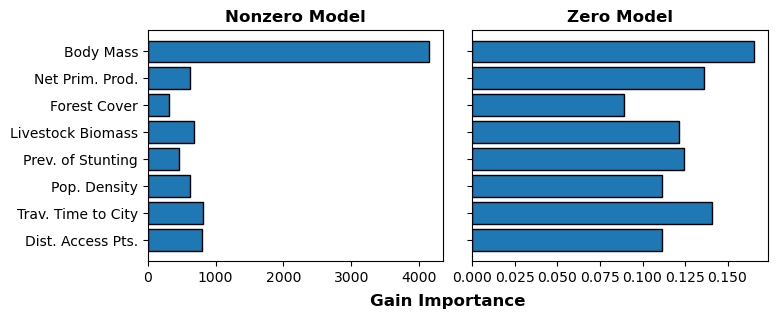

In [90]:
# Check feature importance
models = {'nonzero' : hurdle_model.nonzero_model, 'zero' : hurdle_model.zero_model}

fig, axs = plt.subplots(1, 2, figsize = (8, 3), sharey = True)

for i, model_name in enumerate(models.keys()):
    ax = axs[i]
    
    model = models[model_name]
    model.model.estimator.importance_type = 'gain'
    
    imp = model.feature_importances_
    feat = np.array(model.feature_names_in_)
    feat = [plot_names[f] for f in feat]
    
    if embeddings_to_use is not None:
        imp_mask = imp > np.percentile(imp, 90)
        imp = imp[imp_mask]
        feat = feat[imp_mask]
    
    ax.barh(feat, imp, edgecolor = 'black')
    ax.set_title(f'{model_name} model'.title(), weight = 'bold')

fig.subplots_adjust(wspace = 0.1)
fig.supxlabel('Gain Importance', weight = 'bold', y = -0.05)

# plt.savefig(f'../figures/feature_importances_{dataset}.pdf', dpi = 300, bbox_inches = 'tight')
plt.show()

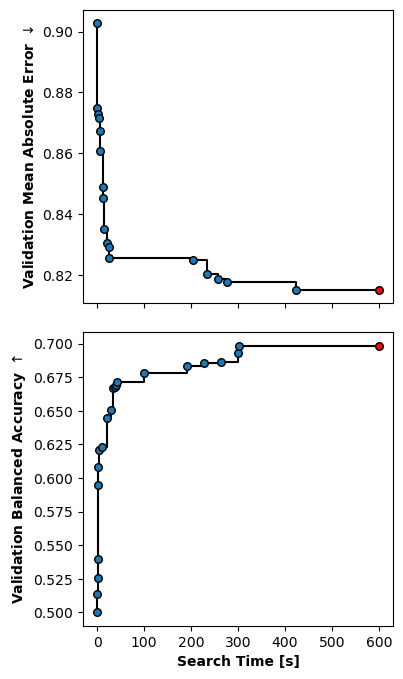

In [89]:
# An proof-of-concept for plotting the learning curve
from flaml.automl.data import get_output_from_log

fig, axs = plt.subplots(2, 1, figsize = (4, 8), sharex = True)

for i, model in enumerate(models.keys()):
    ax = axs[i]
    
    time_history, best_valid_loss_history, valid_loss_history, config_history, metric_history = get_output_from_log(filename = os.path.join(base_path, f'nonlinear_hurdle_{model.upper()}_{dataset}.log'), 
                                                                                                                    time_budget = time_budget_mins * 60)
    time_history.append(time_budget_mins * 60)
    best_valid_loss_history.append(best_valid_loss_history[-1])
    
    y_vals = 1 - np.array(best_valid_loss_history) if model == 'zero' else np.array(best_valid_loss_history)
    
    ax.step(time_history, y_vals, where = 'post', color = 'black', zorder = 0)
    ax.scatter(time_history[ : -1], y_vals[ : -1], s = 30, edgecolor = 'black', zorder = 100)
    ax.scatter(time_history[-1], y_vals[-1], s = 30, edgecolor = 'black', color = 'red', zorder = 100)
    
    y_label = 'Validation Balanced Accuracy $\\uparrow$' if model == 'zero' else 'Validation Mean Absolute Error $\\downarrow$'
    ax.set_ylabel(y_label, weight = 'bold')

fig.subplots_adjust(hspace = 0.1)
axs[1].set_xlabel('Search Time [s]', weight = 'bold')

# plt.savefig(f'../figures/learning_curve_{dataset}.pdf', dpi = 300, bbox_inches = 'tight')
plt.show()

# Misc Testing

## FLAML ensembling
Trying out stacked ensembling using FLAML to get a sense of how this works before integrating into actual hunting prediction task.

In [42]:
from sklearn.datasets import load_iris, load_diabetes
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

In [43]:
# Loading in the sklearn iris dataset just as a toy working example
diab_data = load_diabetes()

X = diab_data['data']
y = diab_data['target']

#  train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 1693)

In [66]:
# AutoML setup w/FLAML
automl = AutoML()
ens_params = {'passthrough' : True}
time_budget_secs = 60

#  autoML model search
automl.fit(X_train, y_train, task = 'regression', time_budget = time_budget_secs, ensemble = ens_params)

[flaml.automl.logger: 02-18 15:35:01] {1680} INFO - task = regression
[flaml.automl.logger: 02-18 15:35:01] {1691} INFO - Evaluation method: cv
[flaml.automl.logger: 02-18 15:35:01] {1789} INFO - Minimizing error metric: 1-r2
[flaml.automl.logger: 02-18 15:35:01] {1901} INFO - List of ML learners in AutoML Run: ['lgbm', 'rf', 'xgboost', 'extra_tree', 'xgb_limitdepth']
[flaml.automl.logger: 02-18 15:35:01] {2219} INFO - iteration 0, current learner lgbm
[flaml.automl.logger: 02-18 15:35:01] {2345} INFO - Estimated sufficient time budget=312s. Estimated necessary time budget=2s.
[flaml.automl.logger: 02-18 15:35:01] {2392} INFO -  at 0.0s,	estimator lgbm's best error=0.8038,	best estimator lgbm's best error=0.8038
[flaml.automl.logger: 02-18 15:35:01] {2219} INFO - iteration 1, current learner lgbm
[flaml.automl.logger: 02-18 15:35:01] {2392} INFO -  at 0.1s,	estimator lgbm's best error=0.8038,	best estimator lgbm's best error=0.8038
[flaml.automl.logger: 02-18 15:35:01] {2219} INFO - it

In [67]:
# Evaluating the final stacked ensemble
y_pred = automl.predict(X_test)
mae = np.mean(np.abs(y_pred - y_test))
print(f'Test MAE for the final stacked ensemble: {round(mae, 2)}')

Test MAE for the final stacked ensemble: 42.95


In [62]:
automl.model.final_estimator_.coef_

array([-9.08903726e-02,  4.73309660e-01, -2.97071465e-01,  3.40922926e-01,
        2.85558170e+01, -1.79830230e+02,  2.55652000e+02,  2.60928172e+02,
       -3.46851671e+01, -5.86834923e+01, -1.28304396e+02,  9.65167317e+01,
        3.44076289e+02,  1.89995144e+01])

In [63]:
X_train.shape

(309, 10)

In [64]:
automl.best_config_per_estimator

{'lgbm': {'n_estimators': 8,
  'num_leaves': 4,
  'min_child_samples': 12,
  'learning_rate': 0.2677050123105203,
  'log_max_bin': 7,
  'colsample_bytree': 0.930646190497405,
  'reg_alpha': 0.0013483649345371342,
  'reg_lambda': 1.4442580148221913},
 'rf': {'n_estimators': 4,
  'max_features': 0.9586055955836026,
  'max_leaves': 7},
 'xgboost': {'n_estimators': 14,
  'max_leaves': 4,
  'min_child_weight': 0.46909541099171265,
  'learning_rate': 0.18823612943305326,
  'subsample': 0.9015933928909102,
  'colsample_bylevel': 0.9225623172554771,
  'colsample_bytree': 0.9430451589336136,
  'reg_alpha': 0.006535953249353212,
  'reg_lambda': 0.010825666215970656},
 'extra_tree': {'n_estimators': 4,
  'max_features': 0.9586055955836026,
  'max_leaves': 7},
 'xgb_limitdepth': None}